# Atividade: Regressão para preços de alugueis e venda de imóveis em São Paulo

**D2APR – Aprendizado de Máquina e Reconhecimento de Padrões**
**D2TEC - Tecnologias de Big Data**

**IFSP Campinas**

Grupo:


*   Evandro Costa Ferreira (CP3021947)
*   Jaqueline Jana da Silva (CP3021891)
*   João Pedro de Oliveira Ferreira (CP3021696)

# 📊 1. Análise Exploratória

O arquivo considerando neste notebook encontra-se aqui;

https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019


In [1]:
## Rode o código abaixo, apenas se for necessário instalar os pacotes

#Instalando os pacotes necessários
# %pip install botocore==1.33.4
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install numpy
# %pip install folium
# %pip install scikit-learn
# %pip install sklearn
# %pip install IPython
# %pip install xgboost
# %pip install optuna
# %pip install lightgbm
# %pip install pickle
# %pip install awswrangler
# %pip install fsspec
# %pip install s3fs
# %pip install sagemaker
# %pip install numexpr


In [2]:
# Importando as bibliotecas necessárias
import awswrangler as wr
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mat
import numpy as np
import folium
from folium import plugins
from sklearn.model_selection import train_test_split
from IPython.display import display
from sagemaker import get_execution_role
from io import StringIO

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Definindo Função da análise descritiva

def analise_desc(data_treino, data_treino_0, data_treino_1, data_treino_2, data_treino_3, data_treino_4, coluna):

    # Obtendo os descritivos para cada base
    desc_treino = data_treino[coluna].describe().to_frame()
    desc_treino_0 = data_treino_0[coluna].describe().to_frame()
    desc_treino_1 = data_treino_1[coluna].describe().to_frame()
    desc_treino_2 = data_treino_2[coluna].describe().to_frame()
    desc_treino_3 = data_treino_3[coluna].describe().to_frame()
    desc_treino_4 = data_treino_4[coluna].describe().to_frame()

    # Renomeando as colunas para "Todas as Classes", "Centro", "Leste", "Norte", "Oeste" e "Sul"
    desc_treino.columns = ['Todas as Regiões']
    desc_treino_0.columns = ['Centro']
    desc_treino_1.columns = ['Leste']
    desc_treino_2.columns = ['Norte']
    desc_treino_3.columns = ['Oeste']
    desc_treino_4.columns = ['Sul']

    # Concatenando os dataframes em um único dataframe
    desc_concatenado = pd.concat([desc_treino, desc_treino_0, desc_treino_1, desc_treino_2, desc_treino_3, desc_treino_4], axis=1)

    return desc_concatenado.round(2)

In [4]:
# Definindo Função que faz bloxplot

def Box_Plot(data_treino, data_treino_0, data_treino_1, data_treino_2, data_treino_3, data_treino_4, nome_coluna):

    # Criando a figura e os subplots
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))

    # Função para adicionar as indicações de quartis nos boxplots
    def add_quartile_annotations(ax, data, delta, lim_sup, lim_inf):

        q1 = np.percentile(data, 25)
        median = np.percentile(data, 50)
        q3 = np.percentile(data, 75)

        q1_lim = (q1-lim_inf)/delta
        median_lim = (median-lim_inf)/delta
        q3_lim = (q3-lim_inf)/delta

        ax.text(0.05, q1_lim-0.05, f'Q1: {q1:.2f}', transform=ax.transAxes, ha='left')
        ax.text(0.1, median_lim+0.01, f'Mediana: {median:.2f}', transform=ax.transAxes, ha='left')
        ax.text(0.05, q3_lim+0.05, f'Q3: {q3:.2f}', transform=ax.transAxes, ha='left')

    # Plotando o primeiro boxplot (base treino)
    ax0 = sns.boxplot(y=data_treino, ax=axs[0], color = '#CCCCCC')
    axs[0].set_title('Todas as regiões')

    # Plotando o segundo boxplot (base treino_0)
    ax1 = sns.boxplot(y=data_treino_0, ax=axs[1], color = '#98FB98')
    axs[1].set_title('Centro')

    # Plotando o terceiro boxplot (base treino_1)
    ax2 = sns.boxplot(y=data_treino_1, ax=axs[2], color = '#ADD8E6')
    axs[2].set_title('Leste')

    # Plotando o quarto boxplot (base treino_2)
    ax3 = sns.boxplot(y=data_treino_2, ax=axs[3], color = '#FFC0CB')
    axs[3].set_title('Norte')

    # Plotando o quarto boxplot (base treino_3)
    ax4 = sns.boxplot(y=data_treino_3, ax=axs[4], color = '#FFD700')
    axs[4].set_title('Oeste')

    # Plotando o quarto boxplot (base treino_4)
    ax5 = sns.boxplot(y=data_treino_4, ax=axs[5], color = '#A9A9A9')
    axs[5].set_title('Sul')

    # Configurando as legendas dos eixos
    for ax in axs:
        ax.set_ylabel(nome_coluna)
        ax.set_xlabel('')
        ax.set_ylim(ax0.get_ylim())

    x, y = ax0.get_ylim()

    add_quartile_annotations(ax0, data_treino, delta = y-x, lim_sup = y, lim_inf =x)
    add_quartile_annotations(ax1, data_treino_0, delta = y-x, lim_sup = y, lim_inf =x)
    add_quartile_annotations(ax2, data_treino_1, delta = y-x, lim_sup = y, lim_inf = x)
    add_quartile_annotations(ax3, data_treino_2, delta = y-x, lim_sup = y, lim_inf = x)
    add_quartile_annotations(ax4, data_treino_3, delta = y-x, lim_sup = y, lim_inf = x)
    add_quartile_annotations(ax5, data_treino_4, delta = y-x, lim_sup = y, lim_inf = x)

    # Exibindo o gráfico
    plt.tight_layout()
    plt.show()

In [5]:
# Definindo Função que cálcula a distribuição dos dados, considerando o District_Zone como agrupamento.

def Distribuicao(base_a, base_b, nome_base_a, nome_base_b, coluna, rotulo):

  # Média de valores da coluna informada, por zona para Base A
  mean_base_a = base_a.groupby('district_zone')[coluna].mean()
  zones_base_a = mean_base_a.index
  mean_values_base_a = mean_base_a.values
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))


  # Média de tamanho por zona para Base B
  mean_base_b = base_b.groupby('district_zone')[coluna].mean()
  zones_base_b = mean_base_b.index
  mean_values_base_b = mean_base_b.values
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Cria uma figura com 2 subplots

  # Plota o gráfico de barras para a Base A no primeiro subplot
  bars1 = axs[0].bar(zones_base_a, mean_values_base_a, color=colors_base_a(np.arange(len(zones_base_a))))
  axs[0].set_xlabel('Zona do Distrito')
  axs[0].set_ylabel(f'Média de {rotulo} ({nome_base_a})')
  axs[0].set_title(f'Média de {rotulo} por Zona do Distrito ({nome_base_a})')

  # Adiciona rótulos para o primeiro gráfico
  for bar, label in zip(bars1, mean_values_base_a):
      axs[0].text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, str(round(label, 2)), fontsize=10, ha='center')

  # Plota o gráfico de barras para a Base B no segundo subplot
  bars2 = axs[1].bar(zones_base_b, mean_values_base_b, color=colors_base_b(np.arange(len(zones_base_b))))
  axs[1].set_xlabel('Zona do Distrito')
  axs[1].set_ylabel(f'Média de {rotulo} ({nome_base_a})')
  axs[1].set_title(f'Média de {rotulo} por Zona do Distrito ({nome_base_b})')

  # Adiciona rótulos para o segundo gráfico
  for bar, label in zip(bars2, mean_values_base_b):
      axs[1].text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, str(round(label, 2)), fontsize=10, ha='center')

  plt.tight_layout()
  plt.show()

In [6]:
# Definindo a função que cria um mapa centrado em São Paulo

def Mapa(base):

  sp_map = folium.Map(location=[-23.5505, -46.6333], zoom_start=11)

  # Adicionar marcadores de calor
  heat_data = [[row['latitude'], row['longitude'], row['price'], row['district_zone']] for index, row in base.iterrows()]

  # Adicionar cores de acordo com a região
  color_dict = {
      'Leste': 'blue',
      'Centro': 'green',
      'Sul': 'red',
      'Oeste': 'purple',
      'Norte': 'orange',
  }

  for lat, lon, price, region in heat_data:
      folium.CircleMarker(
          location=[lat, lon],
          radius=5,
          color=color_dict.get(region, 'gray'),  # Usar cinza para regiões não mapeadas
          fill=True,
          fill_color=color_dict.get(region, 'gray'),
          fill_opacity=0.7,
          popup=f"Região: {region}<br>Preço: R$ {price:.2f}",
      ).add_to(sp_map)

  # Adicionar um mapa de calor
  heat_df = pd.DataFrame(heat_data, columns=['latitude', 'longitude', 'price', 'district_zone'])
  heat_df = heat_df.dropna(subset=['latitude', 'longitude', 'price'])
  heat_data = heat_df[['latitude', 'longitude', 'price']].values

  sp_map.add_child(plugins.HeatMap(heat_data, radius=15))

  # Exibir o mapa na tela
  display(sp_map)

In [7]:
def GraficoBarrasEmpilhadas(base, titulos, feature, rotulo):

  # Calcular a média por região para cada DataFrame
  mean_by_region = [df.groupby('district_zone')[feature].mean() for df in base]

  # Definindo as cores
  colors = sns.color_palette("Set1", n_colors=2)

  # Plotando os gráficos de barras empilhadas lado a lado
  fig, axs = plt.subplots(1, 2, figsize=(14, 6))

  for i, df in enumerate(base):
      counts = df.groupby(['district_zone', feature]).size().unstack(fill_value=0)
      counts.plot(kind='bar', stacked=True, color=colors, ax=axs[i], alpha=0.7)

      # Adicionar média por região
      for region, mean in mean_by_region[i].items():
          total = counts.loc[region].sum()
          count_with = counts.loc[region, 1]
          count_without = counts.loc[region, 0]
          percent_with = (count_with / total) * 100
          percent_without = (count_without / total) * 100

          # Anotar dentro da barra (Sim)
          axs[i].annotate(f'{count_with} \n ({percent_with:.2f}%)',
                          xy=(list(counts.index).index(region), count_with / 2),
                          xytext=(0, 1), textcoords='offset points', ha='center', fontsize=10, color='black')

          # Anotar dentro da barra (Não)
          axs[i].annotate(f'{count_without} \n ({percent_without:.2f}%)',
                          xy=(list(counts.index).index(region), ((count_with + count_without) /2 + count_with)),
                          xytext=(0, 1), textcoords='offset points', ha='center', fontsize=10, color='black')


      axs[i].set_xlabel('Região do Distrito', fontsize=12)
      axs[i].set_ylabel(f'Quantidade de imóveis', fontsize=12)
      axs[i].set_title(f'Quantidade de imóveis por Região ({titulos[i]})', fontsize=14)
      axs[i].set_xticklabels(counts.index, rotation=45, fontsize=10)
      axs[i].legend(title=f'{rotulo}', labels=['Sim', 'Não'], fontsize=10, title_fontsize=10)
      axs[i].grid(axis='y', linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [8]:
def GraficoBarrasLadoALado(base, titulos, feature, rotulo):
  # Calcular a média por região para cada DataFrame
  mean_by_region = [df.groupby('district_zone')[feature].mean() for df in base]

  # Definindo as cores
  colors = sns.color_palette("Set1", n_colors=2)

  # Plotando os gráficos de barras lado a lado
  fig, axs = plt.subplots(1, 2, figsize=(14, 6))

  for i, df in enumerate(base):
    counts = df.groupby(['district_zone', feature]).size().unstack(fill_value=0)

    # Coordenadas x para as barras "Sim" e "Não"
    x = np.arange(len(counts.index))

    # Largura das barras
    bar_width = 0.35

    # Criar barras para "Sim" e "Não" lado a lado
    axs[i].bar(x - bar_width/2, counts[1], bar_width, color=colors[0], alpha=0.7, label='Sim')
    axs[i].bar(x + bar_width/2, counts[0], bar_width, color=colors[1], alpha=0.7, label='Não')

    axs[i].set_xlabel('Região do Distrito', fontsize=12)
    axs[i].set_ylabel(f'Quantidade de imóveis', fontsize=12)
    axs[i].set_title(f'Quantidade de imóveis por Região ({titulos[i]})', fontsize=14)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(counts.index, rotation=45, fontsize=10)
    axs[i].legend(title=f'{rotulo}', labels=['Sim', 'Não'], fontsize=10, title_fontsize=10)
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)

    # Adicionar porcentagens em cima das barras
    for xi, region in enumerate(counts.index):
      total = counts.loc[region].sum()
      count_with = counts.loc[region, 1]
      count_without = counts.loc[region, 0]
      percent_with = (count_with / total) * 100
      percent_without = (count_without / total) * 100

      axs[i].annotate(f'{percent_with:.2f}%', xy=(x[xi] - bar_width/2, count_with), ha='center', fontsize=10, color='black')
      axs[i].annotate(f'{percent_without:.2f}%', xy=(x[xi] + bar_width/2, count_without), ha='center', fontsize=10, color='black')

  plt.tight_layout()
  plt.show()


In [9]:
def GraficoDispersao(base_a, base_b, titulo, xlabel, ylabel):
  plt.figure(figsize=(10, 6))  # Define o tamanho do gráfico

  # Cria o gráfico de dispersão
  plt.scatter(base_a, base_b, alpha = 0.5)
  plt.title(titulo)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.show()

In [10]:
# Printando função com o score, média e desvio padrão
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Importando os dados pré-processados

O intuito é prevermos os valores de venda e aluguel de imóveis, em São Paulo, considerando as bases separadas previamente separadas.

Sendo assim, vamos ler as base de dados e mostrar parte dos dados

In [11]:
def get_data(bucket_name, response):
    objects = response.get('Contents', [])
    csv_files = [obj['Key'] for obj in objects]
    # Lendo os arquivos CSV e concatenando os resultados
    dfs = []

    for csv_file in csv_files:
        # Obter o conteúdo do arquivo
        response = s3_client.get_object(Bucket=bucket_name, Key=csv_file)
        content = response['Body'].read().decode('utf-8')

        # Verificar se o conteúdo não está vazio
        if content.strip():  # Verifica se o conteúdo não é apenas espaços em branco
            # Ler o conteúdo como DataFrame
            df = pd.read_csv(StringIO(content))
            dfs.append(df)

    if dfs:
        base_input = pd.concat(dfs, ignore_index=True)
        return base_input
    else:
        return None

In [12]:
# Obter o role de execução do SageMaker
role = get_execution_role()

# Nome do bucket e caminho para a pasta
bucket_name = 'input-propriedades'
folder_path_aluguel = 'processed/aluguel'
folder_path_venda = 'processed/venda'

# Configurar o cliente S3
s3_client = boto3.client('s3')

# Listar objetos no caminho especificado
response_aluguel = s3_client.list_objects(Bucket=bucket_name, Prefix=folder_path_aluguel)
response_venda = s3_client.list_objects(Bucket=bucket_name, Prefix=folder_path_venda)

## Puxando os dados de aluguel
base_aluguel = get_data(bucket_name, response_aluguel)
print(f'\n BASE ALUGUEL: \n\n {base_aluguel.head()}')

## Puxando os dados de venda
base_venda = get_data(bucket_name, response_venda)
print(f'\n BASE VENDA: \n\n {base_venda.head()}')





sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

 BASE ALUGUEL: 

    price  elevator  furnished  size district_zone  toilets property_type  \
0   1500         0          0   230         Leste        2     apartment   
1   1000         1          0    55         Leste        2     apartment   
2   1300         1          1    50         Leste        2     apartment   
3   4500         1          0    87         Leste        2     apartment   
4    900         0          0    35         Leste        2     apartment   

   condo  swimming_pool  rooms negotiation_type  parking  suites  new  
0   2893              0      3             rent        2       1    0  
1    395              1      2             rent        1       1    0  
2      0              1      2             rent        1       1    0  
3   1100              0      2

Em nossa base de dados temos as seguintes colunas:


*   **Price:** Preço final anunciado (R$ Reais Brasileiros)
*   **Condo:** Despesas do condomínio
*   **Size:** Tamanho da propriedade em metros quadrados (m²) (apenas áreas privativas)
*   **Rooms:** Número de quartos
*   **Toilets:** Número de banheiros
*   **Suites:** Número de quartos com banheiro privativo
*   **Parking:** Número de vagas de estacionamento
*   **Elevator:** Valor binário: 1 se houver elevador no prédio, 0 caso contrário
*   **Furnished:** Valor binário: 1 se a propriedade estiver mobiliada, 0 caso contrário
*   **Swimming Pool:** Valor binário: 1 se a propriedade tiver piscina, 0 caso contrário
*   **New:** Valor binário: 1 se a propriedade for muito nova, 0 caso contrário
*   **District:** O bairro e a cidade onde a propriedade está localizada
*   **Negotiation Type:** Venda ou Aluguel
*   **Property Type:** O tipo de propriedade
*   **Latitude:** Latitude
*   **Longitude:** Longitude


_Essa informação consta no catálogo de dados, gerado pelo GLUE._

In [13]:
base_aluguel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14038 entries, 0 to 14037
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             14038 non-null  int64 
 1   elevator          14038 non-null  int64 
 2   furnished         14038 non-null  int64 
 3   size              14038 non-null  int64 
 4   district_zone     14038 non-null  object
 5   toilets           14038 non-null  int64 
 6   property_type     14038 non-null  object
 7   condo             14038 non-null  int64 
 8   swimming_pool     14038 non-null  int64 
 9   rooms             14038 non-null  int64 
 10  negotiation_type  14038 non-null  object
 11  parking           14038 non-null  int64 
 12  suites            14038 non-null  int64 
 13  new               14038 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 1.5+ MB


**Comentário:** Note que o dataframe possui 7019 linhas e em nenhuma coluna temos valores nulos puro. Onze colunas são formadas por valores inteiros, quarto são object (string) e duas são valores float (colunas de latitude e longitude).

In [14]:
base_venda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12604 entries, 0 to 12603
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             12604 non-null  int64 
 1   elevator          12604 non-null  int64 
 2   furnished         12604 non-null  int64 
 3   size              12604 non-null  int64 
 4   district_zone     12604 non-null  object
 5   toilets           12604 non-null  int64 
 6   property_type     12604 non-null  object
 7   condo             12604 non-null  int64 
 8   swimming_pool     12604 non-null  int64 
 9   rooms             12604 non-null  int64 
 10  negotiation_type  12604 non-null  object
 11  parking           12604 non-null  int64 
 12  suites            12604 non-null  int64 
 13  new               12604 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 1.3+ MB


**Comentário:** Note que o dataframe possui 6302 linhas e em nenhuma coluna temos valores nulos puro. Onze colunas são formadas por valores inteiros, quarto são object (string) e duas são valores float (colunas de latitude e longitude).

_Todo o pré-processamento, foi realizado via ETL com o GLUE.
Logo, iremos trabalhar com a base já tratada._


### Análise Visual

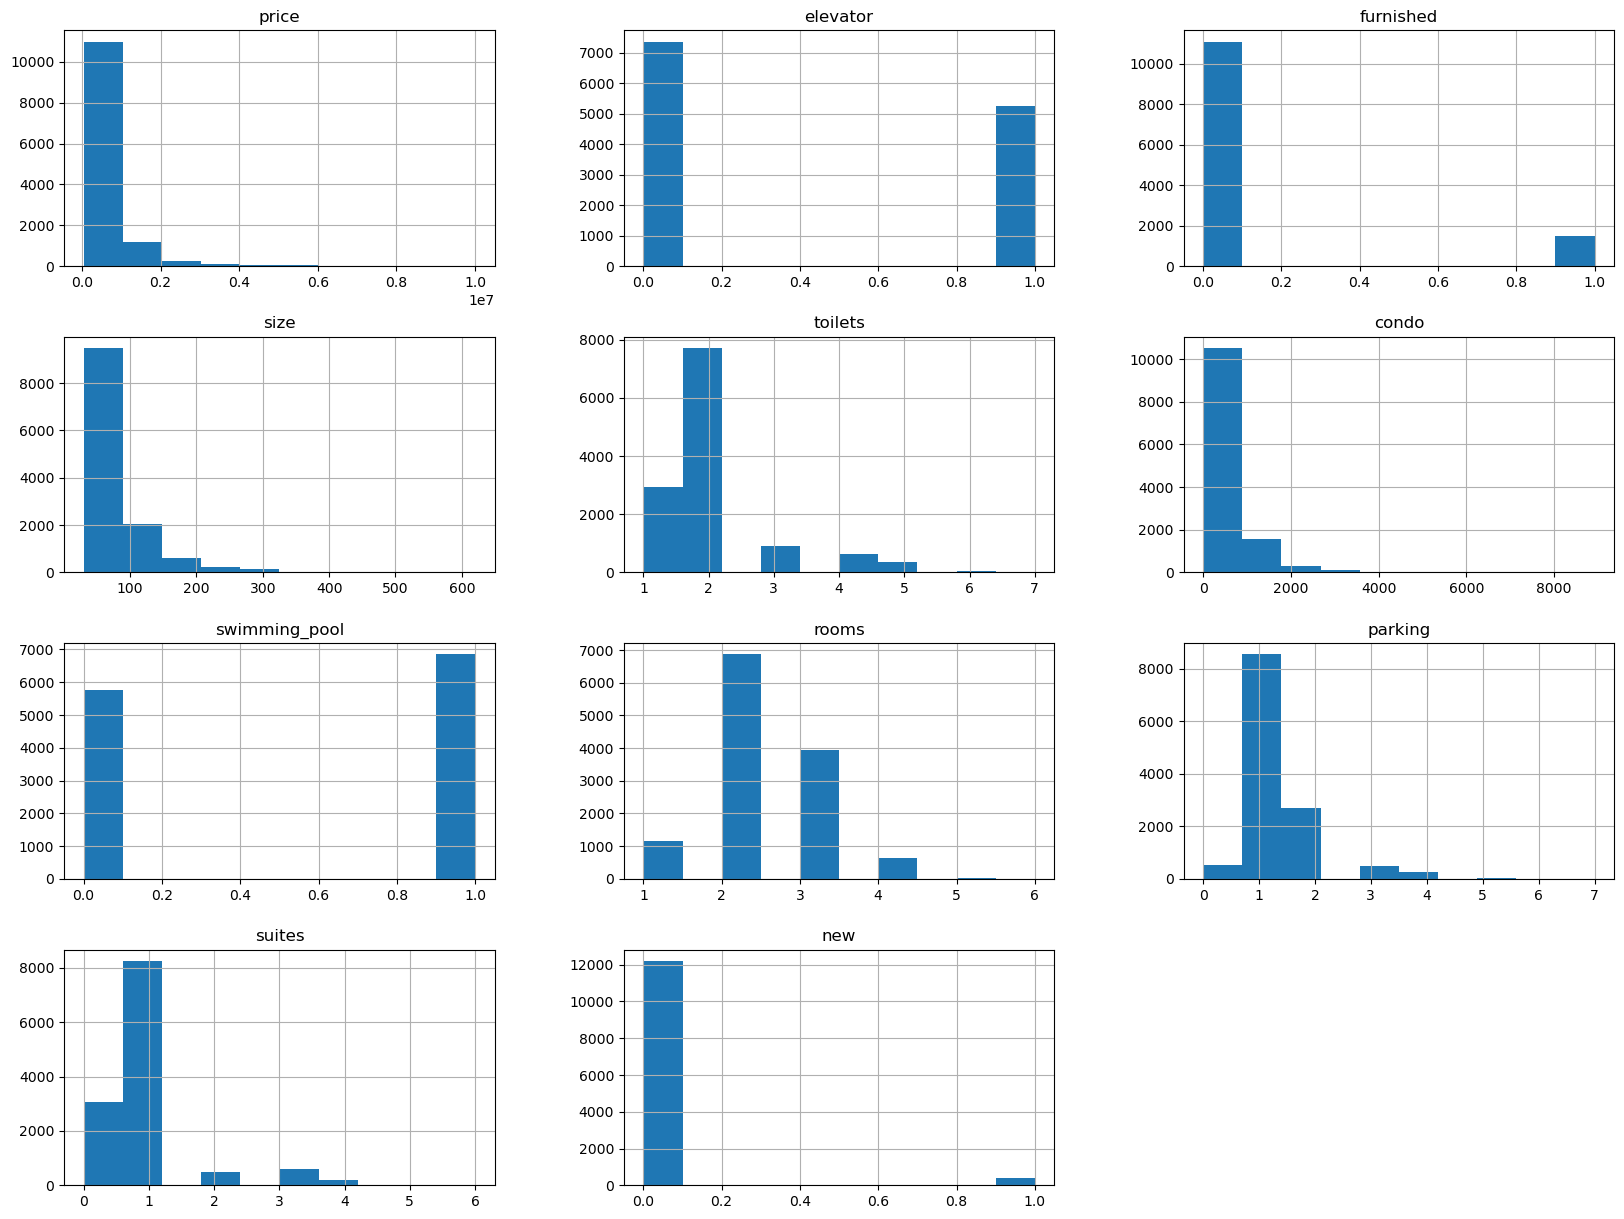

In [15]:
# Plotando o histograma, para os atributos númericos, da base de vendas.
base_venda.hist(figsize=(20,15))
display()

**Comentário:** Pelos histogramas, podemos ver que a quantidade de imóveis à venda novos é muito inferir a quantidade de imóveis "antigos". Vemos também que a maioria dos imóveis não está mobiliada, e aproxidamente 2/3 dos imóveis possui elevador.

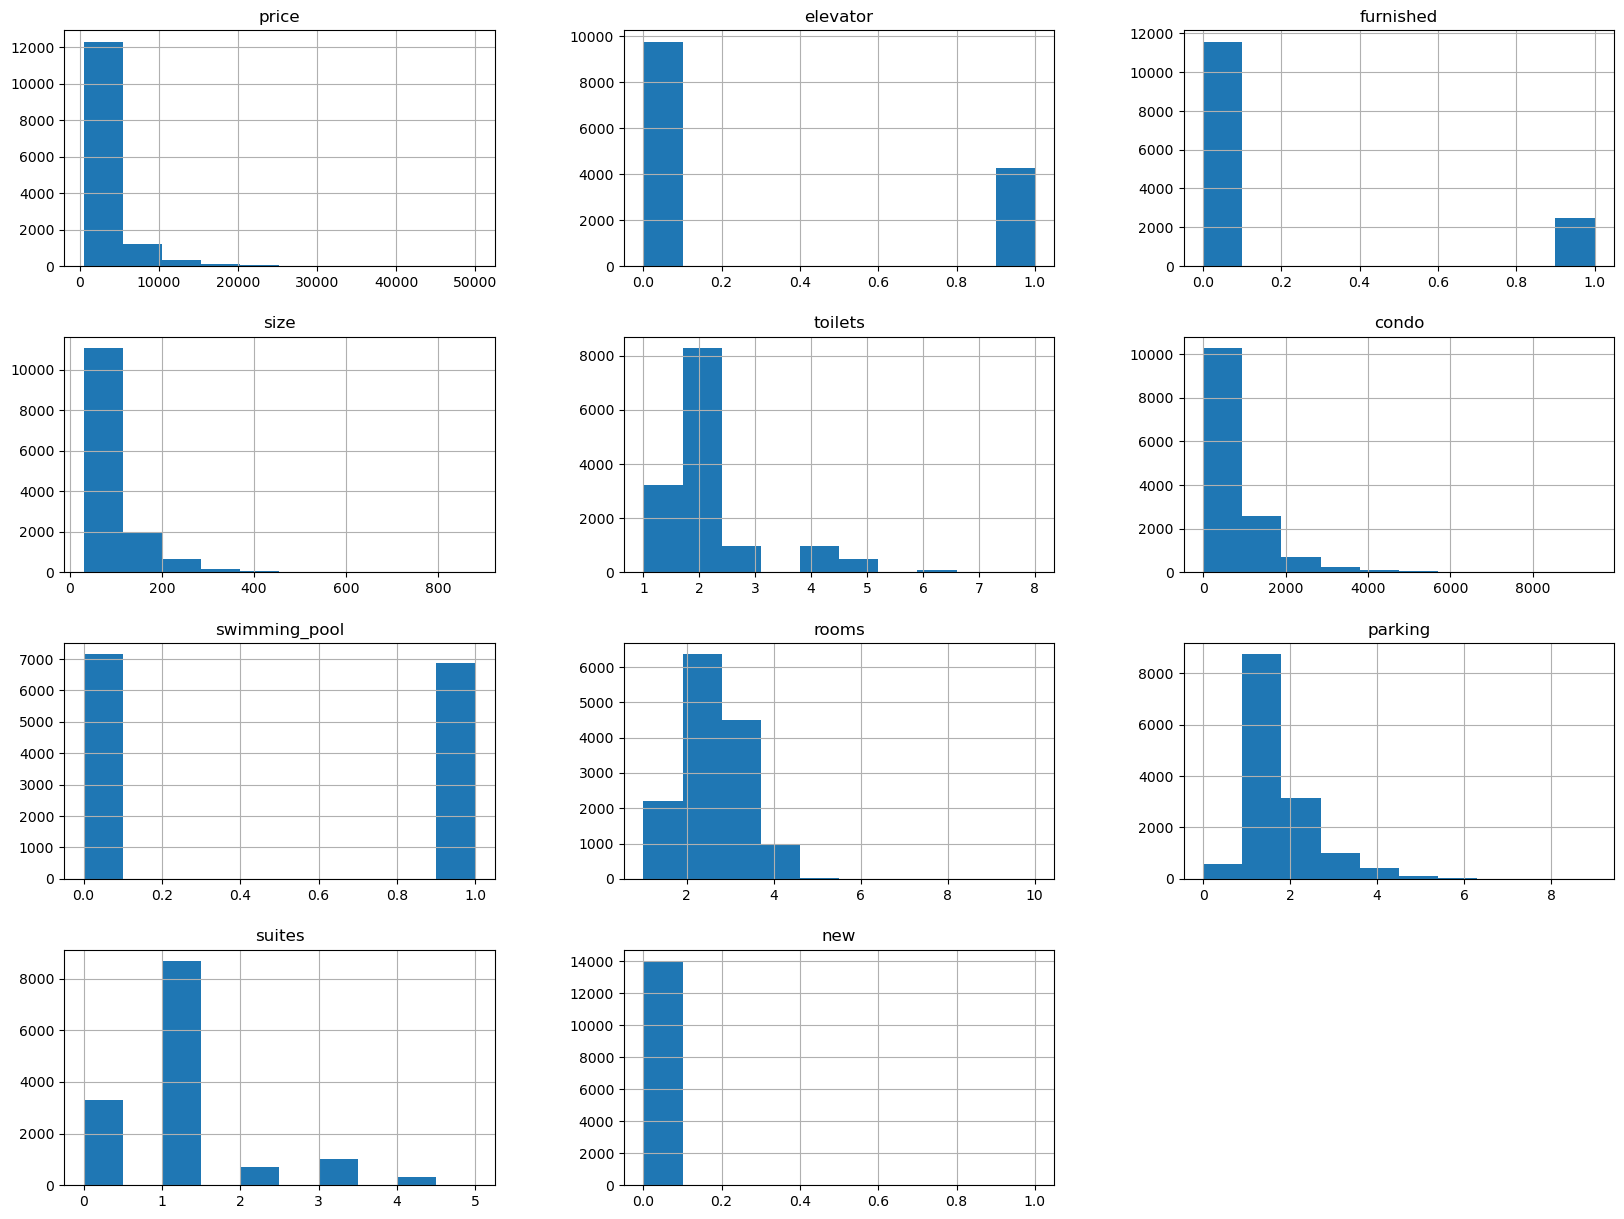

In [16]:
# Plotando o histograma, para os atributos númericos, da base de aluguéis.
base_aluguel.hist(figsize=(20,15))
display()

**Comentário:** Pelos histogramas, podemos ver que o comportamento é semelhante ao de imóveis à venda

In [17]:
# Visualizando a base de dados no mapa de SP
# base = pd.concat([base_venda, base_aluguel], ignore_index=True)
# Mapa(base)

**Comentário:** Com base no mapa gerado, vemos que há imóveis constando que pertencem a cidade de São Paulo, mas suas coordenadas são de outras cidades.

Para tratar isso, podemos seguir de duas formas:
* Assumir que as informações na coluna District estão corretas e serão utilizadas para apontar a localização, ou
* Assumir que a informação das coordenadas (Latitude e Longitude) estão corretas, e precisaremos retirar os outliers da base.

Como não temos mais informações dos imóveis para checar a sua real localização, decidimos assumir que a informação em District está correta, mantendo assim todos os dados na base, e ignorando as colunas de coordenadas.


# Separação: Treino e Teste

Agora será feita a separação entre base de treino e teste.
Iremos utilizar a coluna Distric_Zone como parâmetro para estratificação (será mantida a mesma proporção entre zonas no conjunto de teste e treino)

In [18]:
# Filtrando bases

base_venda_centro = base_venda.loc[base_venda['district_zone'] == 'Centro']
base_venda_leste = base_venda.loc[base_venda['district_zone'] == 'Leste']
base_venda_norte = base_venda.loc[base_venda['district_zone'] == 'Norte']
base_venda_oeste = base_venda.loc[base_venda['district_zone'] == 'Oeste']
base_venda_sul = base_venda.loc[base_venda['district_zone'] == 'Sul']

base_aluguel_centro = base_aluguel.loc[base_aluguel['district_zone'] == 'Centro']
base_aluguel_leste = base_aluguel.loc[base_aluguel['district_zone'] == 'Leste']
base_aluguel_norte = base_aluguel.loc[base_aluguel['district_zone'] == 'Norte']
base_aluguel_oeste = base_aluguel.loc[base_aluguel['district_zone'] == 'Oeste']
base_aluguel_sul = base_aluguel.loc[base_aluguel['district_zone'] == 'Sul']

In [19]:
# Fazendo proporção de 80% para treino e 20% para teste

train_base_venda_centro, teste_base_venda_centro = train_test_split(base_venda_centro, test_size=0.2, random_state=42)
train_base_venda_leste, teste_base_venda_leste = train_test_split(base_venda_leste, test_size=0.2, random_state=42)
train_base_venda_norte, teste_base_venda_norte = train_test_split(base_venda_norte, test_size=0.2, random_state=42)
train_base_venda_oeste, teste_base_venda_oeste = train_test_split(base_venda_oeste, test_size=0.2, random_state=42)
train_base_venda_sul, teste_base_venda_sul = train_test_split(base_venda_sul, test_size=0.2, random_state=42)

train_base_aluguel_centro, teste_base_aluguel_centro = train_test_split(base_aluguel_centro, test_size=0.2, random_state=42)
train_base_aluguel_leste, teste_base_aluguel_leste = train_test_split(base_aluguel_leste, test_size=0.2, random_state=42)
train_base_aluguel_norte, teste_base_aluguel_norte = train_test_split(base_aluguel_norte, test_size=0.2, random_state=42)
train_base_aluguel_oeste, teste_base_aluguel_oeste = train_test_split(base_aluguel_oeste, test_size=0.2, random_state=42)
train_base_aluguel_sul, teste_base_aluguel_sul = train_test_split(base_aluguel_sul, test_size=0.2, random_state=42)

In [20]:
# Concatenando as bases

treino_base_venda = pd.concat([train_base_venda_centro, train_base_venda_leste, train_base_venda_norte, train_base_venda_oeste, train_base_venda_sul], ignore_index=True)
teste_base_venda = pd.concat([teste_base_venda_centro, teste_base_venda_leste, teste_base_venda_norte, teste_base_venda_oeste, teste_base_venda_sul], ignore_index=True)

treino_base_aluguel = pd.concat([train_base_aluguel_centro, train_base_aluguel_leste, train_base_aluguel_norte, train_base_aluguel_oeste, train_base_aluguel_sul], ignore_index=True)
teste_base_aluguel = pd.concat([teste_base_aluguel_centro, teste_base_aluguel_leste, teste_base_aluguel_norte, teste_base_aluguel_oeste, teste_base_aluguel_sul], ignore_index=True)

In [21]:
# Verificando percentual da base de treino para venda

result_venda_treino = treino_base_venda.groupby('district_zone').size().reset_index(name='qtd')
result_venda_treino['percentual'] = round(result_venda_treino['qtd'] / len(treino_base_venda) * 100,2)
result_venda_treino

district_zone   qtd  percentual
0        Centro  1420       14.09
1         Leste  3616       35.87
2         Norte  1624       16.11
3         Oeste  1457       14.45
4           Sul  1964       19.48

In [22]:
# Verificando percentual da base de teste para venda

result_venda_teste = teste_base_venda.groupby('district_zone').size().reset_index(name='qtd')
result_venda_teste['percentual'] = round(result_venda_teste['qtd'] / len(teste_base_venda) * 100,2)
result_venda_teste

district_zone  qtd  percentual
0        Centro  356       14.11
1         Leste  904       35.83
2         Norte  406       16.09
3         Oeste  365       14.47
4           Sul  492       19.50

In [23]:
# Verificando percentual da base de treino para aluguel

result_aluguel_treino = treino_base_aluguel.groupby('district_zone').size().reset_index(name='qtd')
result_aluguel_treino['percentual'] = round(result_aluguel_treino['qtd'] / len(treino_base_aluguel) * 100,2)
result_aluguel_treino

district_zone   qtd  percentual
0        Centro  1140       10.15
1         Leste  2862       25.49
2         Norte  1702       15.16
3         Oeste  2780       24.76
4           Sul  2744       24.44

In [24]:
# Verificando percentual da base de teste para aluguel

result_aluguel_teste = teste_base_aluguel.groupby('district_zone').size().reset_index(name='qtd')
result_aluguel_teste['percentual'] = round(result_aluguel_teste['qtd'] / len(teste_base_aluguel) * 100,2)
result_aluguel_teste

district_zone  qtd  percentual
0        Centro  286       10.18
1         Leste  716       25.48
2         Norte  426       15.16
3         Oeste  696       24.77
4           Sul  686       24.41

**Comentários:** note que os percentuais ficaram bem alinhados entre treino e teste tanto na base de aluguel como na base de venda

# 📊 1.01 Análise Exploratória - Price

Preço final anunciado (R$ Reais Brasileiros)

In [25]:
print("Análise - Preço - Venda\n")
desc_price_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'price')
desc_price_venda

Análise - Preço - Venda



Todas as Regiões      Centro        Leste       Norte       Oeste  \
count          10081.00     1420.00      3616.00     1624.00     1457.00   
mean          611281.46   587070.63    381819.55   482829.93  1193673.24   
std           741720.73   523070.41    495612.60   357103.12  1229070.49   
min            42000.00    42000.00     45000.00    87000.00   125000.00   
25%           250000.00   318000.00    200000.00   285000.00   528500.00   
50%           380000.00   435000.00    265000.00   379000.00   800000.00   
75%           680000.00   650000.00    400000.00   550000.00  1300000.00   
max         10000000.00  5000000.00  10000000.00  3490000.00  8500000.00   

              Sul  
count     1964.00  
mean    725423.07  
std     757065.50  
min      98815.00  
25%     280000.00  
50%     455500.00  
75%     850000.00  
max    6950000.00

In [26]:
print("Análise - Preço - Aluguel\n")
desc_price = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'price')
desc_price

Análise - Preço - Aluguel



Todas as Regiões    Centro     Leste     Norte     Oeste       Sul
count          11228.00   1140.00   2862.00   1702.00   2780.00   2744.00
mean            3115.05   2922.65   1838.14   1794.21   4611.96   3829.51
std             3618.96   2572.97   1904.76   1045.10   4746.78   4241.02
min              480.00    630.00    480.00    500.00    840.00    700.00
25%             1350.00   1600.00   1100.00   1200.00   2000.00   1600.00
50%             2000.00   2200.00   1400.00   1500.00   3000.00   2400.00
75%             3301.00   3200.00   2000.00   2100.00   5500.00   4000.00
max            50000.00  23000.00  45000.00  15000.00  50000.00  50000.00

/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


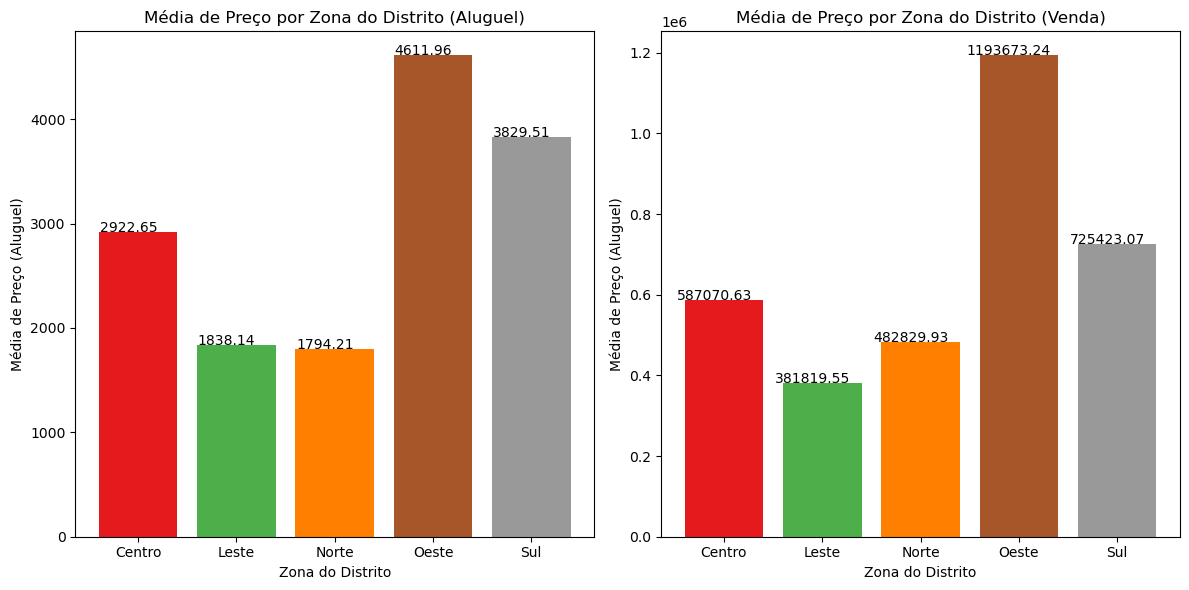

In [27]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'price', 'Preço')

**Comentário**: Vemos que a maioria dos imóveis que se encontram na região Oeste e Sul, possui uma média de preços, tanto aluguel quanto venda, superior as demais regiões.

# 📊 1.02 Análise Exploratória - Condo

Despesas do condomínio

In [28]:
print("Análise - Condo - Venda\n")
desc_condo_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'condo')
desc_condo_venda

Análise - Condo - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean             540.02   618.59   324.90   424.04   963.26   661.20
std              620.34   557.90   326.65   426.41   951.16   696.23
min                0.00     0.00     0.00     0.00     0.00     0.00
25%              160.00   317.25    70.00     0.00   413.00   275.00
50%              400.00   500.00   290.00   398.00   752.00   500.00
75%              700.00   738.50   450.00   588.50  1200.00   850.00
max             7428.00  4874.00  3300.00  3200.00  7428.00  5400.00

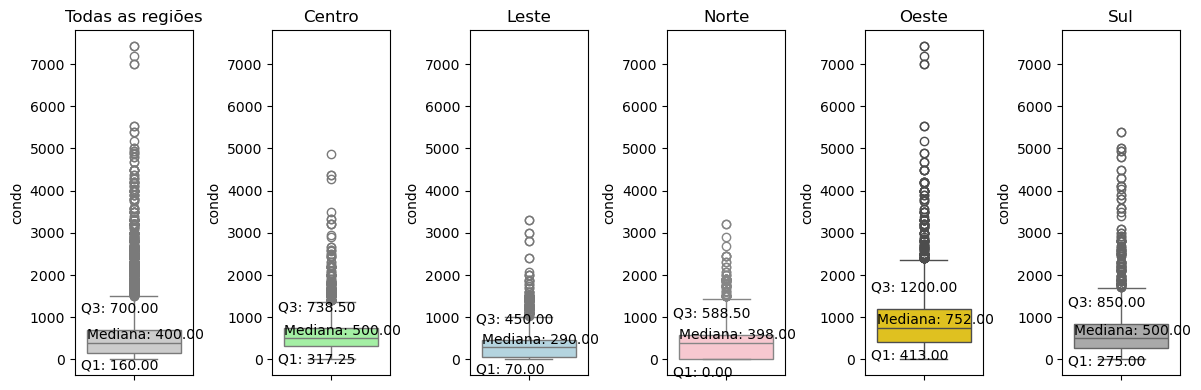

In [29]:
Box_Plot(data_treino = treino_base_venda['condo'], data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro']['condo'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste']['condo'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte']['condo'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste']['condo'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul']['condo'], nome_coluna = 'condo')

In [30]:
print("Análise - Condo - aluguel\n")
desc_condo_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'condo')
desc_condo_aluguel

Análise - Condo - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean             829.43   812.53   469.86   594.41  1223.35   958.16
std              839.84   819.25   440.62   444.32  1048.94   908.54
min                0.00     0.00     0.00     0.00     0.00     0.00
25%              398.00   405.00   190.00   392.00   580.00   466.00
50%              600.00   586.50   409.50   505.00   900.00   688.50
75%             1000.00   850.00   600.00   690.00  1500.00  1161.50
max             9500.00  7928.00  4800.00  3508.00  9500.00  8860.00

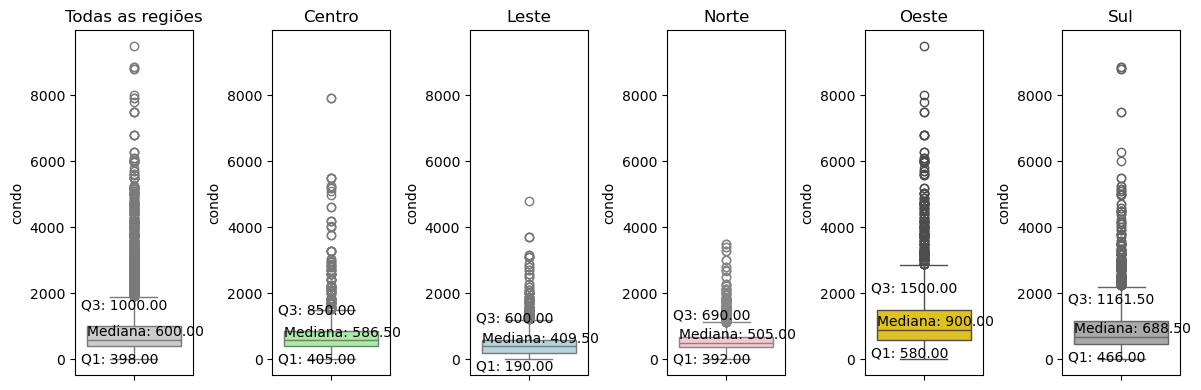

In [31]:
Box_Plot(data_treino = treino_base_aluguel['condo'], data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro']['condo'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste']['condo'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte']['condo'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste']['condo'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul']['condo'], nome_coluna = 'condo')

/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


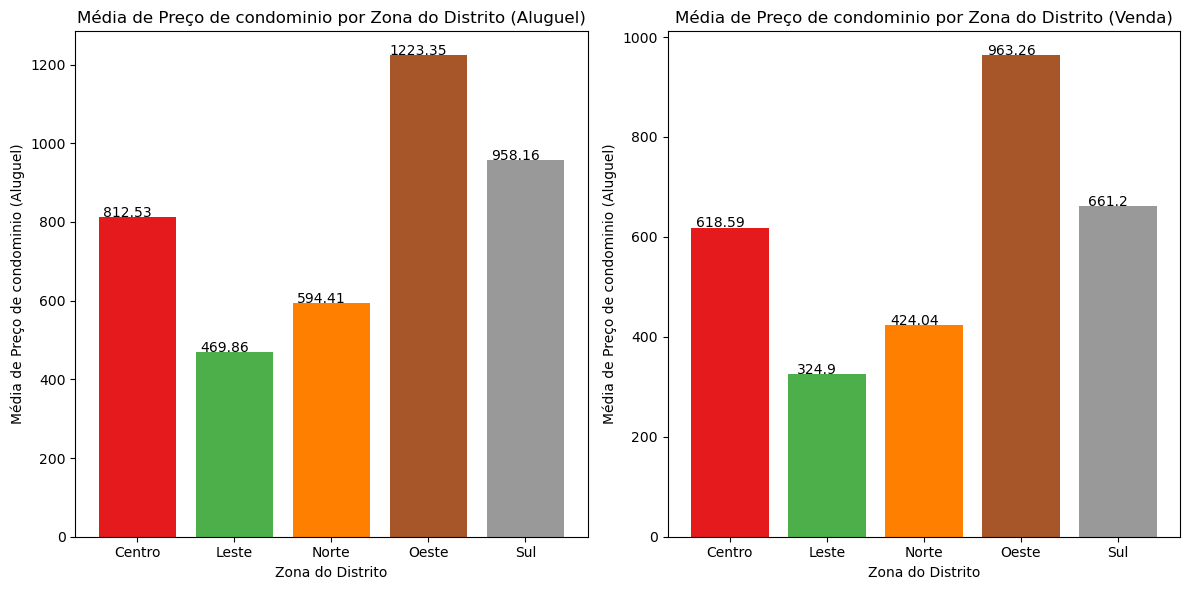

In [32]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'condo', 'Preço de condominio')

**Comentário**: Vemos que os valores de condominio nas regiões Oeste e Sul, são maiores em relação as demais regiões. O mesmo comportamento visto no preço dos imóveis.
Isso era de se esperar: imóveis mais caros, estão em melhores localizações e possuem maior "infraestrutura", aumentando assim seu custo final

# 📊 1.03 Análise Exploratória - Size

Tamanho da propriedade em metros quadrados (m²) (apenas áreas privativas)

In [33]:
print("Análise - Size - Venda\n")
desc_size_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'size')
desc_size_venda

Análise - Size - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean              78.70    79.18    64.10    75.26   108.97    85.64
std               50.68    58.42    33.55    43.81    68.09    49.93
min               30.00    30.00    30.00    34.00    30.00    30.00
25%               50.00    45.00    47.00    51.00    66.00    54.00
50%               62.00    59.00    54.00    64.00    88.00    67.00
75%               87.00    91.00    66.00    80.00   130.00   100.00
max              620.00   420.00   343.00   505.00   620.00   360.00

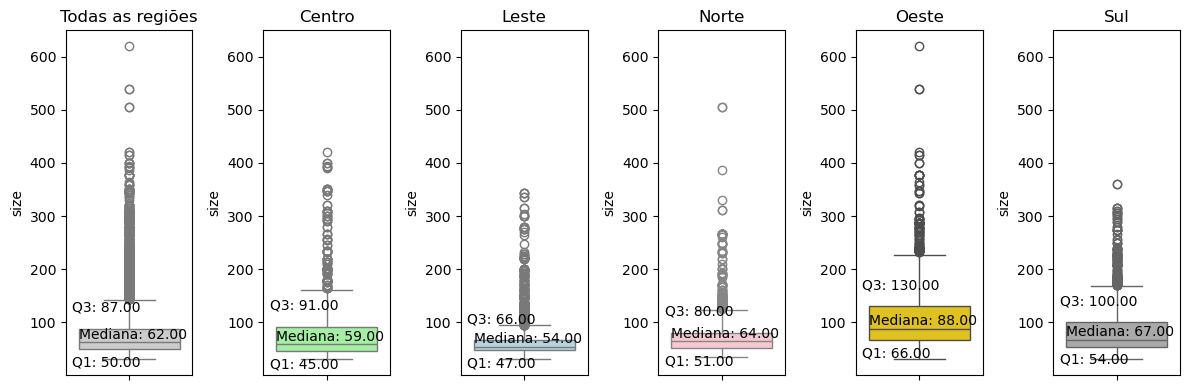

In [34]:
Box_Plot(data_treino = treino_base_venda['size'], data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro']['size'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste']['size'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte']['size'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste']['size'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul']['size'], nome_coluna = 'size')

In [35]:
print("Análise - Size - aluguel\n")
desc_size_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'size')
desc_size_aluguel

Análise - Size - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean              89.84    84.77    69.99    75.35   111.13   100.09
std               64.14    65.91    37.86    44.56    77.40    71.58
min               30.00    30.00    30.00    30.00    30.00    30.00
25%               52.00    45.00    50.00    51.00    62.00    55.00
50%               68.00    60.00    59.00    63.00    85.50    70.00
75%              100.00    90.00    75.00    80.00   140.00   120.00
max              880.00   440.00   443.00   574.00   880.00   670.00

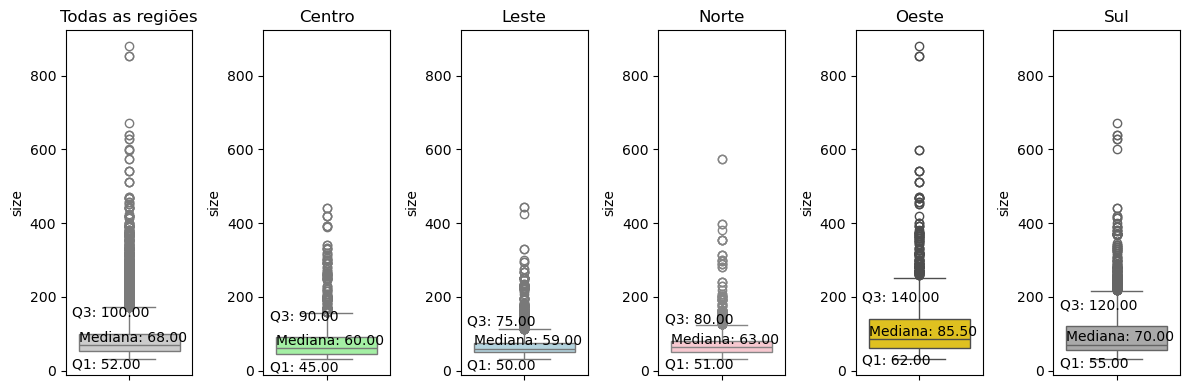

In [36]:
Box_Plot(data_treino = treino_base_aluguel['size'], data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro']['size'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste']['size'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte']['size'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste']['size'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul']['size'], nome_coluna = 'size')

/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


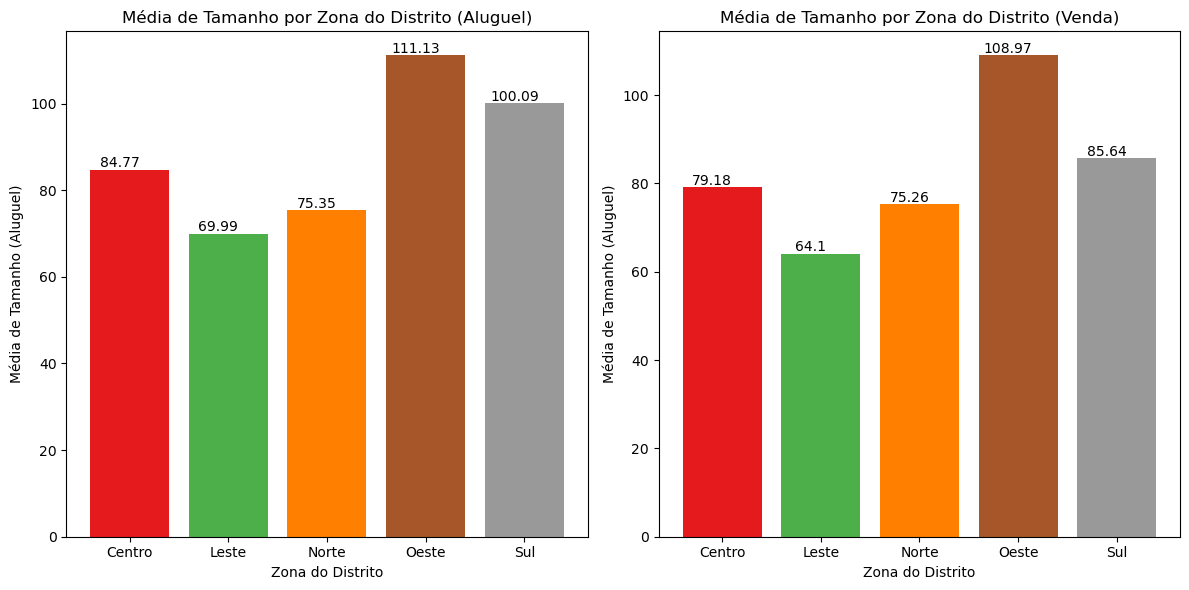

In [37]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'size', 'Tamanho')

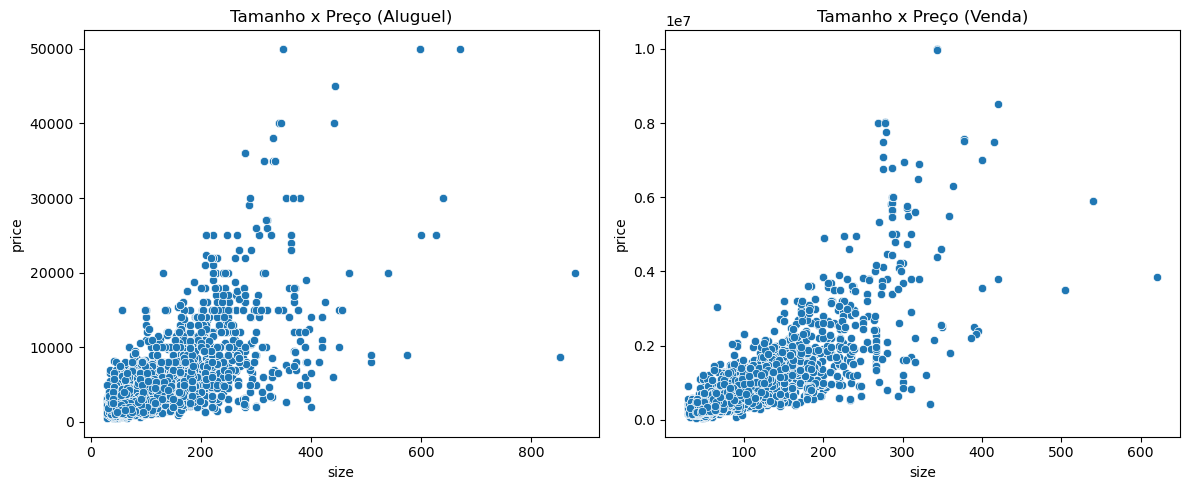

In [38]:
# Plotando a relação de Tamanho x Preço

# Criando a figura
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Primeiro gráfico: Base Aluguel
sns.scatterplot(x='size', y='price', data=treino_base_aluguel, ax=axes[0])
axes[0].set_title('Tamanho x Preço (Aluguel)')

# Segundo gráfico: Base Venda
sns.scatterplot(x='size', y='price', data=treino_base_venda, ax=axes[1])
axes[1].set_title('Tamanho x Preço (Venda)')

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()

# Exiba a figura
plt.show()

**Comentário:** Podemos ver que há uma relação direta entre o tamanho do imóvel e seu preço. Imóveis maiores, custam mais caro. O que já era esperado.

# 📊 1.04 Análise Exploratória - Rooms

Número de quartos

In [39]:
print("Análise - Rooms - Venda\n")
desc_rooms_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'rooms')
desc_rooms_venda

Análise - Rooms - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               2.32     1.95     2.25     2.42     2.60     2.43
std                0.72     0.83     0.58     0.61     0.83     0.71
min                1.00     1.00     1.00     1.00     1.00     1.00
25%                2.00     1.00     2.00     2.00     2.00     2.00
50%                2.00     2.00     2.00     2.00     3.00     2.00
75%                3.00     3.00     3.00     3.00     3.00     3.00
max                6.00     4.00     5.00     5.00     6.00     5.00

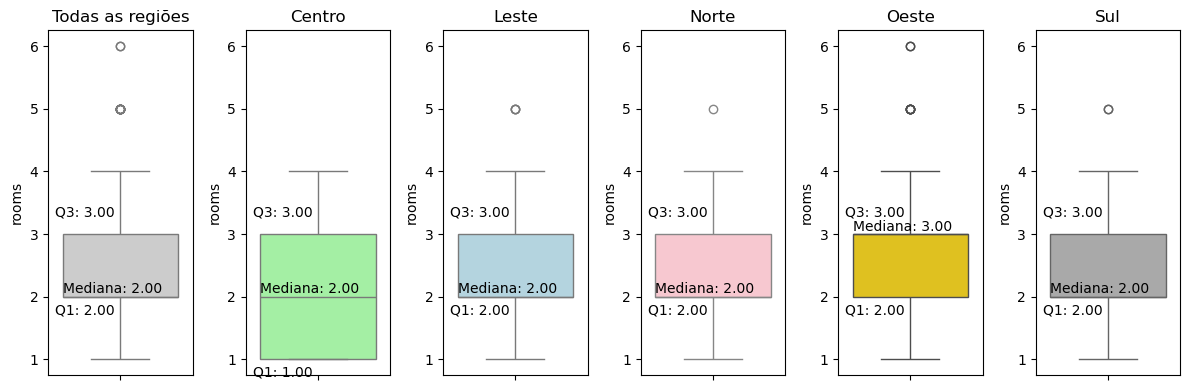

In [40]:
Box_Plot(data_treino = treino_base_venda['rooms'], data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro']['rooms'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste']['rooms'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte']['rooms'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste']['rooms'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul']['rooms'], nome_coluna = 'rooms')

In [41]:
print("Análise - Rooms - aluguel\n")
desc_rooms_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'rooms')
desc_rooms_aluguel

Análise - Rooms - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean               2.31     1.86     2.23     2.26     2.46     2.44
std                0.83     0.88     0.64     0.72     0.87     0.92
min                1.00     1.00     1.00     1.00     1.00     1.00
25%                2.00     1.00     2.00     2.00     2.00     2.00
50%                2.00     2.00     2.00     2.00     2.00     2.00
75%                3.00     3.00     3.00     3.00     3.00     3.00
max               10.00     4.00     5.00     5.00     7.00    10.00

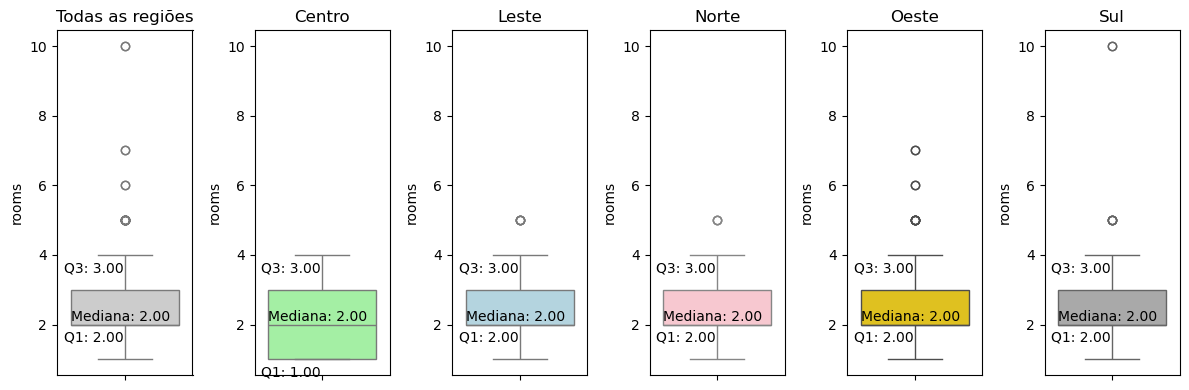

In [42]:
Box_Plot(data_treino = treino_base_aluguel['rooms'], data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro']['rooms'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste']['rooms'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte']['rooms'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste']['rooms'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul']['rooms'], nome_coluna = 'rooms')

/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


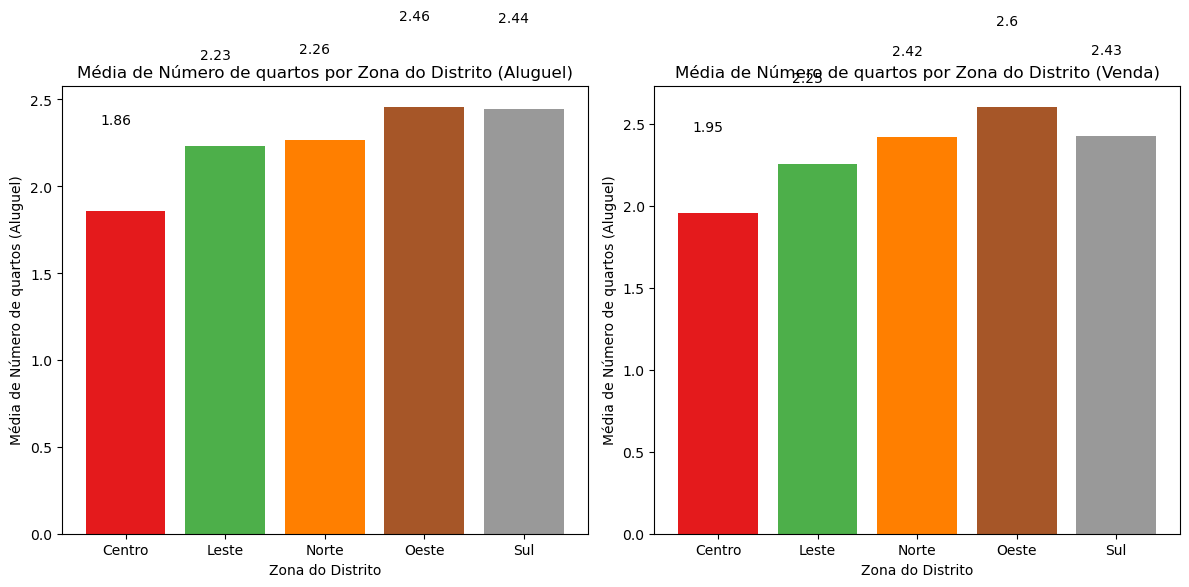

In [43]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'rooms', 'Número de quartos')

# 📊 1.05 Análise Exploratória - Toilets

Número de banheiros

In [44]:
print("Análise - Toilets - Venda\n")
desc_toilets_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'toilets')
desc_toilets_venda

Análise - Toilets - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste     Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.0
mean               2.04     1.74     1.81     2.07     2.52     2.3
std                0.91     0.73     0.72     0.80     1.17     1.0
min                1.00     1.00     1.00     1.00     1.00     1.0
25%                2.00     1.00     1.00     2.00     2.00     2.0
50%                2.00     2.00     2.00     2.00     2.00     2.0
75%                2.00     2.00     2.00     2.00     3.00     2.0
max                7.00     6.00     7.00     6.00     7.00     6.0

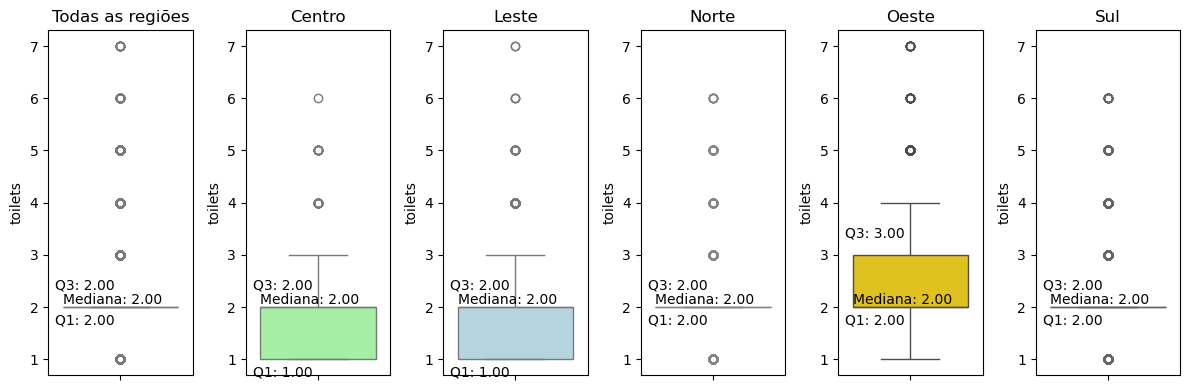

In [45]:
Box_Plot(data_treino = treino_base_venda['toilets'], data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro']['toilets'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste']['toilets'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte']['toilets'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste']['toilets'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul']['toilets'], nome_coluna = 'toilets')

In [46]:
print("Análise - Toilets - aluguel\n")
desc_toilets_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'toilets')
desc_toilets_aluguel

Análise - Toilets - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean               2.11     1.74     1.88     1.89     2.41     2.35
std                1.00     0.84     0.66     0.83     1.14     1.15
min                1.00     1.00     1.00     1.00     1.00     1.00
25%                2.00     1.00     2.00     1.00     2.00     2.00
50%                2.00     2.00     2.00     2.00     2.00     2.00
75%                2.00     2.00     2.00     2.00     3.00     3.00
max                8.00     7.00     6.00     8.00     8.00     7.00

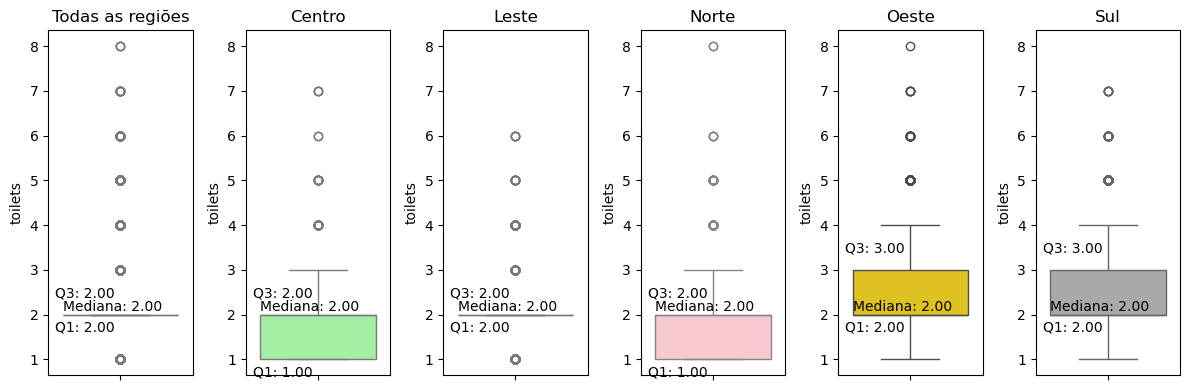

In [47]:
Box_Plot(data_treino = treino_base_aluguel['toilets'], data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro']['toilets'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste']['toilets'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte']['toilets'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste']['toilets'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul']['toilets'], nome_coluna = 'toilets')

/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


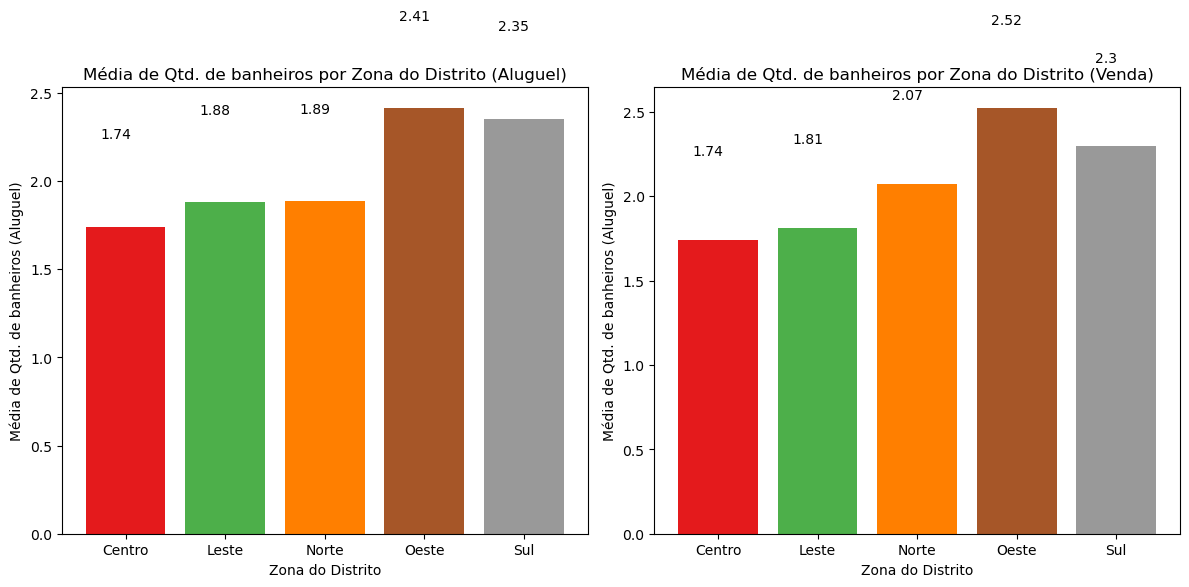

In [48]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'toilets', 'Qtd. de banheiros')

**Comentários:** Vemos que a média nas regiões centro, leste e norte estão bem próximas de 2 banheiros, mas na zona Oeste e Sul, a média está mais próximo de 3. Como a média de quartos é maior nessa região, é de se esperar que o número de banheiros também seja para comportar os moradores.

# 📊 1.06 Análise Exploratória - Suites

Número de quartos com banheiro privativo

In [49]:
print("Análise - Suites - Venda\n")
desc_suites_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'suites')
desc_suites_venda

Análise - Suites - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               0.93     0.64     0.76     0.99     1.28     1.15
std                0.77     0.61     0.64     0.68     0.93     0.85
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                1.00     0.00     0.00     1.00     1.00     1.00
50%                1.00     1.00     1.00     1.00     1.00     1.00
75%                1.00     1.00     1.00     1.00     1.00     1.00
max                6.00     4.00     4.00     4.00     6.00     4.00

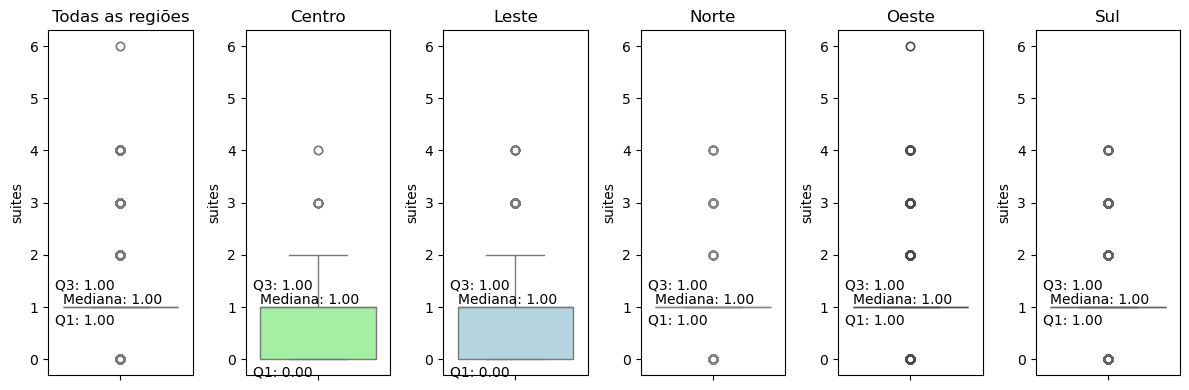

In [50]:
Box_Plot(data_treino = treino_base_venda['suites'], data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro']['suites'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste']['suites'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte']['suites'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste']['suites'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul']['suites'], nome_coluna = 'suites')

In [51]:
print("Análise - Suites - aluguel\n")
desc_suites_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'suites')
desc_suites_aluguel

Análise - Suites - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean               1.03     0.67     0.86     0.82     1.26     1.26
std                0.89     0.73     0.62     0.70     1.00     1.02
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                1.00     0.00     1.00     0.00     1.00     1.00
50%                1.00     1.00     1.00     1.00     1.00     1.00
75%                1.00     1.00     1.00     1.00     1.00     1.00
max                5.00     4.00     5.00     4.00     5.00     5.00

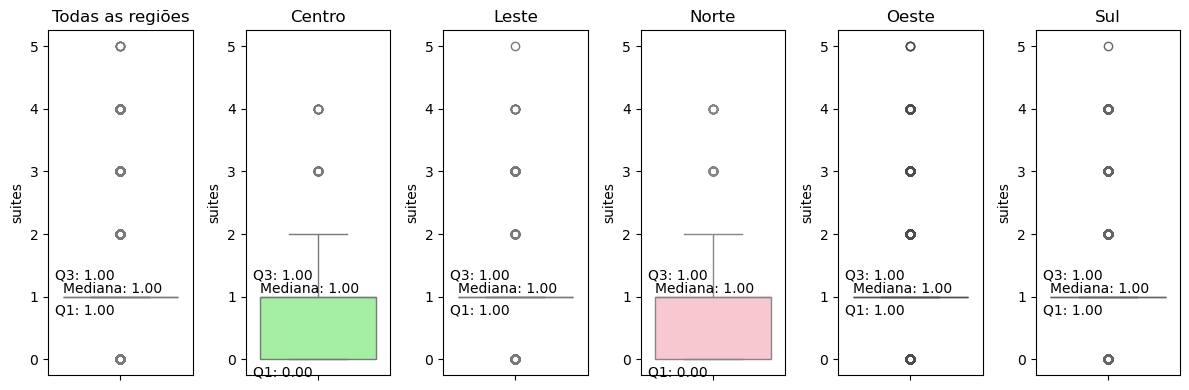

In [52]:

Box_Plot(data_treino = treino_base_aluguel['suites'], data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro']['suites'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste']['suites'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte']['suites'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste']['suites'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul']['suites'], nome_coluna = 'suites')


/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


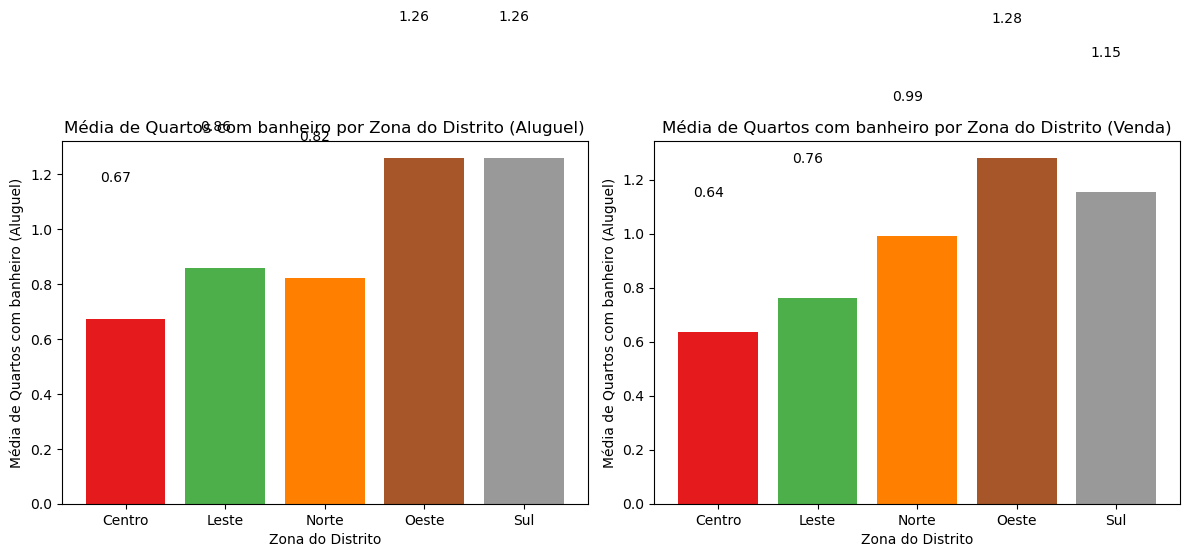

In [53]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'suites', 'Quartos com banheiro')

**Comentários:** Podemos notar que nas regiões Centro, Leste e norte, a maioria dos imóveis não possui suites, visto que a média está abaixo de 1

# 📊 1.07 Análise Exploratória - Parking

Número de vagas de estacionamento

In [54]:
print("Análise - Parking - Venda\n")
desc_parking_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'parking')
desc_parking_venda

Análise - Parking - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               1.33     0.96     1.19     1.42     1.70     1.52
std                0.76     0.58     0.57     0.71     0.96     0.84
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                1.00     1.00     1.00     1.00     1.00     1.00
50%                1.00     1.00     1.00     1.00     1.00     1.00
75%                2.00     1.00     1.00     2.00     2.00     2.00
max                7.00     4.00     6.00     6.00     7.00     5.00

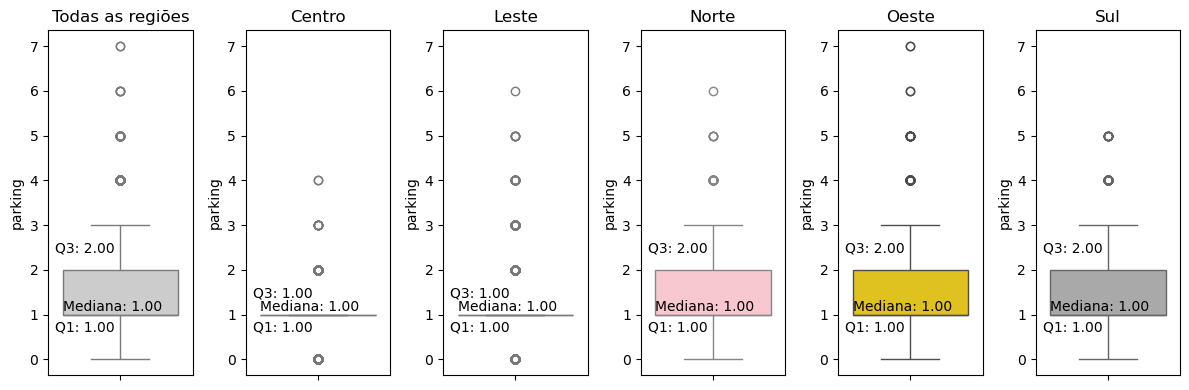

In [55]:
Box_Plot(data_treino = treino_base_venda['parking'], data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro']['parking'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste']['parking'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte']['parking'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste']['parking'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul']['parking'], nome_coluna = 'parking')

In [56]:
print("Análise - Parking - aluguel\n")
desc_parking_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'parking')
desc_parking_aluguel

Análise - Parking - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean               1.45     1.10     1.21     1.29     1.75     1.65
std                0.89     0.78     0.63     0.73     0.97     1.01
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                1.00     1.00     1.00     1.00     1.00     1.00
50%                1.00     1.00     1.00     1.00     2.00     1.00
75%                2.00     1.00     1.00     2.00     2.00     2.00
max                9.00     6.00     7.00     5.00     7.00     9.00

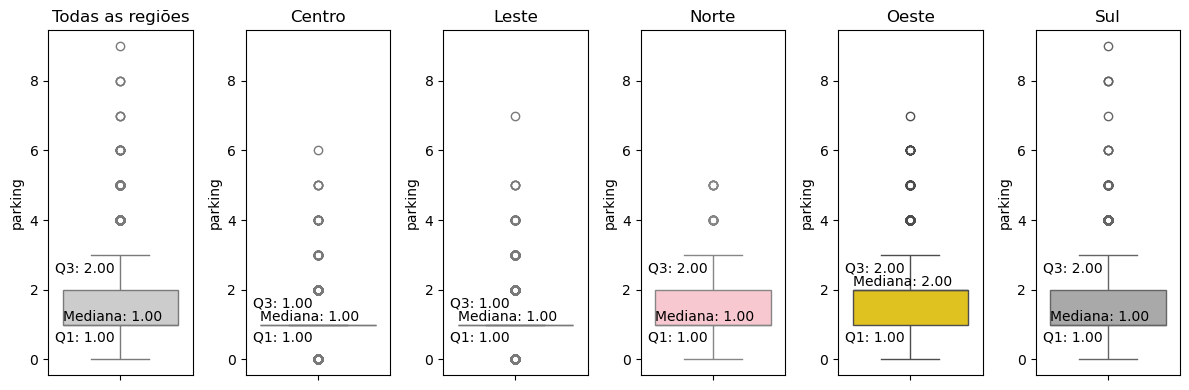

In [57]:
Box_Plot(data_treino = treino_base_aluguel['parking'], data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro']['parking'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste']['parking'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte']['parking'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste']['parking'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul']['parking'], nome_coluna = 'parking')

/tmp/ipykernel_19394/3799473616.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_a = plt.cm.get_cmap('Set1',len(zones_base_a))
/tmp/ipykernel_19394/3799473616.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_base_b = plt.cm.get_cmap('Set1', len(zones_base_b))


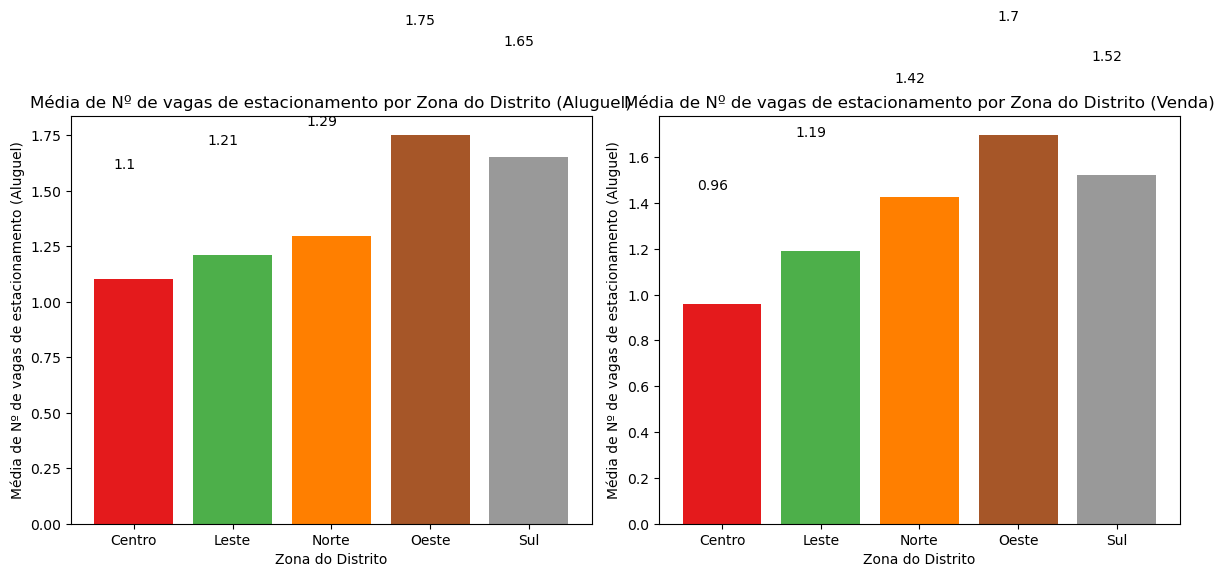

In [58]:
Distribuicao(treino_base_aluguel, treino_base_venda, "Aluguel", "Venda", 'parking', 'Nº de vagas de estacionamento')

**Comentários:** Em imóveis maiores, com mais quartos, o número de moradores tende a ser maior, logo é de se esperar a necessidade de mais vagas de estacionamento para imóveis maiores. Vemos que as regiões Oeste e Sul, por possuirem imóveis maiores, também tem uma oferta maior de imóveis com mais vagas, como esperado.

# 📊 1.08 Análise Exploratória - Elevator

Valor binário: 1 se houver elevador no prédio, 0 caso contrário

In [59]:
print("Análise - Elevator - Venda\n")
desc_elevator_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'elevator')
desc_elevator_venda

Análise - Elevator - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               0.41     0.38     0.35     0.45     0.55     0.43
std                0.49     0.49     0.48     0.50     0.50     0.50
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                0.00     0.00     0.00     0.00     0.00     0.00
50%                0.00     0.00     0.00     0.00     1.00     0.00
75%                1.00     1.00     1.00     1.00     1.00     1.00
max                1.00     1.00     1.00     1.00     1.00     1.00

In [60]:
treino_base_venda.groupby(['district_zone', 'elevator']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  elevator  Qtd.
0        Centro         0   876
1        Centro         1   544
2         Leste         0  2362
3         Leste         1  1254
4         Norte         0   892
5         Norte         1   732
6         Oeste         0   660
7         Oeste         1   797
8           Sul         0  1113
9           Sul         1   851

In [61]:
print("Análise - Elevator - aluguel\n")
desc_elevator_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'elevator')
desc_elevator_aluguel

Análise - Elevator - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean               0.30     0.30     0.29     0.25     0.32     0.34
std                0.46     0.46     0.45     0.43     0.47     0.47
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                0.00     0.00     0.00     0.00     0.00     0.00
50%                0.00     0.00     0.00     0.00     0.00     0.00
75%                1.00     1.00     1.00     0.00     1.00     1.00
max                1.00     1.00     1.00     1.00     1.00     1.00

In [62]:
treino_base_aluguel.groupby(['district_zone', 'elevator']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  elevator  Qtd.
0        Centro         0   798
1        Centro         1   342
2         Leste         0  2025
3         Leste         1   837
4         Norte         0  1283
5         Norte         1   419
6         Oeste         0  1895
7         Oeste         1   885
8           Sul         0  1818
9           Sul         1   926

**Comentário:** Como o atributo Elevator é binário, um histograma não nos tratará informações sobre o comportamento dos dados.
Plotaremos um gráfico de barras empilhadas para analisar o comportamento e retirar insights.

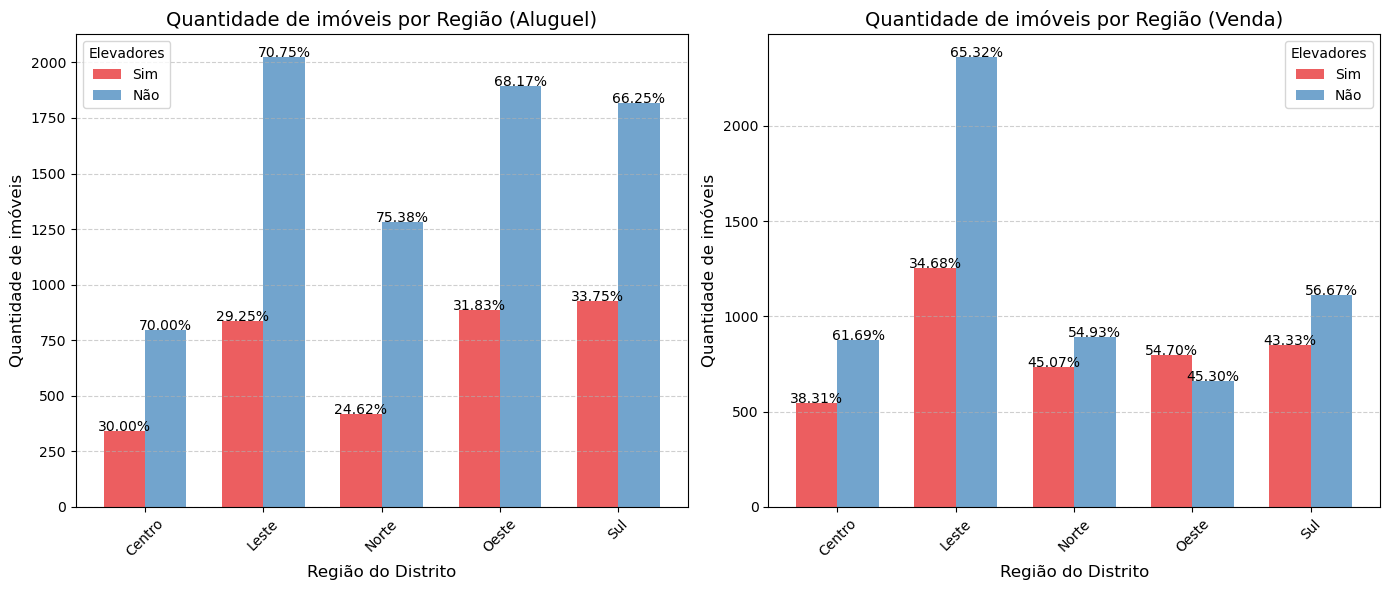

In [63]:
# Títulos para os gráficos
titulos = ['Aluguel', 'Venda']
bases = [treino_base_aluguel, treino_base_venda]
feature = 'elevator'
rotulo = 'Elevadores'

GraficoBarrasLadoALado(bases, titulos, feature, rotulo)


**Comentário:** Podemos observar que mesmo em regiões mais caras, a maioria dos imóveis não possui elevador. Essa informação surpreendeu. É de se esperar que em imóveis mais caros, por se tratar de apartamentos, deva ter elevador.

Uma suposição para essa ausência de elevadores é uma quantidade pequena de andares no imóvel (inferior a 4 andares), o que explicaria esse comportamento.

# 📊 1.09 Análise Exploratória - Furnished

Valor binário: 1 se a propriedade estiver mobiliada, 0 caso contrário

In [64]:
print("Análise - Furnished - Venda\n")
desc_furnished_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'furnished')
desc_furnished_venda

Análise - Furnished - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               0.12     0.14     0.11     0.15     0.12     0.11
std                0.32     0.34     0.31     0.35     0.32     0.31
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                0.00     0.00     0.00     0.00     0.00     0.00
50%                0.00     0.00     0.00     0.00     0.00     0.00
75%                0.00     0.00     0.00     0.00     0.00     0.00
max                1.00     1.00     1.00     1.00     1.00     1.00

In [65]:
treino_base_venda.groupby(['district_zone', 'furnished']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  furnished  Qtd.
0        Centro          0  1228
1        Centro          1   192
2         Leste          0  3236
3         Leste          1   380
4         Norte          0  1386
5         Norte          1   238
6         Oeste          0  1285
7         Oeste          1   172
8           Sul          0  1746
9           Sul          1   218

In [66]:
print("Análise - Furnished - aluguel\n")
desc_furnished_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'furnished')
desc_furnished_aluguel

Análise - Furnished - aluguel



Todas as Regiões  Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.0  2862.00  1702.00  2780.00  2744.00
mean               0.17     0.2     0.11     0.12     0.23     0.21
std                0.38     0.4     0.32     0.32     0.42     0.41
min                0.00     0.0     0.00     0.00     0.00     0.00
25%                0.00     0.0     0.00     0.00     0.00     0.00
50%                0.00     0.0     0.00     0.00     0.00     0.00
75%                0.00     0.0     0.00     0.00     0.00     0.00
max                1.00     1.0     1.00     1.00     1.00     1.00

In [67]:
treino_base_aluguel.groupby(['district_zone', 'furnished']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  furnished  Qtd.
0        Centro          0   916
1        Centro          1   224
2         Leste          0  2542
3         Leste          1   320
4         Norte          0  1506
5         Norte          1   196
6         Oeste          0  2148
7         Oeste          1   632
8           Sul          0  2156
9           Sul          1   588

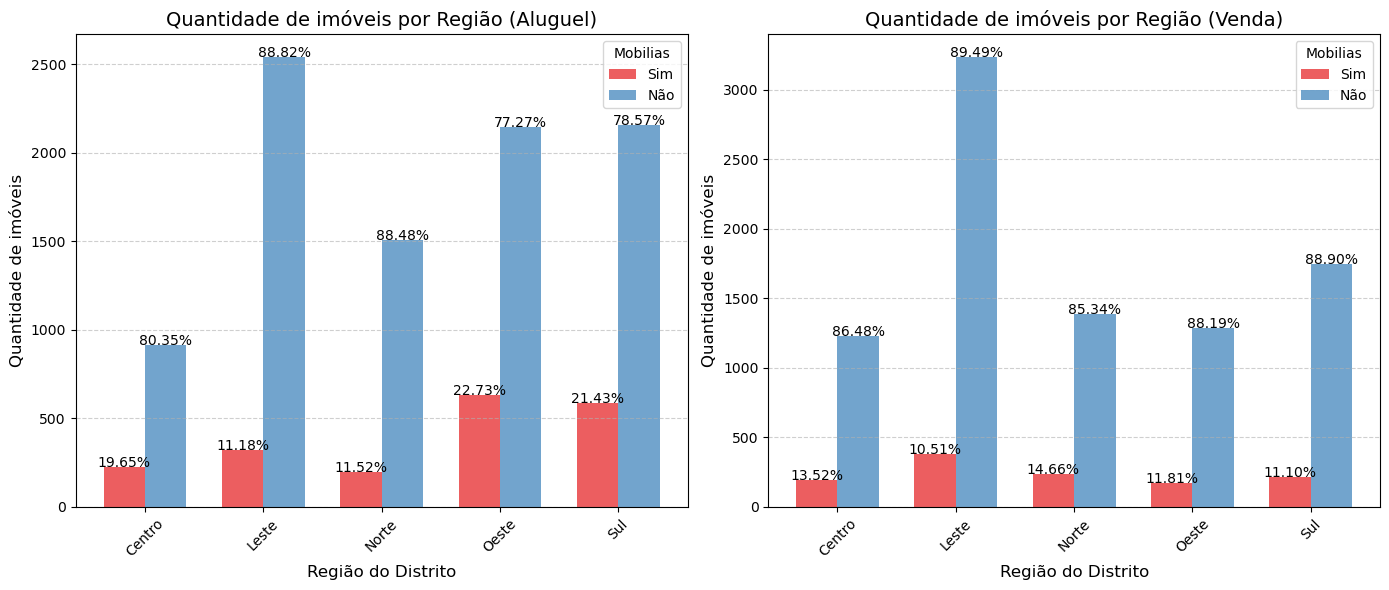

In [68]:
# Títulos para os gráficos
titulos = ['Aluguel', 'Venda']
bases = [treino_base_aluguel, treino_base_venda]
feature = 'furnished'
rotulo = 'Mobilias'

GraficoBarrasLadoALado(bases, titulos, feature, rotulo)

**Comentário:** Em todas as regiões vemos que mais de 77% delas não está mobiliada. Esse comportamento era esperado.

# 📊 1.10 Análise Exploratória - Swimming Pool


Valor binário: 1 se a propriedade tiver piscina, 0 caso contrário

In [69]:
print("Análise - Swimming Pool - Venda\n")
desc_pool_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'swimming_pool')
desc_pool_venda

Análise - Swimming Pool - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               0.54     0.39     0.47     0.68     0.65     0.60
std                0.50     0.49     0.50     0.47     0.48     0.49
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                0.00     0.00     0.00     0.00     0.00     0.00
50%                1.00     0.00     0.00     1.00     1.00     1.00
75%                1.00     1.00     1.00     1.00     1.00     1.00
max                1.00     1.00     1.00     1.00     1.00     1.00

In [70]:
treino_base_venda.groupby(['district_zone', 'swimming_pool']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  swimming_pool  Qtd.
0        Centro              0   865
1        Centro              1   555
2         Leste              0  1932
3         Leste              1  1684
4         Norte              0   523
5         Norte              1  1101
6         Oeste              0   515
7         Oeste              1   942
8           Sul              0   783
9           Sul              1  1181

In [71]:
print("Análise - Swimming Pool - aluguel\n")
desc_pool_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'swimming_pool')
desc_pool_aluguel

Análise - Swimming Pool - aluguel



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          11228.00  1140.00  2862.00  1702.00  2780.00  2744.00
mean               0.49     0.32     0.37     0.46     0.60     0.59
std                0.50     0.47     0.48     0.50     0.49     0.49
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                0.00     0.00     0.00     0.00     0.00     0.00
50%                0.00     0.00     0.00     0.00     1.00     1.00
75%                1.00     1.00     1.00     1.00     1.00     1.00
max                1.00     1.00     1.00     1.00     1.00     1.00

In [72]:
treino_base_aluguel.groupby(['district_zone', 'swimming_pool']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  swimming_pool  Qtd.
0        Centro              0   779
1        Centro              1   361
2         Leste              0  1796
3         Leste              1  1066
4         Norte              0   916
5         Norte              1   786
6         Oeste              0  1117
7         Oeste              1  1663
8           Sul              0  1112
9           Sul              1  1632

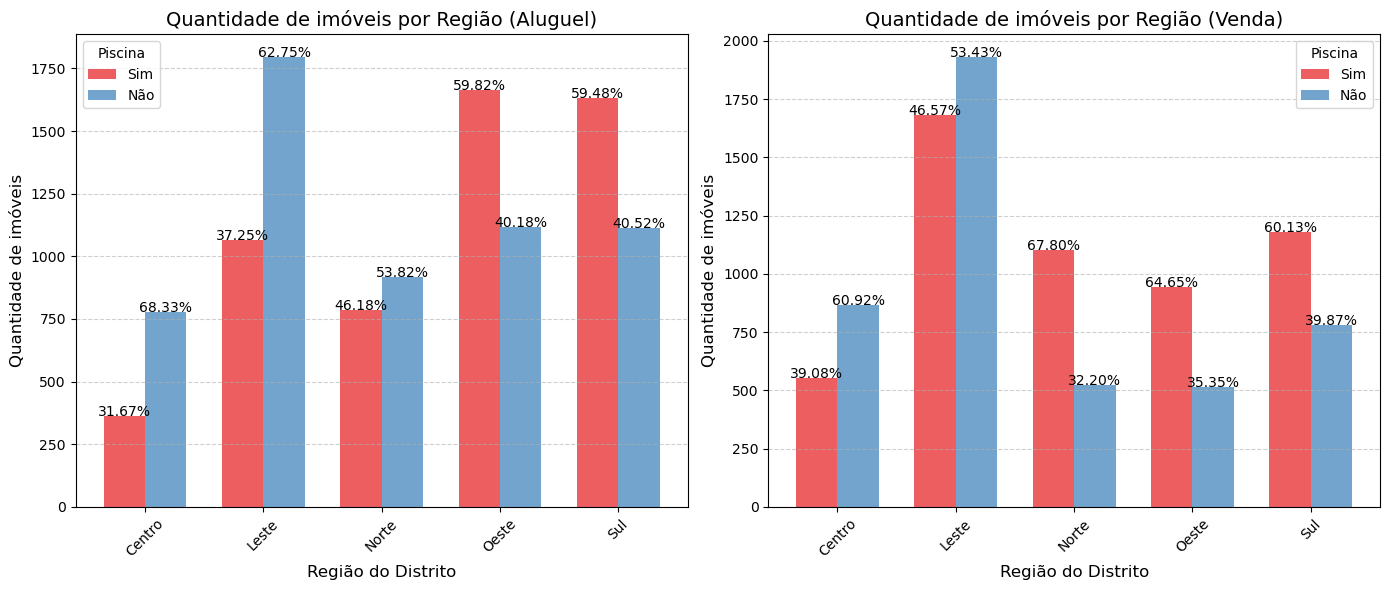

In [73]:
# Títulos para os gráficos
titulos = ['Aluguel', 'Venda']
bases = [treino_base_aluguel, treino_base_venda]
feature = 'swimming_pool'
rotulo = 'Piscina'

GraficoBarrasLadoALado(bases, titulos, feature, rotulo)

**Comentário:** Notamos que para as regiões em que os preços dos aluguéis e venda são mais altos (Zona Oeste e Sul), o percentual de imóveis que possuem piscina são maiores que os que não possuem. O destaque foi para a região norte que possui mais de 70% das casas a venda com piscina

# 📊 1.11 Análise Exploratória - New

Valor binário: 1 se a propriedade for muito nova, 0 caso contrário

In [74]:
print("Análise - New - Venda\n")
desc_new_venda = analise_desc(data_treino = treino_base_venda, data_treino_0 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Centro'], data_treino_1 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Leste'], data_treino_2 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Norte'], data_treino_3 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Oeste'], data_treino_4 = treino_base_venda.loc[treino_base_venda['district_zone'] == 'Sul'],coluna = 'new')
desc_new_venda

Análise - New - Venda



Todas as Regiões   Centro    Leste    Norte    Oeste      Sul
count          10081.00  1420.00  3616.00  1624.00  1457.00  1964.00
mean               0.03     0.02     0.04     0.04     0.03     0.02
std                0.17     0.14     0.19     0.18     0.16     0.15
min                0.00     0.00     0.00     0.00     0.00     0.00
25%                0.00     0.00     0.00     0.00     0.00     0.00
50%                0.00     0.00     0.00     0.00     0.00     0.00
75%                0.00     0.00     0.00     0.00     0.00     0.00
max                1.00     1.00     1.00     1.00     1.00     1.00

In [75]:
treino_base_venda.groupby(['district_zone', 'new']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  new  Qtd.
0        Centro    0  1391
1        Centro    1    29
2         Leste    0  3476
3         Leste    1   140
4         Norte    0  1567
5         Norte    1    57
6         Oeste    0  1417
7         Oeste    1    40
8           Sul    0  1920
9           Sul    1    44

In [76]:
print("Análise - New - aluguel\n")
desc_new_aluguel = analise_desc(data_treino = treino_base_aluguel, data_treino_0 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Centro'], data_treino_1 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Leste'], data_treino_2 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Norte'], data_treino_3 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Oeste'], data_treino_4 = treino_base_aluguel.loc[treino_base_aluguel['district_zone'] == 'Sul'],coluna = 'new')
desc_new_aluguel

Análise - New - aluguel



Todas as Regiões  Centro    Leste    Norte   Oeste      Sul
count          11228.00  1140.0  2862.00  1702.00  2780.0  2744.00
mean               0.00     0.0     0.00     0.00     0.0     0.00
std                0.03     0.0     0.04     0.05     0.0     0.03
min                0.00     0.0     0.00     0.00     0.0     0.00
25%                0.00     0.0     0.00     0.00     0.0     0.00
50%                0.00     0.0     0.00     0.00     0.0     0.00
75%                0.00     0.0     0.00     0.00     0.0     0.00
max                1.00     0.0     1.00     1.00     0.0     1.00

In [77]:
treino_base_aluguel.groupby(['district_zone', 'new']).size().reset_index(name='Qtd.').sort_values('district_zone')

district_zone  new  Qtd.
0        Centro    0  1140
1         Leste    0  2858
2         Leste    1     4
3         Norte    0  1697
4         Norte    1     5
5         Oeste    0  2780
6           Sul    0  2742
7           Sul    1     2

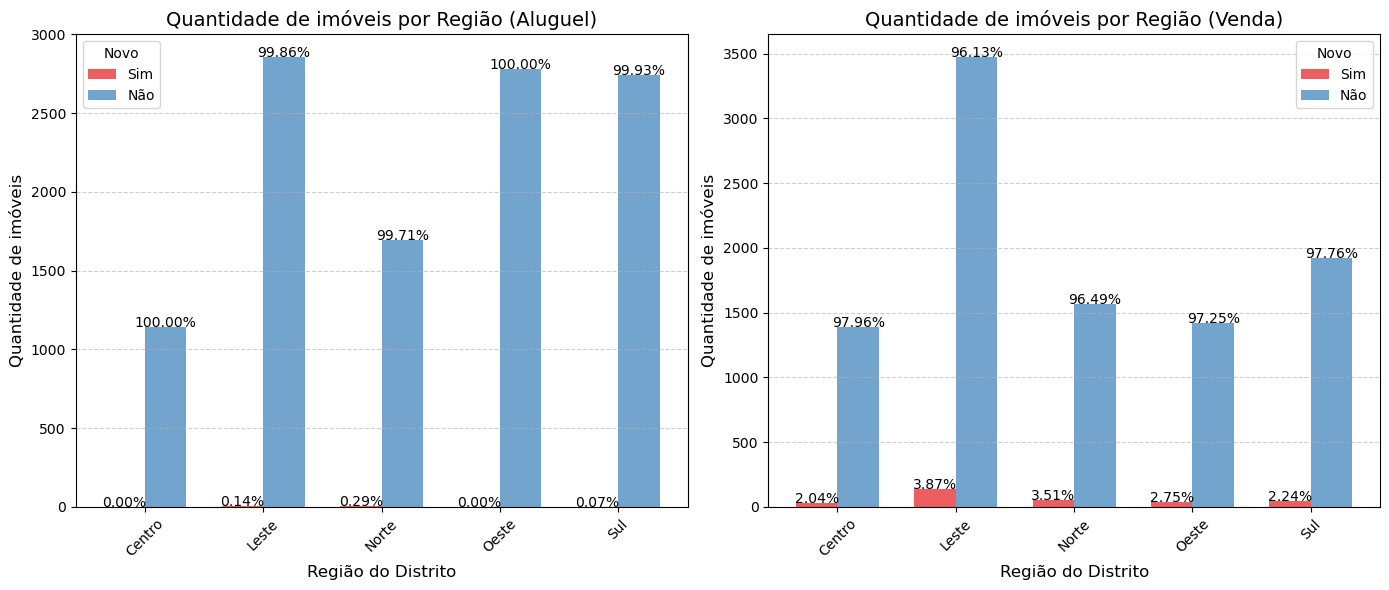

In [78]:
GraficoBarrasLadoALado([treino_base_aluguel, treino_base_venda], ['Aluguel', 'Venda'], 'new', 'Novo')

**Comentário:** Na base, a grande maioria dos imóveis não são novos. Pode ser que essa informação não seja interessante para o modelo visto que há concentração em um valor

In [79]:
treino_base_aluguel.columns

Index(['price', 'elevator', 'furnished', 'size', 'district_zone', 'toilets',
       'property_type', 'condo', 'swimming_pool', 'rooms', 'negotiation_type',
       'parking', 'suites', 'new'],
      dtype='object')

# 📊 2. Análise de Correlação

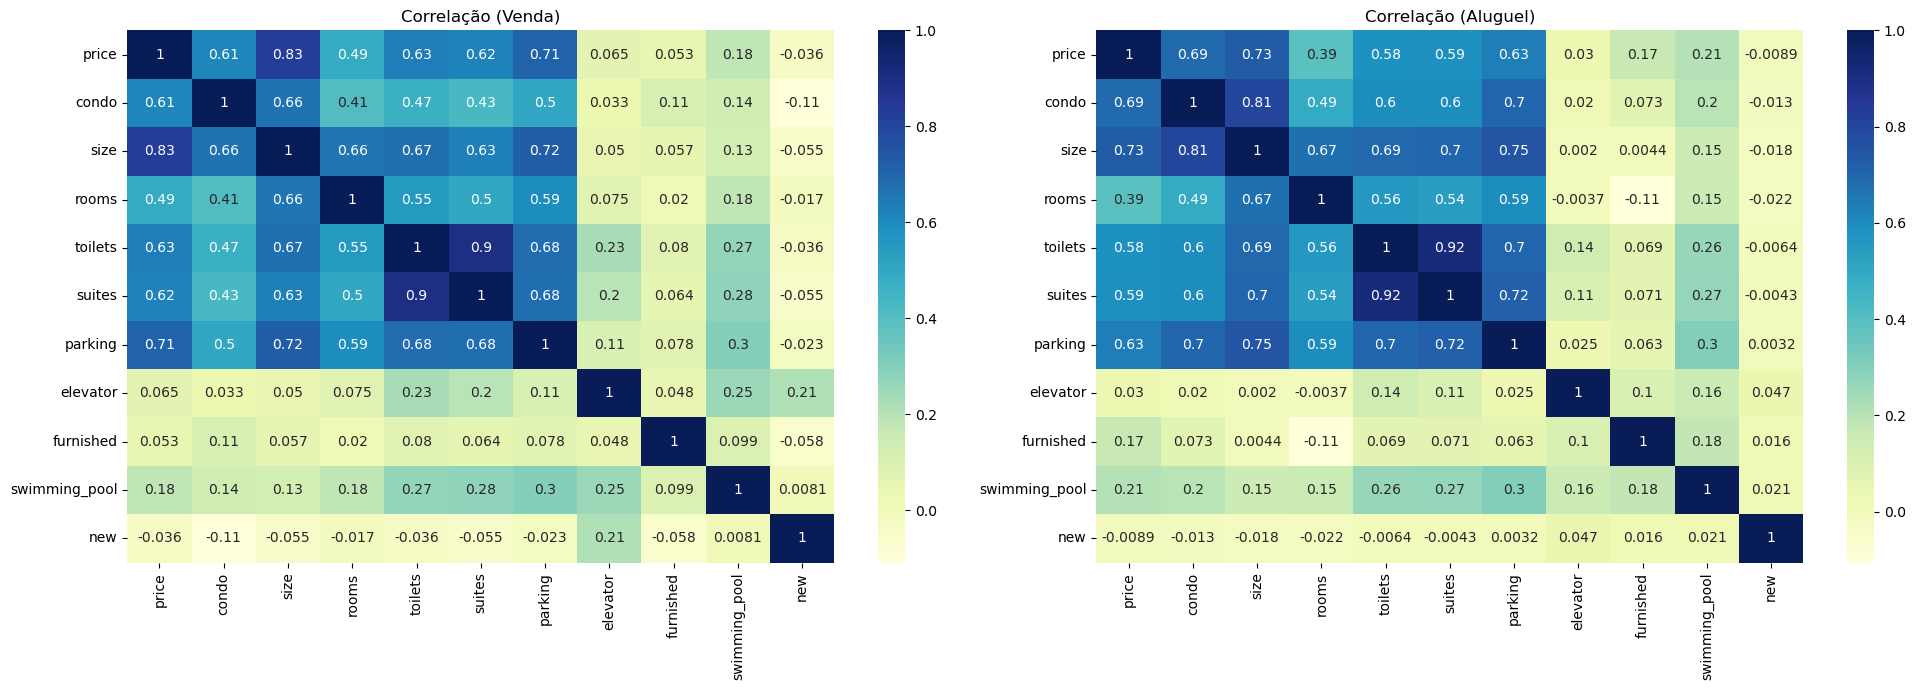

In [80]:
# Cria uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

colunas = ['price', 'condo', 'size', 'rooms', 'toilets', 'suites', 'parking', 'elevator', 'furnished', 'swimming_pool', 'new']

# Primeiro gráfico: Base de Aluguel
correlation_matrix_aluguel = treino_base_aluguel[colunas].corr()
sns.heatmap(correlation_matrix_aluguel, annot=True, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Correlação (Aluguel)')


# Segundo gráfico: Base de Venda
correlation_matrix_venda = treino_base_venda[colunas].corr()
sns.heatmap(correlation_matrix_venda, annot=True, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Correlação (Venda)')

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()

plt.show()

**Comentário:** Analisando a matriz da esquerda, vemos uma correlação alta entre preço e tamanho, do número de banheiros e quantidade de suites, tamanho e quantidade de vagas

# 📊 3. Pairplot - Base Venda

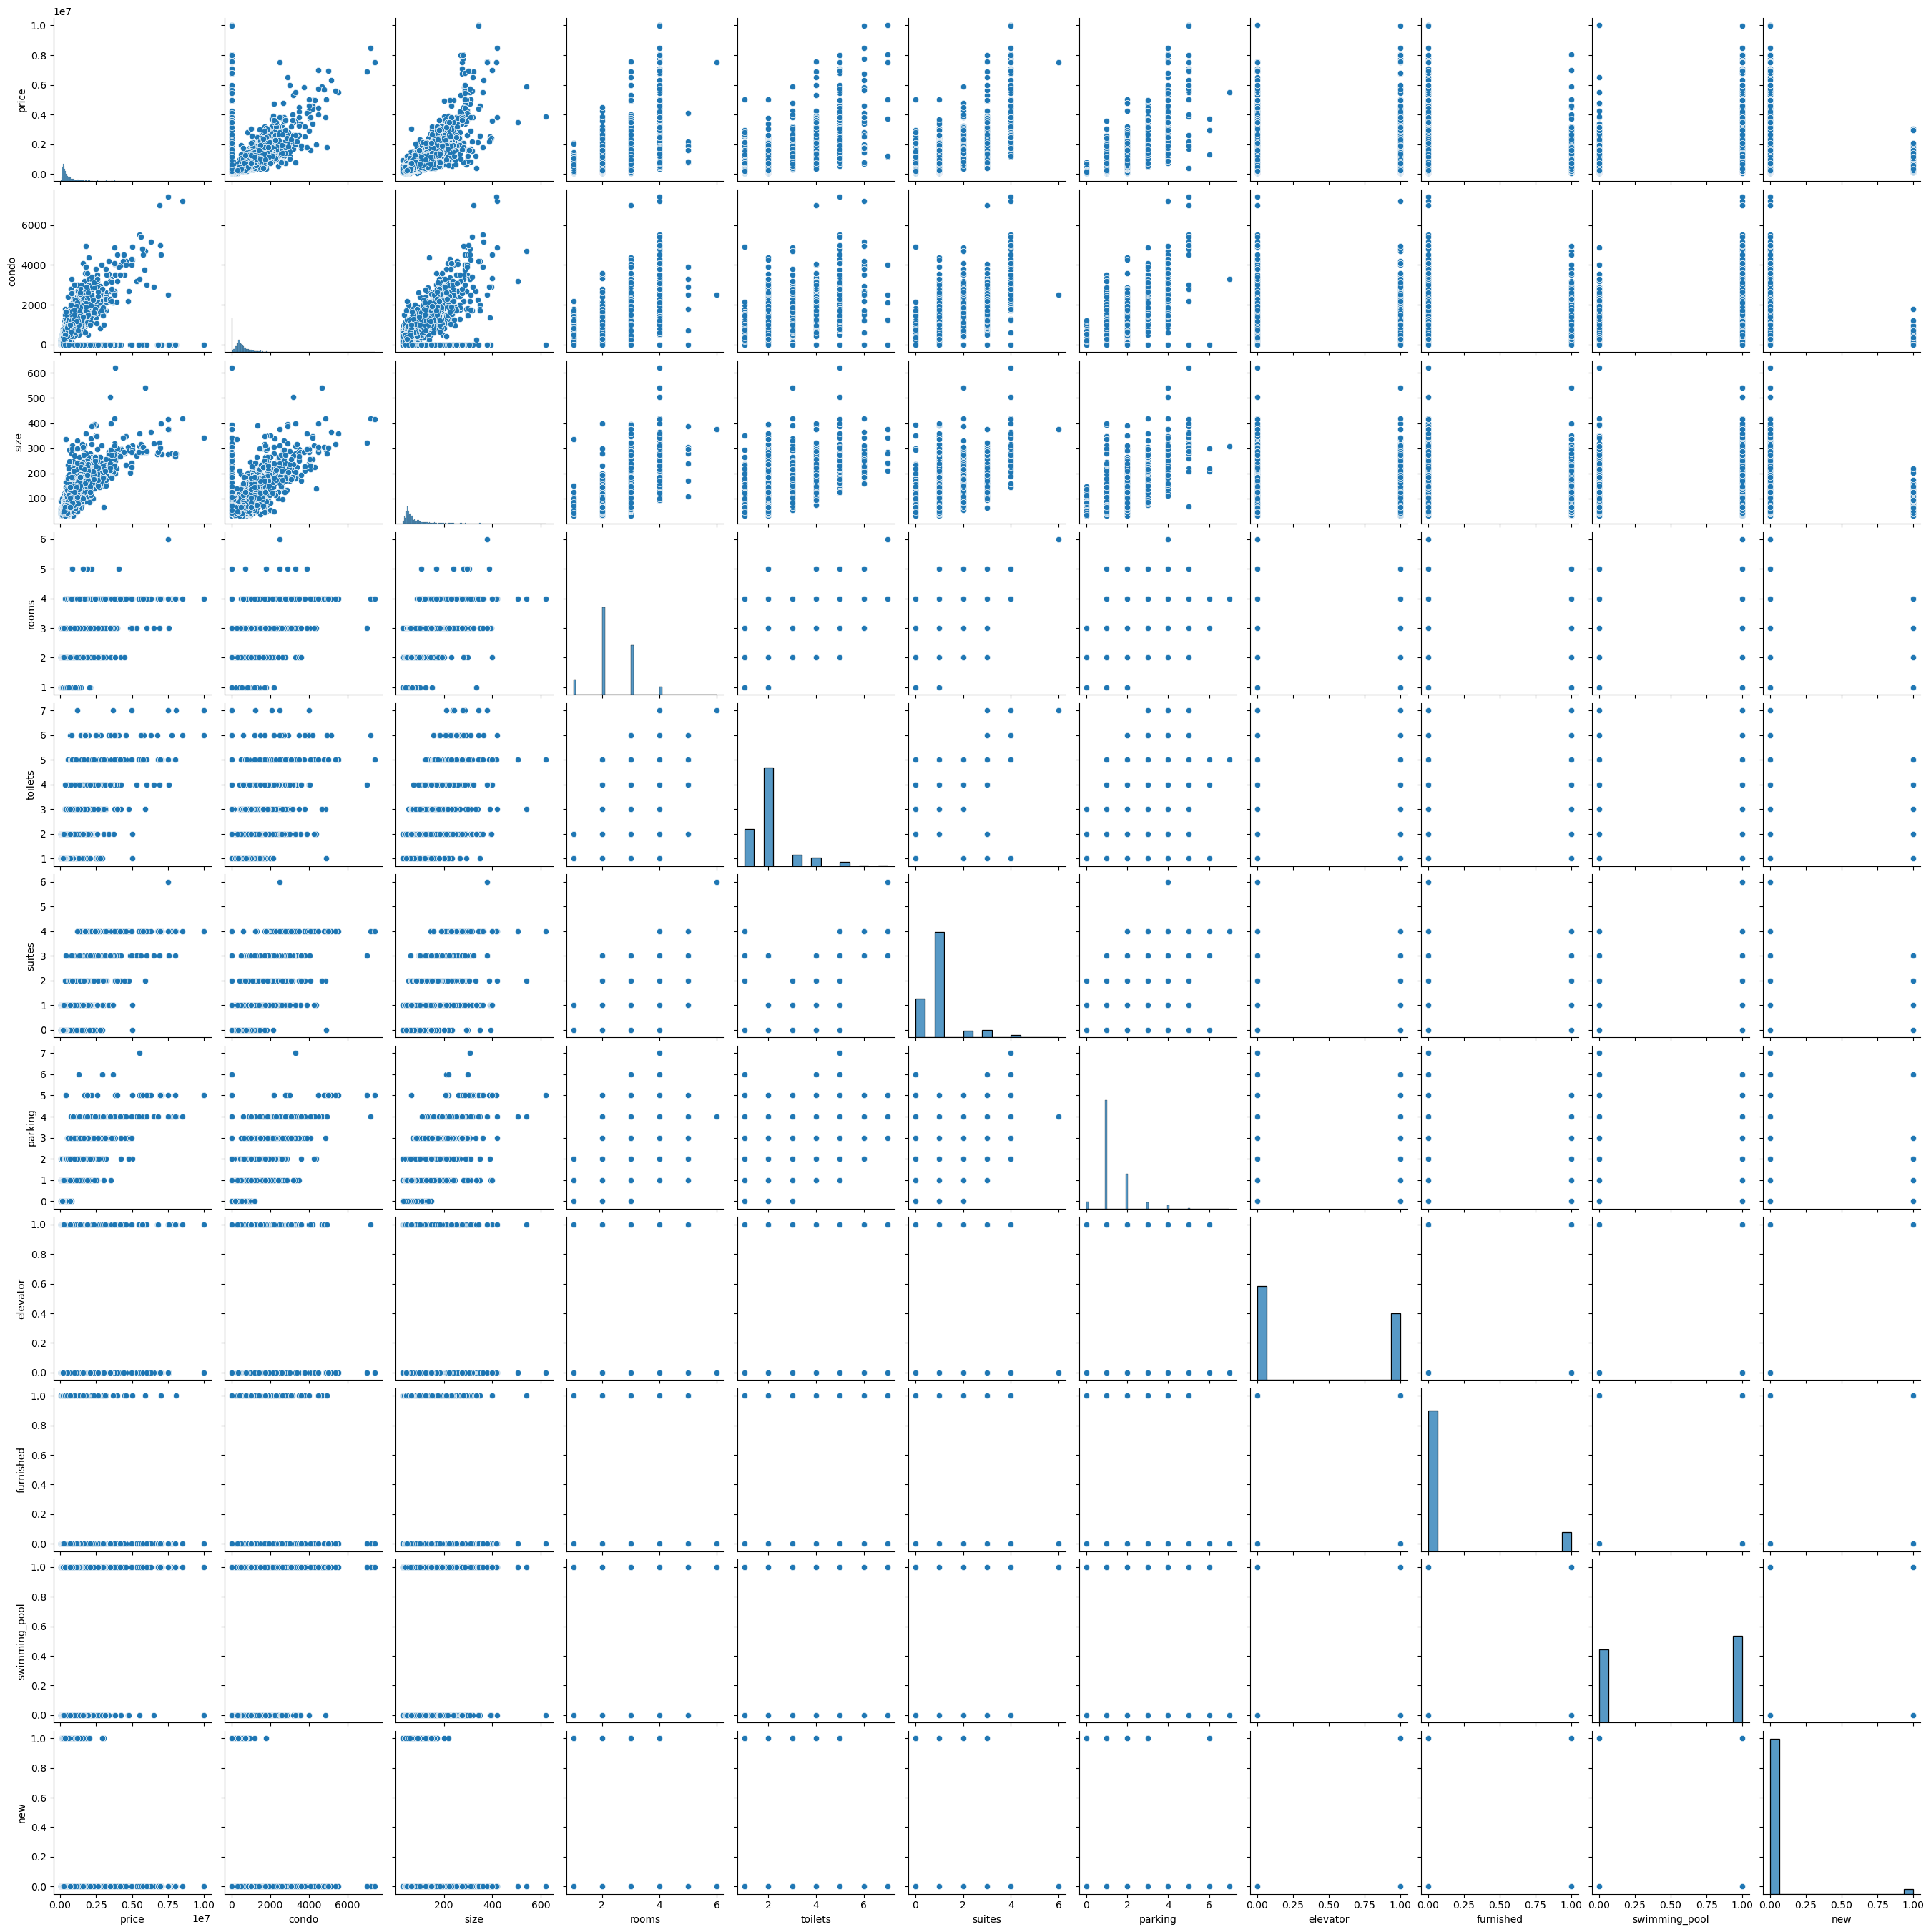

In [81]:
# Fazendo um pairplot entre as variáveis do dataframe.

sns.pairplot(treino_base_venda[['price', 'condo', 'size', 'rooms', 'toilets', 'suites', 'parking', 'elevator', 'furnished', 'swimming_pool', 'new', 'district_zone']], aspect=1)

# 📊 4. Pairplot - Base Aluguel

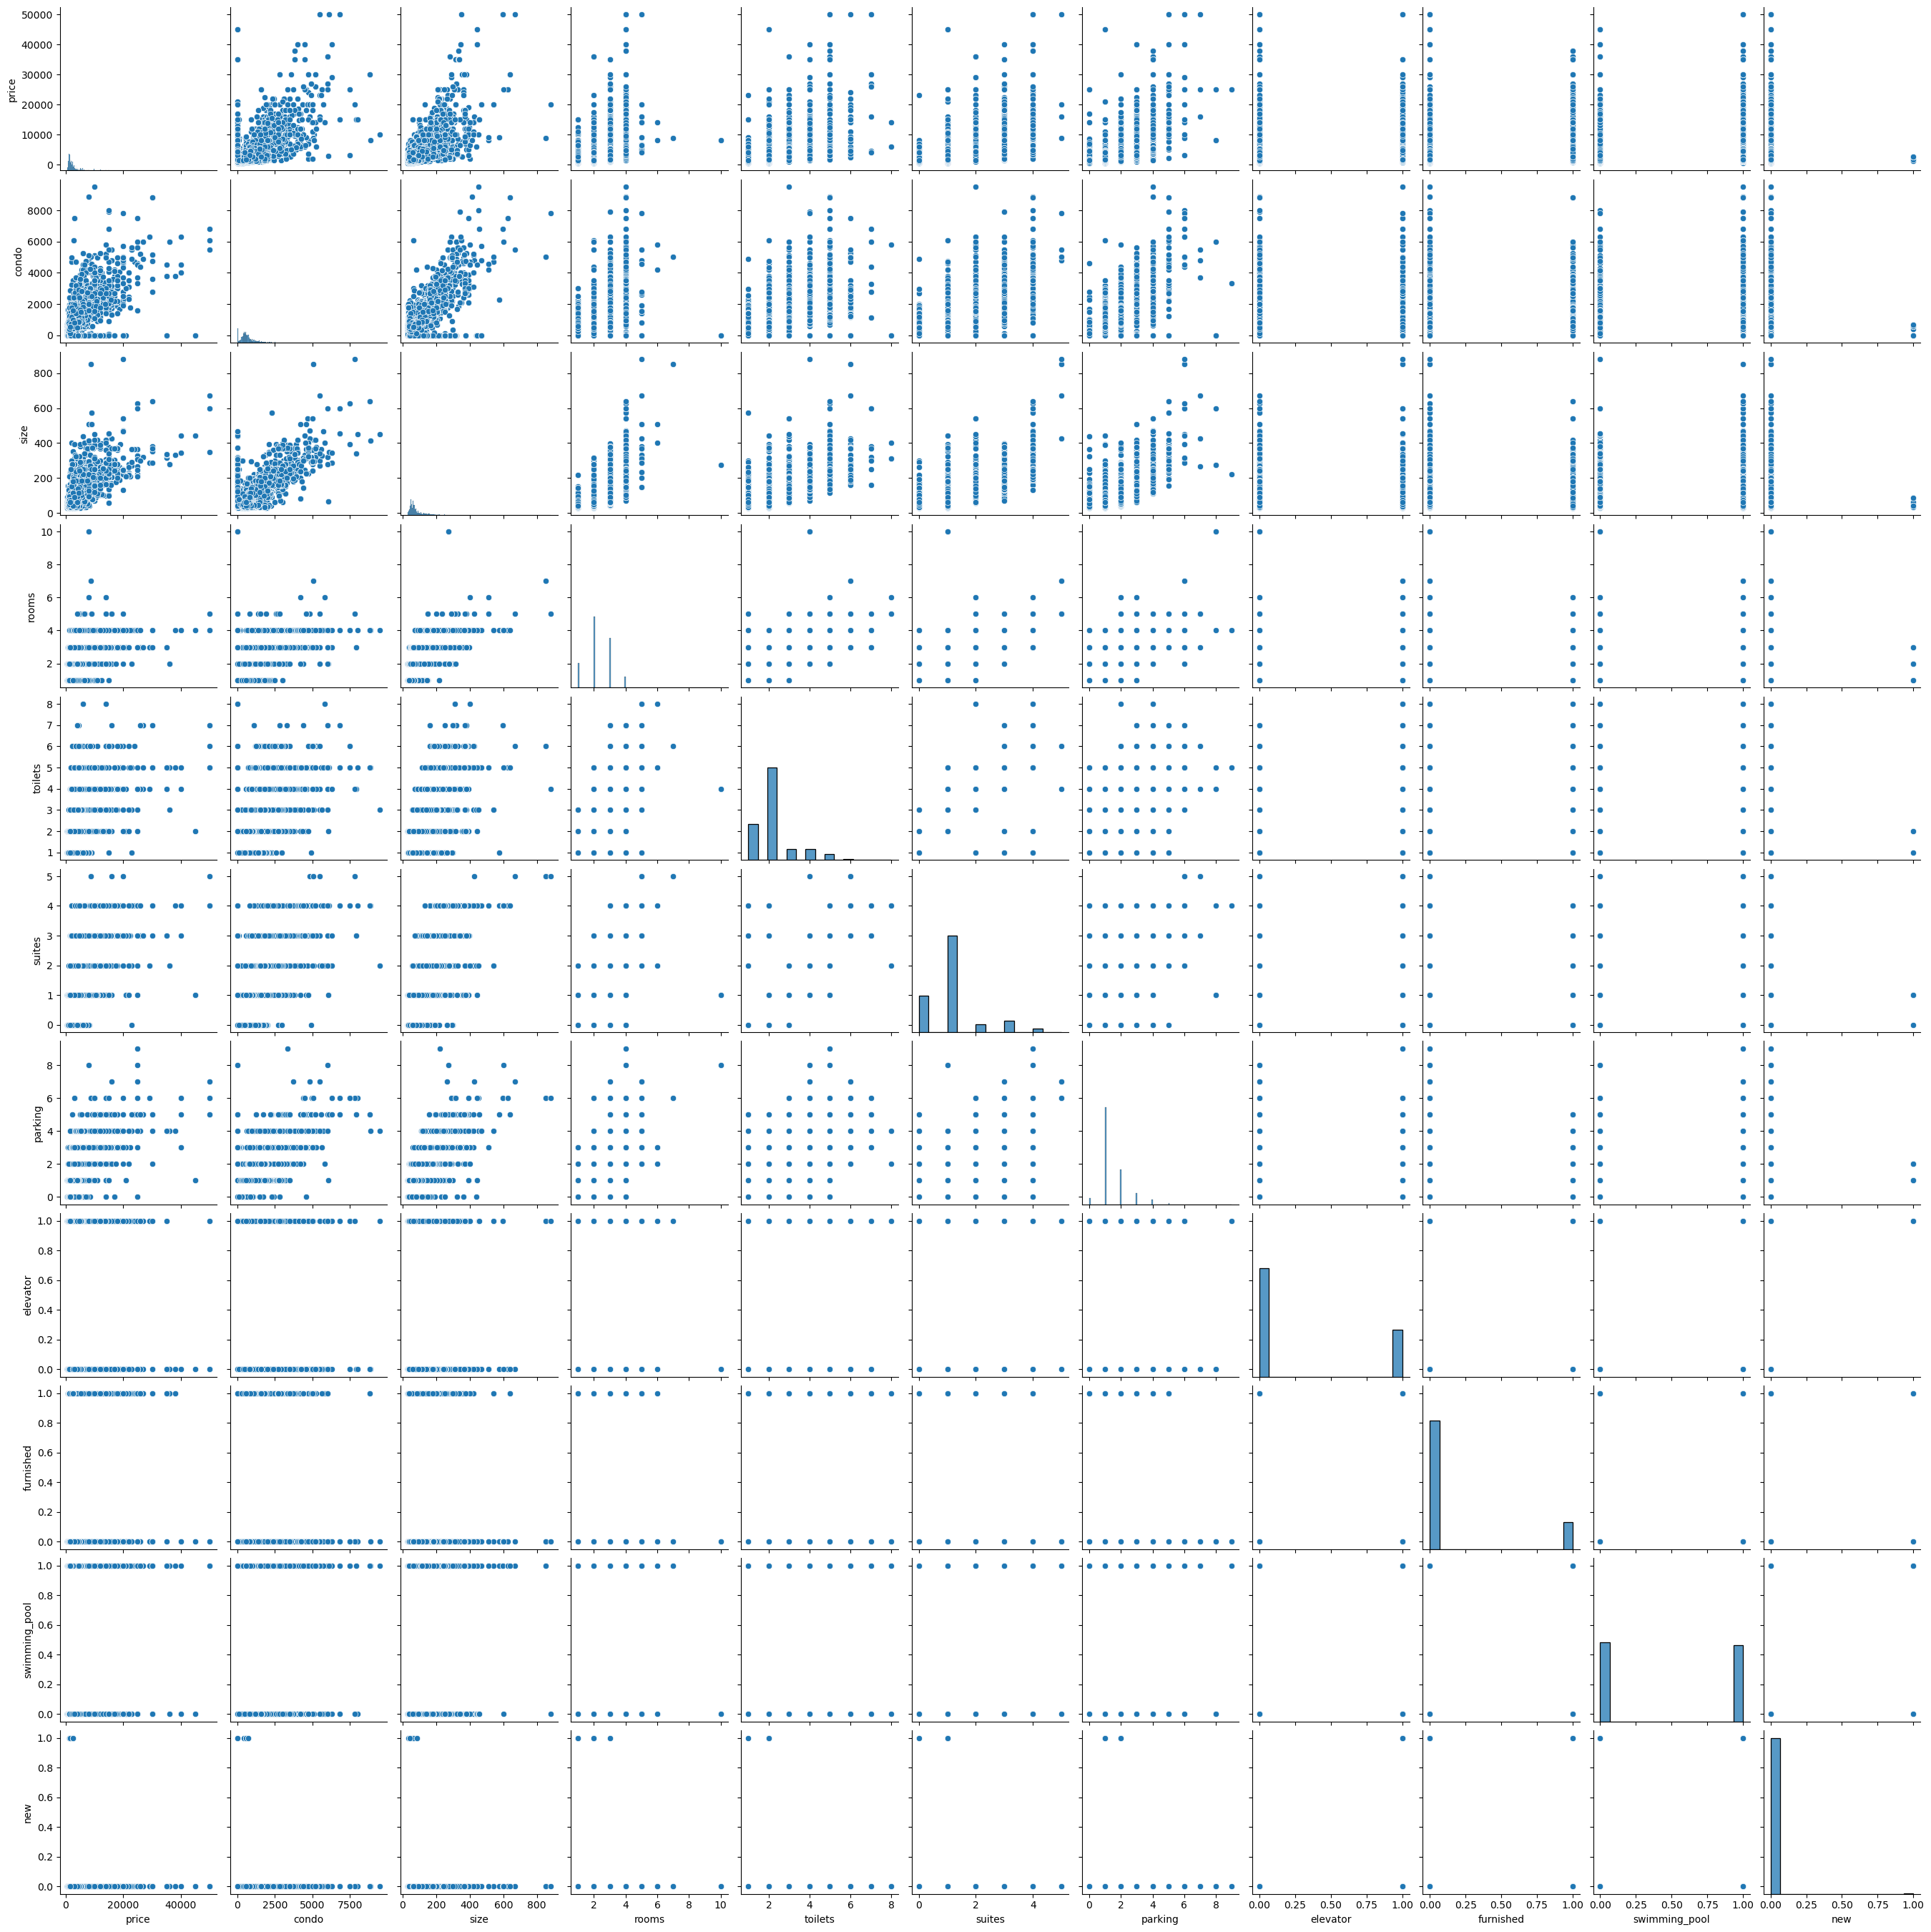

In [82]:
# Fazendo um pairplot entre as variáveis do dataframe.

sns.pairplot(treino_base_aluguel[['price', 'condo', 'size', 'rooms', 'toilets', 'suites', 'parking', 'elevator', 'furnished', 'swimming_pool', 'new', 'district_zone']], aspect=1)

# Feature Scaling

**Comentário:** optou-se pela não realização do feature scaling (normalização) principalmente pela sua potencial perda de interpretabildiade. Os valores normalizados podem não ter significado direto, dificultando sua a interpretação. Além disso, em relação aos modelos aplicados como XGBoosting e LightGBM há referências que informam que sua performance não é afetada pela normalização dos dados.

# 🤖 3.Modelagem Estatística

In [83]:
# Importando todas as bibliotecas para o uso dos modelos

import xgboost as xgb
import optuna
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


In [84]:
# Transformando a coluna District_Zone em dummies

treino_base_venda = pd.get_dummies(treino_base_venda, columns=['district_zone'])
teste_base_venda = pd.get_dummies(teste_base_venda, columns=['district_zone'])

treino_base_aluguel = pd.get_dummies(treino_base_aluguel, columns=['district_zone'])
teste_base_aluguel = pd.get_dummies(teste_base_aluguel, columns=['district_zone'])

In [85]:
treino_base_venda.columns

Index(['price', 'elevator', 'furnished', 'size', 'toilets', 'property_type',
       'condo', 'swimming_pool', 'rooms', 'negotiation_type', 'parking',
       'suites', 'new', 'district_zone_Centro', 'district_zone_Leste',
       'district_zone_Norte', 'district_zone_Oeste', 'district_zone_Sul'],
      dtype='object')

In [86]:
# Listando as variáveis explicativas

vars_exp = ['condo', 'size', 'rooms', 'toilets', 'suites', 'parking', 'elevator', 'furnished', 'swimming_pool', 'new', 'district_zone_Centro', 'district_zone_Leste', 'district_zone_Norte', 'district_zone_Oeste']

# Listando a variável resposta

vars_resp = ['price']

# 🤖 3.1 Modelagem Estatística - Regressor Linear - Venda

In [87]:
regressor_venda = LinearRegression()

# Treine o regressor com os dados de treinamento
regressor_venda.fit(treino_base_venda[vars_exp], treino_base_venda[vars_resp])

#CONJUNTO TREINO#

y_pred_treino = regressor_venda.predict(treino_base_venda[vars_exp])

# Calcule o MSE (Mean Squared Error)
mse_treino = mean_squared_error(treino_base_venda[vars_resp], y_pred_treino)

# Calcule o RMSE (Root Mean Squared Error)

rmse_treino = np.sqrt(mse_treino)

# Calcule R²

r2_treino = r2_score(treino_base_venda[vars_resp], y_pred_treino)


print(f'''Treino - Mean Squared Error (MSE): {mse_treino}''')
print(f'''Treino - Root Mean Squared Error (RMSE): {rmse_treino}''')
print(f'''Treino - R²: {r2_treino}\n''')

#CONJUNTO TESTE#

# Faça previsões com base nos dados de teste
y_pred = regressor_venda.predict(teste_base_venda[vars_exp])

# Calcule o MSE (Mean Squared Error)
mse = mean_squared_error(teste_base_venda[vars_resp], y_pred)

# Calcule o RMSE (Root Mean Squared Error)

rmse = np.sqrt(mse)

# Calcule R²

r2 = r2_score(teste_base_venda[vars_resp], y_pred)

print(f'''Teste - Mean Squared Error (MSE): {mse}''')
print(f'''Teste - Root Mean Squared Error (RMSE): {rmse}''')
print(f'''Teste - R²: {r2}''')

Treino - Mean Squared Error (MSE): 138680013505.34702
Treino - Root Mean Squared Error (RMSE): 372397.65507498436
Treino - R²: 0.7478980952893147

Teste - Mean Squared Error (MSE): 157884879195.57742
Teste - Root Mean Squared Error (RMSE): 397347.3029927061
Teste - R²: 0.7246454428633121


In [88]:
# Verificando os coeficientes de cada variável e o intercepto

coeficientes = regressor_venda.coef_

df_venda_coef = pd.DataFrame({'Variável': vars_exp, 'Coeficiente': coeficientes[0]})
df_venda_coef.sort_values(by='Coeficiente', ascending=False)

Variável    Coeficiente
13   district_zone_Oeste  210917.294642
5                parking  207334.936199
4                 suites  119685.011114
9                    new   86791.286133
8          swimming_pool   47475.615299
10  district_zone_Centro   34416.038207
1                   size    9276.295957
0                  condo      68.729550
3                toilets  -17727.056128
7              furnished  -20352.439673
6               elevator  -35097.569027
11   district_zone_Leste  -36700.824884
12   district_zone_Norte  -98563.223895
2                  rooms -144446.439475

In [89]:
print(f'''O intercepto é {regressor_venda.intercept_}''')

O intercepto é [-190180.9667955]


**Comentário:** Note que para venda as variáveis que contribuem positivamente para o valor do preço são District_Zone_Oeste, Parking, Suites, New, Swimming Pool, District_Zone_Centro e Size. A variável de Condomínio ficou  próximo de zero, contribuindo pouco para o valor final. Já as variáveis que contribuem negativamente são Furnished, Elevator, Toilets, District_Zone_Leste, District_Zone_Norte e Rooms.

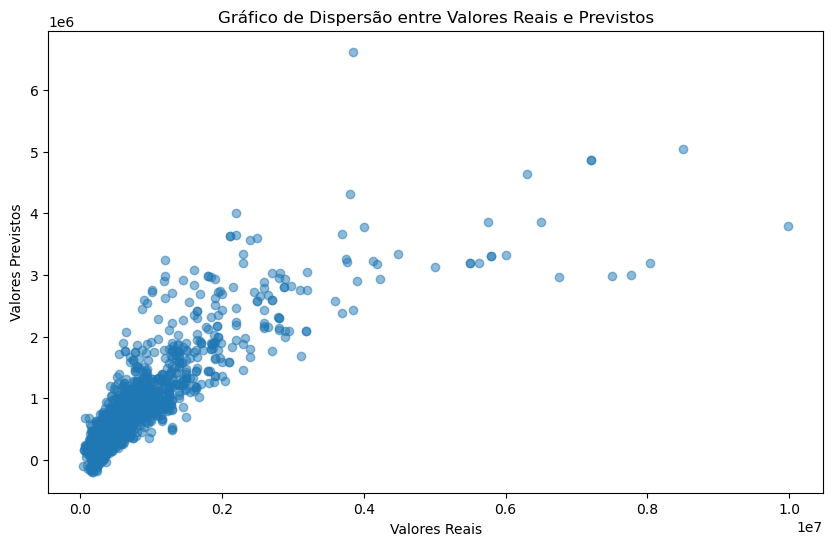

In [90]:
# Gráfico de dispersão

GraficoDispersao(teste_base_venda[vars_resp], y_pred, 'Gráfico de Dispersão entre Valores Reais e Previstos', 'Valores Reais', 'Valores Previstos')


# **Cross-validation**

In [91]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, treino_base_venda[vars_exp], treino_base_venda[vars_resp], scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [302448.43890804 300780.79595946 302883.57080222 378605.89970777
 352403.21298198 285478.33642867 472450.49145668 625974.45052617
 324318.53490436 348950.6211116 ]
Mean: 369429.43527869426
Standard deviation: 99966.18748556009


# 🤖 3.2 Modelagem Estatística - Regressor Linear - Aluguel

In [92]:
regressor_aluguel = LinearRegression()

# Treine o regressor com os dados de treinamento
regressor_aluguel.fit(treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp])

#CONJUNTO TREINO#

y_pred_treino = regressor_aluguel.predict(treino_base_aluguel[vars_exp])

# Calcule o MSE (Mean Squared Error)
mse_treino = mean_squared_error(treino_base_aluguel[vars_resp], y_pred_treino)

# Calcule o RMSE (Root Mean Squared Error)

rmse_treino = np.sqrt(mse_treino)

# Calcule R²

r2_treino = r2_score(treino_base_aluguel[vars_resp], y_pred_treino)

print(f'''Treino - Mean Squared Error (MSE): {mse_treino}''')
print(f'''Treino - Root Mean Squared Error (RMSE): {rmse_treino}''')
print(f'''Treino - R²: {r2_treino}\n''')

#CONJUNTO TESTE#

# Faça previsões com base nos dados de teste
y_pred = regressor_aluguel.predict(teste_base_aluguel[vars_exp])

# Calcule o MSE (Mean Squared Error)
mse = mean_squared_error(teste_base_aluguel[vars_resp], y_pred)

# Calcule o RMSE (Root Mean Squared Error)

rmse = np.sqrt(mse)

# Calcule R²

r2 = r2_score(teste_base_aluguel[vars_resp], y_pred)

print(f'''Teste - Mean Squared Error (MSE): {mse}''')
print(f'''Teste - Root Mean Squared Error (RMSE): {rmse}''')
print(f'''Teste - R²: {r2}''')

Treino - Mean Squared Error (MSE): 4975451.895782311
Treino - Root Mean Squared Error (RMSE): 2230.5721005567857
Treino - R²: 0.6200706385290691

Teste - Mean Squared Error (MSE): 3938415.669971025
Teste - Root Mean Squared Error (RMSE): 1984.5441970314052
Teste - R²: 0.6374033558600395


In [93]:
# Verificando os coeficientes de cada variável e o intercepto

coeficientes = regressor_aluguel.coef_

df_aluguel_coef = pd.DataFrame({'Variável': vars_exp, 'Coeficiente': coeficientes[0]})
df_aluguel_coef.sort_values(by='Coeficiente', ascending=False)

Variável  Coeficiente
7              furnished  1004.086391
5                parking   450.939325
3                toilets   234.313322
8          swimming_pool   221.517846
13   district_zone_Oeste   187.274534
4                 suites   153.145817
1                   size    30.166592
0                  condo     0.753343
9                    new    -8.242685
6               elevator   -95.039852
10  district_zone_Centro  -245.970129
11   district_zone_Leste  -365.868994
12   district_zone_Norte  -699.195138
2                  rooms  -802.886821

In [94]:
print(f'''O intercepto é {regressor_aluguel.intercept_}''')

O intercepto é [244.86255226]


**Comentário:** Note que para aluguel as variáveis que contribuem positivamente para o valor do preço são Furnished, Parking, Toilets, Swimming Pool, New, District_Zone_Oeste, Suites e Size. A variável de Condomínio também ficou  próximo de zero, contribuindo pouco para o valor final. Já as variáveis que contribuem negativamente são Elevator, District_Zone_Centro, District_Zone_Leste, District_Zone_Norte e Rooms. Também note que as variáveis que mais contribuiram negativamente para o preço do aluguel foram variáveis de local

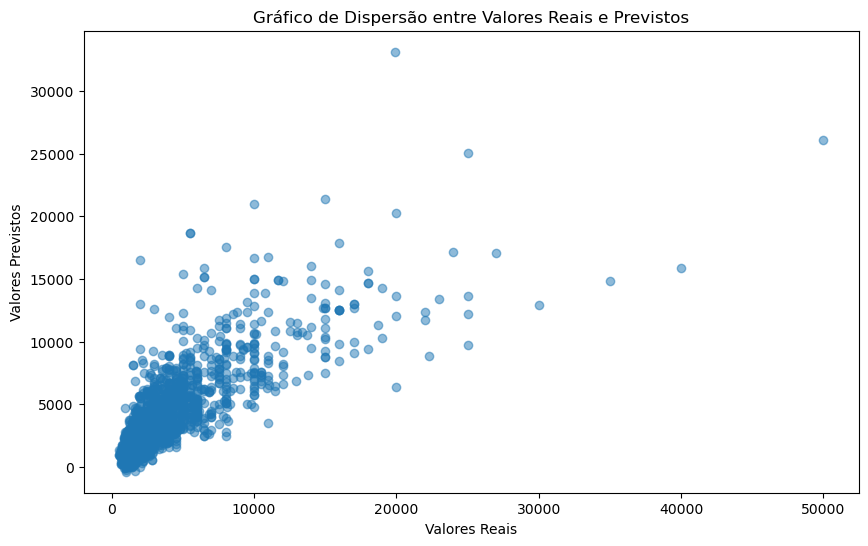

In [95]:
# Gráfico de dispersão

GraficoDispersao(teste_base_aluguel[vars_resp], y_pred, 'Gráfico de Dispersão entre Valores Reais e Previstos', 'Valores Reais', 'Valores Previstos')

# **Cross-validation**

In [96]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp], scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [1641.64743747 1572.76509725 1755.59014378 1306.5021472  1229.15545513
 3357.39228116 2820.84596249 2560.29361744 2482.91369719 2719.95488887]
Mean: 2144.706072797478
Standard deviation: 694.1322659229307


# 🤖 3.3 Modelagem Estatística - XGBoost - Venda

In [97]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()
optuna.logging.disable_propagation()

In [98]:
# Função de otimização do Optuna


def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9, step=0.1),
        'random_state': 42,
    }

    model = xgb.XGBRegressor(**param)
    model.fit(treino_base_venda[vars_exp], treino_base_venda[vars_resp])
    y_pred = model.predict(teste_base_venda[vars_exp])
    rmse = np.sqrt(mean_squared_error(teste_base_venda[vars_resp], y_pred))
    return rmse

# Estudo do Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [99]:
# Imprimindo os melhores parâmetros do XGBRegressor segundo o Optuna
best_params = study.best_params
print("Melhores Parâmetros:")
print(best_params)

Melhores Parâmetros:
{'lambda': 0.2404566869506366, 'alpha': 0.5154324352348261, 'learning_rate': 0.2994606331247576, 'n_estimators': 739, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.7}


In [100]:
# Criando um modelo final com os melhores parâmetros
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(treino_base_venda[vars_exp], treino_base_venda[vars_resp])

#CONJUNTO DE TREINO#

y_pred_final_treino = final_model.predict(treino_base_venda[vars_exp])

rmse_final_treino = np.sqrt(mean_squared_error(treino_base_venda[vars_resp], y_pred_final_treino))

print(f"Treino - RMSE do Modelo Final: {rmse_final_treino}")

#CONJUNTO DE TESTE

# Previsões com o modelo final
y_pred_final = final_model.predict(teste_base_venda[vars_exp])

# Calculando a métrica RMSE com o modelo final
rmse_final = np.sqrt(mean_squared_error(teste_base_venda[vars_resp], y_pred_final))

print(f"Teste - RMSE do Modelo Final: {rmse_final}")

Treino - RMSE do Modelo Final: 48850.985590063465
Teste - RMSE do Modelo Final: 115337.78461949833


In [101]:
# Verificando a importância relativa de cada variável

importancias_variaveis = final_model.feature_importances_

df_venda_xbg = pd.DataFrame({'Variável': vars_exp, 'Coeficiente': importancias_variaveis})
df_venda_xbg.sort_values(by='Coeficiente', ascending=False)

Variável  Coeficiente
5                parking     0.402806
13   district_zone_Oeste     0.136475
1                   size     0.124751
12   district_zone_Norte     0.085665
0                  condo     0.055407
3                toilets     0.051531
11   district_zone_Leste     0.033745
4                 suites     0.022344
2                  rooms     0.018994
6               elevator     0.018924
8          swimming_pool     0.017004
7              furnished     0.012022
10  district_zone_Centro     0.011352
9                    new     0.008981

**Comentários:** Note que mais de 50% da importância das variáveis para este modelo de venda foi referente a vagas de estacionamento e tamanho da propriedade. Já as variáveis que menos tiveram importância (menos de 2%) foram relacionados a mobilia, existência ou não de piscina e elevadores e se a propriedade era nova.

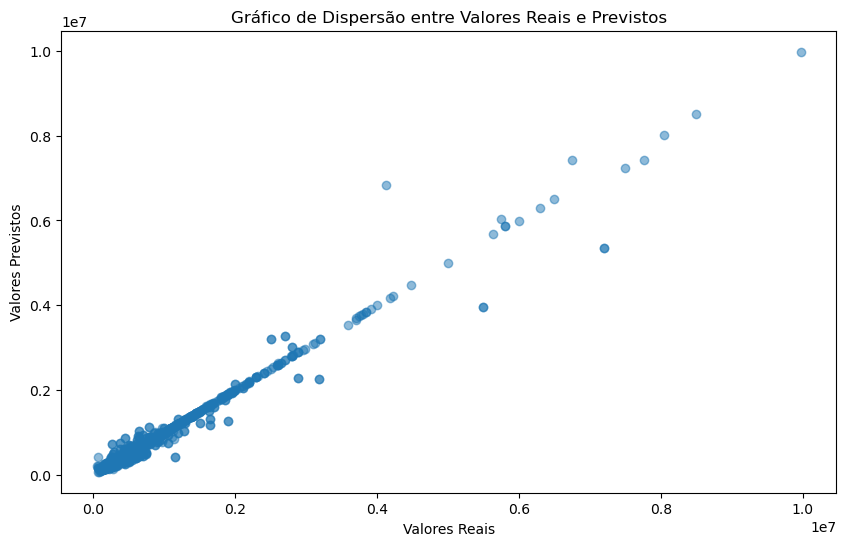

In [102]:
# Gráfico de dispersão

GraficoDispersao(teste_base_venda[vars_resp], y_pred_final, 'Gráfico de Dispersão entre Valores Reais e Previstos', 'Valores Reais', 'Valores Previstos')

# **Cross-validation**

In [103]:
xgb_reg = xgb.XGBRegressor()
xgb_scores = cross_val_score(xgb_reg, treino_base_venda[vars_exp], treino_base_venda[vars_resp], scoring="neg_mean_squared_error", cv=10)

xgb_rmse_scores = np.sqrt(-xgb_scores)

display_scores(xgb_rmse_scores)

Scores: [223026.47453002 261717.11240228  96029.88510312 154926.33842362
 163757.48154861 153726.62430038 261684.81577922 420245.72411576
 263721.96835937 274487.46363774]
Mean: 227332.38882001172
Standard deviation: 86652.67329295211


# 🤖 3.4 Modelagem Estatística - XGBoost - Aluguel

In [104]:
# Função de otimização do Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9, step=0.1),
        'random_state': 42,
    }

    model = xgb.XGBRegressor(**param)
    model.fit(treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp])
    y_pred = model.predict(teste_base_aluguel[vars_exp])
    rmse = np.sqrt(mean_squared_error(teste_base_aluguel[vars_resp], y_pred))
    return rmse

# Estudo do Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [105]:
# Imprimindo os melhores parâmetros do XGBRegressor segundo o Optuna
best_params = study.best_params
print("Melhores Parâmetros:")
print(best_params)

Melhores Parâmetros:
{'lambda': 0.7732016557780026, 'alpha': 0.6943737583162818, 'learning_rate': 0.2688348910217993, 'n_estimators': 703, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7, 'colsample_bytree': 0.9}


In [106]:
# Criando o modelo final com os melhores parâmetros
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp])

#CONJUNTO DE TREINO

y_pred_final_treino = final_model.predict(treino_base_aluguel[vars_exp])

rmse_final_treino = np.sqrt(mean_squared_error(treino_base_aluguel[vars_resp], y_pred_final_treino))

print(f"Treino - RMSE do Modelo Final: {rmse_final_treino}")

# Previsões com o modelo final
y_pred_final = final_model.predict(teste_base_aluguel[vars_exp])

# Calculando a métrica RMSE com o modelo final
rmse_final = np.sqrt(mean_squared_error(teste_base_aluguel[vars_resp], y_pred_final))

print(f"Teste - RMSE do Modelo Final: {rmse_final}")

Treino - RMSE do Modelo Final: 182.36665605137617
Teste - RMSE do Modelo Final: 1164.0821986900119


In [107]:
# Verificando a importância relativa de cada variável

importancias_variaveis = final_model.feature_importances_

df_aluguel_xbg = pd.DataFrame({'Variável': vars_exp, 'Coeficiente': importancias_variaveis})
df_aluguel_xbg.sort_values(by='Coeficiente', ascending=False)

Variável  Coeficiente
1                   size     0.191878
4                 suites     0.115847
0                  condo     0.105278
5                parking     0.101372
7              furnished     0.071926
3                toilets     0.070376
11   district_zone_Leste     0.066215
13   district_zone_Oeste     0.057932
10  district_zone_Centro     0.051270
8          swimming_pool     0.048800
2                  rooms     0.048332
12   district_zone_Norte     0.044503
6               elevator     0.024684
9                    new     0.001587

**Comentários:** Quase 70% da importância ficou em quatro variáveis: número de quartos com banheiro privativo, número de vagas de estacionamento, tamanho da propriedade e que a propriedade estava mobiliada ou não. Perceba que a variável se o imóvel era novo tenho 0% de relevância

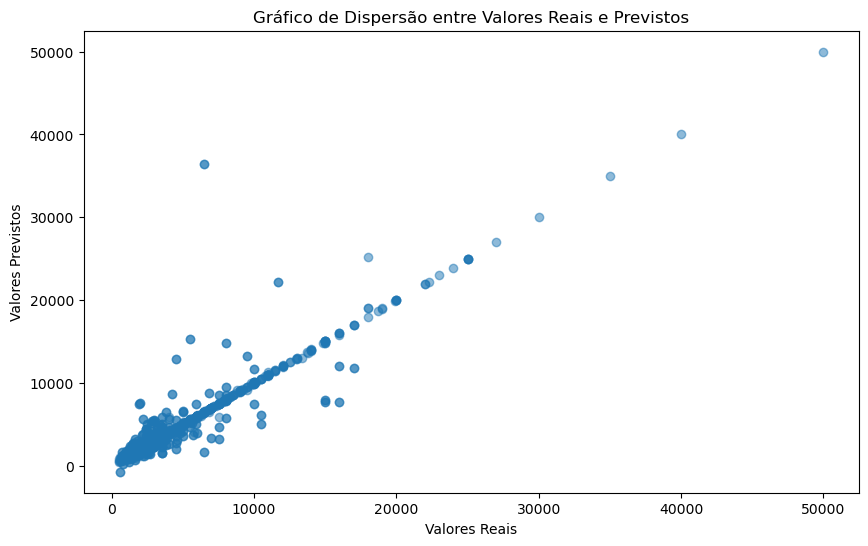

In [108]:
# Gráfico de dispersão

GraficoDispersao(teste_base_aluguel[vars_resp], y_pred_final, 'Gráfico de Dispersão entre Valores Reais e Previstos', 'Valores Reais', 'Valores Previstos')

# **Cross-validation**

In [109]:
xgb_reg = xgb.XGBRegressor()
xgb_scores = cross_val_score(xgb_reg, treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp], scoring="neg_mean_squared_error", cv=10)

xgb_rmse_scores = np.sqrt(-xgb_scores)

display_scores(xgb_rmse_scores)

Scores: [2941.30236308 1372.59611907 1059.69738291  581.67203703  752.54277676
 2611.46548529 2397.23564968 1509.69906453 1708.98758869 2370.31262522]
Mean: 1730.5511092253776
Standard deviation: 774.5664813021807


# 🤖 3.5 Modelagem Estatística - LightGBM - Venda

In [110]:
# Função de otimização do Optuna
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 42,
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(treino_base_venda[vars_exp], treino_base_venda[vars_resp])
    y_pred = model.predict(teste_base_venda[vars_exp])
    rmse = np.sqrt(mean_squared_error(teste_base_venda[vars_resp], y_pred))
    return rmse

# Estudo do Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.696711041724699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696711041724699
[LightGBM] [Warning] lambda_l2 is set=3.4221655481397967e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4221655481397967e-08
[LightGBM] [Warning] lambda_l1 is set=0.0003002952626180359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003002952626180359
[LightGBM] [Warning] bagging_fraction is set=0.16122812616981655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16122812616981655
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.696711041724699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696711041724699
[LightGBM] [Warning] lambda_l2 is set=3.4221655481

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.327313764376429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.327313764376429
[LightGBM] [Warning] lambda_l2 is set=0.8416922732462158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8416922732462158
[LightGBM] [Warning] lambda_l1 is set=2.9661685542479182e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9661685542479182e-06
[LightGBM] [Warning] bagging_fraction is set=0.8004406596361413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8004406596361413
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9916779667794268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9916779667794268
[LightGBM] [Warning] lambda_l2 is set=2.5525866446061407

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9067179268462991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067179268462991
[LightGBM] [Warning] lambda_l2 is set=3.575372874337598e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.575372874337598e-07
[LightGBM] [Warning] lambda_l1 is set=6.59443324395487e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.59443324395487e-06
[LightGBM] [Warning] bagging_fraction is set=0.6404942062182085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6404942062182085
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9067179268462991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067179268462991
[LightGBM] [Warning] lambda_l2 is set=3.575372874337

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5300453100344618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5300453100344618
[LightGBM] [Warning] lambda_l2 is set=1.0722176222112837e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0722176222112837e-05
[LightGBM] [Warning] lambda_l1 is set=0.04828273867799052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04828273867799052
[LightGBM] [Warning] bagging_fraction is set=0.9795516894578401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795516894578401
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5300453100344618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5300453100344618
[LightGBM] [Warning] lambda_l2 is set=1.072217622211

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9178639536979869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9178639536979869
[LightGBM] [Warning] lambda_l2 is set=1.1898343838312006e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1898343838312006e-07
[LightGBM] [Warning] lambda_l1 is set=1.5727100017133423e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5727100017133423e-08
[LightGBM] [Warning] bagging_fraction is set=0.7924100816811523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7924100816811523


/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9031963378609897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9031963378609897
[LightGBM] [Warning] lambda_l2 is set=4.9368140056415955e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9368140056415955e-08
[LightGBM] [Warning] lambda_l1 is set=0.07015127564292459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07015127564292459
[LightGBM] [Warning] bagging_fraction is set=0.6160814384090071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6160814384090071
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9031963378609897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9031963378609897
[LightGBM] [Warning] lambda_l2 is set=4.936814005641

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8170236904672196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8170236904672196
[LightGBM] [Warning] lambda_l2 is set=0.17407803190224902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17407803190224902
[LightGBM] [Warning] lambda_l1 is set=1.5163834187609543e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5163834187609543e-07
[LightGBM] [Warning] bagging_fraction is set=0.349111661574577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.349111661574577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8170236904672196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8170236904672196
[LightGBM] [Warning] lambda_l2 is set=0.17407803190224

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8031781554234758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8031781554234758
[LightGBM] [Warning] lambda_l2 is set=0.005714234517956328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005714234517956328
[LightGBM] [Warning] lambda_l1 is set=1.7982658587979666e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7982658587979666e-08
[LightGBM] [Warning] bagging_fraction is set=0.33489201145622066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33489201145622066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8031781554234758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8031781554234758
[LightGBM] [Warning] lambda_l2 is set=0.00571423

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7799657804722973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7799657804722973
[LightGBM] [Warning] lambda_l2 is set=0.010814777552348243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010814777552348243
[LightGBM] [Warning] lambda_l1 is set=1.9361166319473025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9361166319473025e-08
[LightGBM] [Warning] bagging_fraction is set=0.3098947692855708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3098947692855708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7671113015015614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671113015015614
[LightGBM] [Warning] lambda_l2 is set=0.0067282881

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5883586468409433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5883586468409433
[LightGBM] [Warning] lambda_l2 is set=0.007980114271807398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007980114271807398
[LightGBM] [Warning] lambda_l1 is set=1.0491146071721065e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0491146071721065e-08
[LightGBM] [Warning] bagging_fraction is set=0.13640506431321148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13640506431321148
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5883586468409433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5883586468409433
[LightGBM] [Warning] lambda_l2 is set=0.00798011

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7680032441756502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7680032441756502
[LightGBM] [Warning] lambda_l2 is set=8.369444884658705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.369444884658705
[LightGBM] [Warning] lambda_l1 is set=6.320833924389336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.320833924389336e-07
[LightGBM] [Warning] bagging_fraction is set=0.3344843501636862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3344843501636862
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7680032441756502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7680032441756502
[LightGBM] [Warning] lambda_l2 is set=8.369444884658705, r

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6610373589972232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6610373589972232
[LightGBM] [Warning] lambda_l2 is set=0.00021841643221096323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021841643221096323
[LightGBM] [Warning] lambda_l1 is set=8.983663165974178e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.983663165974178e-05
[LightGBM] [Warning] bagging_fraction is set=0.25007262791861756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25007262791861756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6610373589972232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6610373589972232
[LightGBM] [Warning] lambda_l2 is set=0.000218

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7200333194090528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7200333194090528
[LightGBM] [Warning] lambda_l2 is set=0.0009768706076226407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009768706076226407
[LightGBM] [Warning] lambda_l1 is set=2.868801899798284e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.868801899798284e-05
[LightGBM] [Warning] bagging_fraction is set=0.40673708669725994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40673708669725994
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7200333194090528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7200333194090528
[LightGBM] [Warning] lambda_l2 is set=0.00097687

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9568469815519912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568469815519912
[LightGBM] [Warning] lambda_l2 is set=0.0001429245455975213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001429245455975213
[LightGBM] [Warning] lambda_l1 is set=2.9206017298382634e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9206017298382634e-08
[LightGBM] [Warning] bagging_fraction is set=0.5239926650550966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5239926650550966


/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9952280614917095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9952280614917095
[LightGBM] [Warning] lambda_l2 is set=4.4637553271840566e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4637553271840566e-05
[LightGBM] [Warning] lambda_l1 is set=5.337477824122506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.337477824122506e-08
[LightGBM] [Warning] bagging_fraction is set=0.5043075168249975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5043075168249975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9952280614917095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9952280614917095
[LightGBM] [Warning] lambda_l2 is set=4.46375532

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8502586722162815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8502586722162815
[LightGBM] [Warning] lambda_l2 is set=0.0008129228512570276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008129228512570276
[LightGBM] [Warning] lambda_l1 is set=4.587210493832533e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.587210493832533e-08
[LightGBM] [Warning] bagging_fraction is set=0.3384510795744722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3384510795744722
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8502586722162815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8502586722162815
[LightGBM] [Warning] lambda_l2 is set=0.0008129228

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9028660251582511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9028660251582511
[LightGBM] [Warning] lambda_l2 is set=1.9321381742295794e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9321381742295794e-05
[LightGBM] [Warning] lambda_l1 is set=1.336706220446273e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.336706220446273e-06
[LightGBM] [Warning] bagging_fraction is set=0.4681017810965923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4681017810965923


/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7587431586235837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7587431586235837
[LightGBM] [Warning] lambda_l2 is set=0.003827234217235774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003827234217235774
[LightGBM] [Warning] lambda_l1 is set=1.9654923690064378e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9654923690064378e-07
[LightGBM] [Warning] bagging_fraction is set=0.30675664451308243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30675664451308243
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7587431586235837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7587431586235837
[LightGBM] [Warning] lambda_l2 is set=0.00382723

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.836697096033021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.836697096033021
[LightGBM] [Warning] lambda_l2 is set=0.0003517310690878513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003517310690878513
[LightGBM] [Warning] lambda_l1 is set=1.1205162214072455e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1205162214072455e-08
[LightGBM] [Warning] bagging_fraction is set=0.37996239346604965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37996239346604965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.836697096033021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.836697096033021
[LightGBM] [Warning] lambda_l2 is set=0.0003517310

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9409189143948182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9409189143948182
[LightGBM] [Warning] lambda_l2 is set=2.3835714144351735e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3835714144351735e-06
[LightGBM] [Warning] lambda_l1 is set=1.067851807714243e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.067851807714243e-06
[LightGBM] [Warning] bagging_fraction is set=0.3939472997063493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3939472997063493
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9409189143948182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9409189143948182
[LightGBM] [Warning] lambda_l2 is set=2.38357141

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.997445811638305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997445811638305
[LightGBM] [Warning] lambda_l2 is set=8.746188859361519e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.746188859361519e-05
[LightGBM] [Warning] lambda_l1 is set=1.0143613158299535e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0143613158299535e-08
[LightGBM] [Warning] bagging_fraction is set=0.5038512269311557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5038512269311557
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.997445811638305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997445811638305
[LightGBM] [Warning] lambda_l2 is set=8.746188859361

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7997910414930547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997910414930547
[LightGBM] [Warning] lambda_l2 is set=0.0015194301707240501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015194301707240501
[LightGBM] [Warning] lambda_l1 is set=2.1517417177747522e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1517417177747522e-08
[LightGBM] [Warning] bagging_fraction is set=0.30184637903603984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30184637903603984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6902681088503272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902681088503272
[LightGBM] [Warning] lambda_l2 is set=0.001065

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6902681088503272, co

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9478888854171375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9478888854171375
[LightGBM] [Warning] lambda_l2 is set=0.002684121281815351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002684121281815351
[LightGBM] [Warning] lambda_l1 is set=2.3449585722092723e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3449585722092723e-07
[LightGBM] [Warning] bagging_fraction is set=0.1851193066768565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1851193066768565
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9478888854171375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9478888854171375
[LightGBM] [Warning] lambda_l2 is set=0.0026841212

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7909309746539664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7909309746539664
[LightGBM] [Warning] lambda_l2 is set=0.0011914659961041276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011914659961041276
[LightGBM] [Warning] lambda_l1 is set=9.82001599601268e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.82001599601268e-08
[LightGBM] [Warning] bagging_fraction is set=0.4687249997375448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4687249997375448
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7909309746539664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7909309746539664
[LightGBM] [Warning] lambda_l2 is set=0.001191465996

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9077337047918055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9077337047918055
[LightGBM] [Warning] lambda_l2 is set=2.654281542360097e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.654281542360097e-05
[LightGBM] [Warning] lambda_l1 is set=2.573367649533204e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.573367649533204e-06
[LightGBM] [Warning] bagging_fraction is set=0.5419206579143001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419206579143001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9077337047918055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9077337047918055
[LightGBM] [Warning] lambda_l2 is set=2.6542815423

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7202420975376538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7202420975376538
[LightGBM] [Warning] lambda_l2 is set=0.00013947567749472069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013947567749472069
[LightGBM] [Warning] lambda_l1 is set=1.8634635548225556e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8634635548225556e-05
[LightGBM] [Warning] bagging_fraction is set=0.37592674319977754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37592674319977754
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7202420975376538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7202420975376538
[LightGBM] [Warning] lambda_l2 is set=0.

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.804470578151115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804470578151115
[LightGBM] [Warning] lambda_l2 is set=0.008182367962486664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008182367962486664
[LightGBM] [Warning] lambda_l1 is set=2.409912726690368e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409912726690368e-08
[LightGBM] [Warning] bagging_fraction is set=0.32956101531094495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32956101531094495
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.813627534868179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.813627534868179
[LightGBM] [Warning] lambda_l2 is set=0.00242409653099

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.813627534868179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.813627534868179
[LightGBM] [Warning] lambda_l2 is set=0.0024240965309936693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024240965309936693
[LightGBM] [Warning] lambda_l1 is set=1.8509541047793895e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8509541047793895e-08
[LightGBM] [Warning] bagging_fraction is set=0.3114394550577162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3114394550577162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8840826999993088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8840826999993088
[LightGBM] [Warning] lambda_l2 is set=0.0514187338

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9266162839192722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9266162839192722
[LightGBM] [Warning] lambda_l2 is set=0.0005954241390971648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005954241390971648
[LightGBM] [Warning] lambda_l1 is set=1.3304294569717653e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3304294569717653e-07
[LightGBM] [Warning] bagging_fraction is set=0.22868353230278776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22868353230278776
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9611012423251166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9611012423251166
[LightGBM] [Warning] lambda_l2 is set=0.007907

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7940138634883029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7940138634883029
[LightGBM] [Warning] lambda_l2 is set=0.0001831424903334631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001831424903334631
[LightGBM] [Warning] lambda_l1 is set=4.196564977670568e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.196564977670568e-07
[LightGBM] [Warning] bagging_fraction is set=0.2940472179341089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2940472179341089
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7940138634883029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7940138634883029
[LightGBM] [Warning] lambda_l2 is set=0.0001831424

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8854224897858588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854224897858588
[LightGBM] [Warning] lambda_l2 is set=0.11017026878919407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11017026878919407
[LightGBM] [Warning] lambda_l1 is set=7.491486060289567e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.491486060289567e-08
[LightGBM] [Warning] bagging_fraction is set=0.3802740041402821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3802740041402821
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8854224897858588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854224897858588
[LightGBM] [Warning] lambda_l2 is set=0.11017026878919

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7810492034641735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810492034641735
[LightGBM] [Warning] lambda_l2 is set=0.0033095706158891634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033095706158891634
[LightGBM] [Warning] lambda_l1 is set=2.7871415794147053e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7871415794147053e-07
[LightGBM] [Warning] bagging_fraction is set=0.3287917979038418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3287917979038418


/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7327389506393083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7327389506393083
[LightGBM] [Warning] lambda_l2 is set=0.0021024240774553983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021024240774553983
[LightGBM] [Warning] lambda_l1 is set=2.569867891968225e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.569867891968225e-07
[LightGBM] [Warning] bagging_fraction is set=0.6411396403267212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6411396403267212
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7327389506393083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7327389506393083
[LightGBM] [Warning] lambda_l2 is set=0.0021024240

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.796089130009649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.796089130009649
[LightGBM] [Warning] lambda_l2 is set=0.0006729796012350391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006729796012350391
[LightGBM] [Warning] lambda_l1 is set=2.5831615615089564e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5831615615089564e-08
[LightGBM] [Warning] bagging_fraction is set=0.33696574672486335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33696574672486335
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.796089130009649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.796089130009649
[LightGBM] [Warning] lambda_l2 is set=0.0006729796

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6851572376426173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6851572376426173
[LightGBM] [Warning] lambda_l2 is set=0.0050155411350078115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0050155411350078115
[LightGBM] [Warning] lambda_l1 is set=1.0439763238492226e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0439763238492226e-07
[LightGBM] [Warning] bagging_fraction is set=0.24020401522016366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24020401522016366
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6851572376426173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6851572376426173
[LightGBM] [Warning] lambda_l2 is set=0.005015

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6708285763809022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6708285763809022
[LightGBM] [Warning] lambda_l2 is set=0.004552028149780214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004552028149780214
[LightGBM] [Warning] lambda_l1 is set=9.104305478235994e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.104305478235994e-08
[LightGBM] [Warning] bagging_fraction is set=0.20191742389532313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20191742389532313
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6708285763809022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6708285763809022
[LightGBM] [Warning] lambda_l2 is set=0.0045520281

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7562120283244147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7562120283244147
[LightGBM] [Warning] lambda_l2 is set=0.0019253589651778492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019253589651778492
[LightGBM] [Warning] lambda_l1 is set=4.0091757344799853e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0091757344799853e-07
[LightGBM] [Warning] bagging_fraction is set=0.1509626233647593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1509626233647593
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7562120283244147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7562120283244147
[LightGBM] [Warning] lambda_l2 is set=0.00192535

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6399852189470081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399852189470081
[LightGBM] [Warning] lambda_l2 is set=0.0002554883058799442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002554883058799442
[LightGBM] [Warning] lambda_l1 is set=3.959949811718744e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.959949811718744e-08
[LightGBM] [Warning] bagging_fraction is set=0.21653768235485382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21653768235485382
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6399852189470081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399852189470081
[LightGBM] [Warning] lambda_l2 is set=0.00025548

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7758544480722636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7758544480722636
[LightGBM] [Warning] lambda_l2 is set=0.0049340301992234475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0049340301992234475
[LightGBM] [Warning] lambda_l1 is set=7.08326450837672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.08326450837672e-07
[LightGBM] [Warning] bagging_fraction is set=0.2722138648577605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2722138648577605
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7758544480722636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7758544480722636
[LightGBM] [Warning] lambda_l2 is set=0.004934030199

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7312541843790561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7312541843790561
[LightGBM] [Warning] lambda_l2 is set=0.011206315058134042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011206315058134042
[LightGBM] [Warning] lambda_l1 is set=7.766591593948496e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.766591593948496e-08
[LightGBM] [Warning] bagging_fraction is set=0.3153301065645201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3153301065645201
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7312541843790561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7312541843790561
[LightGBM] [Warning] lambda_l2 is set=0.011206315058

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8317370011921938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317370011921938
[LightGBM] [Warning] lambda_l2 is set=0.0014126134318372422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014126134318372422
[LightGBM] [Warning] lambda_l1 is set=1.839087457482572e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.839087457482572e-08
[LightGBM] [Warning] bagging_fraction is set=0.35286678716295283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35286678716295283
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8317370011921938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317370011921938
[LightGBM] [Warning] lambda_l2 is set=0.00141261

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8888540894405104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8888540894405104
[LightGBM] [Warning] lambda_l2 is set=0.0005360625509015556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005360625509015556
[LightGBM] [Warning] lambda_l1 is set=1.8406743064545308e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8406743064545308e-07
[LightGBM] [Warning] bagging_fraction is set=0.19332888117614294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19332888117614294
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8888540894405104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8888540894405104
[LightGBM] [Warning] lambda_l2 is set=0.000536

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.773866362382889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.773866362382889
[LightGBM] [Warning] lambda_l2 is set=0.004738909325060836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004738909325060836
[LightGBM] [Warning] lambda_l1 is set=2.290852106306577e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.290852106306577e-08
[LightGBM] [Warning] bagging_fraction is set=0.2496216522070211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2496216522070211


/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7698749486615539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7698749486615539
[LightGBM] [Warning] lambda_l2 is set=0.0031212183872401144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031212183872401144
[LightGBM] [Warning] lambda_l1 is set=1.0113435048264323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0113435048264323e-08
[LightGBM] [Warning] bagging_fraction is set=0.24787890947099311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24787890947099311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7698749486615539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7698749486615539
[LightGBM] [Warning] lambda_l2 is set=0.003121

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7649496351255064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649496351255064
[LightGBM] [Warning] lambda_l2 is set=0.004743865072210596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004743865072210596
[LightGBM] [Warning] lambda_l1 is set=1.1259529440294828e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1259529440294828e-08
[LightGBM] [Warning] bagging_fraction is set=0.2547863644008778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2547863644008778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7649496351255064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649496351255064
[LightGBM] [Warning] lambda_l2 is set=0.0047438650

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8218289436506078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8218289436506078
[LightGBM] [Warning] lambda_l2 is set=0.018381088194229647, reg

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7816304378455871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816304378455871
[LightGBM] [Warning] lambda_l2 is set=0.04220446899171322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04220446899171322
[LightGBM] [Warning] lambda_l1 is set=2.6062931446517165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6062931446517165e-08
[LightGBM] [Warning] bagging_fraction is set=0.29710614078879416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29710614078879416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7816304378455871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816304378455871
[LightGBM] [Warning] lambda_l2 is set=0.0422044689

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7428453582718251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7428453582718251
[LightGBM] [Warning] lambda_l2 is set=0.0030232236226192073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030232236226192073
[LightGBM] [Warning] lambda_l1 is set=1.0424952817040571e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0424952817040571e-07
[LightGBM] [Warning] bagging_fraction is set=0.17047820983577097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17047820983577097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7428453582718251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7428453582718251
[LightGBM] [Warning] lambda_l2 is set=0.003023

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.697385750649737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.697385750649737
[LightGBM] [Warning] lambda_l2 is set=0.010103917690793045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010103917690793045
[LightGBM] [Warning] lambda_l1 is set=1.7851612249107505e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7851612249107505e-08
[LightGBM] [Warning] bagging_fraction is set=0.12636467078770625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12636467078770625
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.697385750649737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.697385750649737
[LightGBM] [Warning] lambda_l2 is set=0.010103917690

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8234314471380627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234314471380627
[LightGBM] [Warning] lambda_l2 is set=0.001067588303935952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001067588303935952
[LightGBM] [Warning] lambda_l1 is set=4.915492935430824e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.915492935430824e-08
[LightGBM] [Warning] bagging_fraction is set=0.20689477423009062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20689477423009062
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8234314471380627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234314471380627
[LightGBM] [Warning] lambda_l2 is set=0.0010675883

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8317529256531989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317529256531989
[LightGBM] [Warning] lambda_l2 is set=0.0010501485025807638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010501485025807638
[LightGBM] [Warning] lambda_l1 is set=4.6858033273084047e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6858033273084047e-08
[LightGBM] [Warning] bagging_fraction is set=0.1510777329226457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1510777329226457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8317529256531989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317529256531989
[LightGBM] [Warning] lambda_l2 is set=0.00105014

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7723996486965358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723996486965358
[LightGBM] [Warning] lambda_l2 is set=0.0018411095415076539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018411095415076539
[LightGBM] [Warning] lambda_l1 is set=3.836029036599432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.836029036599432e-08
[LightGBM] [Warning] bagging_fraction is set=0.2679614405605642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2679614405605642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train 

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8045895843018889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8045895843018889
[LightGBM] [Warning] lambda_l2 is set=0.003328539459836141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003328539459836141
[LightGBM] [Warning] lambda_l1 is set=7.244443348580699e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.244443348580699e-08
[LightGBM] [Warning] bagging_fraction is set=0.23347271316577534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23347271316577534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8045895843018889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8045895843018889
[LightGBM] [Warning] lambda_l2 is set=0.0033285394

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7200594899636857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7200594899636857
[LightGBM] [Warning] lambda_l2 is set=0.006718613079198361, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006718613079198361
[LightGBM] [Warning] lambda_l1 is set=1.6942841383463243e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6942841383463243e-07
[LightGBM] [Warning] bagging_fraction is set=0.2980835261085511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2980835261085511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7200594899636857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7200594899636857
[LightGBM] [Warning] lambda_l2 is set=0.0067186130

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7526109403323653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7526109403323653
[LightGBM] [Warning] lambda_l2 is set=0.0004036102380532991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004036102380532991
[LightGBM] [Warning] lambda_l1 is set=1.0051085006185093e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0051085006185093e-08
[LightGBM] [Warning] bagging_fraction is set=0.19422588922249523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19422588922249523
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7526109403323653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7526109403323653
[LightGBM] [Warning] lambda_l2 is set=0.000403

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.826089825463874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.826089825463874
[LightGBM] [Warning] lambda_l2 is set=0.0009122471695055564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009122471695055564
[LightGBM] [Warning] lambda_l1 is set=2.2118328169667603e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2118328169667603e-08
[LightGBM] [Warning] bagging_fraction is set=0.3310153205585783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3310153205585783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.826089825463874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.826089825463874
[LightGBM] [Warning] lambda_l2 is set=0.000912247169

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7786760116193896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7786760116193896
[LightGBM] [Warning] lambda_l2 is set=0.0016980822654029447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016980822654029447
[LightGBM] [Warning] lambda_l1 is set=3.858942922641942e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.858942922641942e-08
[LightGBM] [Warning] bagging_fraction is set=0.11029293433225709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11029293433225709
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7786760116193896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7786760116193896
[LightGBM] [Warning] lambda_l2 is set=0.00169808

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 10081, number of used features: 14
[LightGBM] [Info] Start training from score 611281.460966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100961833714109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100961833714109
[LightGBM] [Warning] lambda_l2 is set=0.004020704078864963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004020704078864963
[LightGBM] [Warning] lambda_l1 is set=1.5439703004390295e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5439703004390295e-06
[LightGBM] [Warning] bagging_fraction is set=0.279471096155802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.279471096155802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100961833714109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100961833714109
[LightGBM] [Warning] lambda_l2 is set=0.004020704078

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7069553182226904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069553182226904
[LightGBM] [Warning] lambda_l2 is set=0.010639772743727193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010639772743727193
[LightGBM] [Warning] lambda_l1 is set=9.90479499702464e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.90479499702464e-08
[LightGBM] [Warning] bagging_fraction is set=0.22114463112449767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22114463112449767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7069553182226904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069553182226904
[LightGBM] [Warning] lambda_l2 is set=0.010639772743

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7162224717090804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7162224717090804
[LightGBM] [Warning] lambda_l2 is set=0.0061674673702713685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0061674673702713685
[LightGBM] [Warning] lambda_l1 is set=6.166771114383725e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.166771114383725e-08
[LightGBM] [Warning] bagging_fraction is set=0.21388775330984433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21388775330984433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7016080205763622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7016080205763622
[LightGBM] [Warning] lambda_l2 is set=0.03000033

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7016080205763622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7016080205763622
[LightGBM] [Warning] lambda_l2 is set=0.030000335376665785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030000335376665785
[LightGBM] [Warning] lambda_l1 is set=2.1899216532564868e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1899216532564868e-08
[LightGBM] [Warning] bagging_fraction is set=0.22686894336796923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22686894336796923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the trai

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7159913462349952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159913462349952
[LightGBM] [Warning] lambda_l2 is set=0.027531585963604624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027531585963604624
[LightGBM] [Warning] lambda_l1 is set=1.762546809909039e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.762546809909039e-08
[LightGBM] [Warning] bagging_fraction is set=0.16696756623329578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16696756623329578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7159913462349952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159913462349952
[LightGBM] [Warning] lambda_l2 is set=0.0275315859

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7541057276755564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7541057276755564
[LightGBM] [Warning] lambda_l2 is set=0.05343362757255749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05343362757255749
[LightGBM] [Warning] lambda_l1 is set=2.5150841968668947e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5150841968668947e-08
[LightGBM] [Warning] bagging_fraction is set=0.21881271989376158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21881271989376158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7084984683652397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7084984683652397
[LightGBM] [Warning] lambda_l2 is set=0.0645616271

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7458373182095936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458373182095936
[LightGBM] [Warning] lambda_l2 is set=0.0297584560452721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0297584560452721
[LightGBM] [Warning] lambda_l1 is set=6.625839262218909e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.625839262218909e-08
[LightGBM] [Warning] bagging_fraction is set=0.21530282397849174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21530282397849174
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7458373182095936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458373182095936
[LightGBM] [Warning] lambda_l2 is set=0.02975845604527

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6715020899295164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715020899295164
[LightGBM] [Warning] lambda_l2 is set=0.013737485195249912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013737485195249912
[LightGBM] [Warning] lambda_l1 is set=5.575895442980176e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.575895442980176e-07
[LightGBM] [Warning] bagging_fraction is set=0.26906966464381515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26906966464381515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6715020899295164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715020899295164
[LightGBM] [Warning] lambda_l2 is set=0.0137374851

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6450399897180293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6450399897180293
[LightGBM] [Warning] lambda_l2 is set=0.23555563616239614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23555563616239614
[LightGBM] [Warning] lambda_l1 is set=3.311183359488619e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311183359488619e-08
[LightGBM] [Warning] bagging_fraction is set=0.1953654207951542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1953654207951542
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6450399897180293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6450399897180293
[LightGBM] [Warning] lambda_l2 is set=0.23555563616239

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7438748407806631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7438748407806631
[LightGBM] [Warning] lambda_l2 is set=0.006042139175686188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006042139175686188
[LightGBM] [Warning] lambda_l1 is set=1.3321909150794765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3321909150794765e-08
[LightGBM] [Warning] bagging_fraction is set=0.28590773411895143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28590773411895143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7438748407806631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7438748407806631
[LightGBM] [Warning] lambda_l2 is set=0.00604213

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.757759318929087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.757759318929087
[LightGBM] [Warning] lambda_l2 is set=0.014552389514952448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014552389514952448
[LightGBM] [Warning] lambda_l1 is set=5.715993630799689e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.715993630799689e-08
[LightGBM] [Warning] bagging_fraction is set=0.3121845399219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3121845399219
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6829296158185678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6829296158185678
[LightGBM] [Warning] lambda_l2 is set=0.02902324010718597, r

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6829296158185678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6829296158185678
[LightGBM] [Warning] lambda_l2 is set=0.02902324010718597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02902324010718597
[LightGBM] [Warning] lambda_l1 is set=1.6620870234555293e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6620870234555293e-08
[LightGBM] [Warning] bagging_fraction is set=0.2433042370254515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2433042370254515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7902173252231401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7902173252231401
[LightGBM] [Warning] lambda_l2 is set=0.007712976376

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7902173252231401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7902173252231401
[LightGBM] [Warning] lambda_l2 is set=0.007712976376713493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007712976376713493
[LightGBM] [Warning] lambda_l1 is set=3.2535851080107476e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2535851080107476e-08
[LightGBM] [Warning] bagging_fraction is set=0.2560789485117378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2560789485117378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7353440683156568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7353440683156568
[LightGBM] [Warning] lambda_l2 is set=0.0029363539

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7625364067410112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625364067410112
[LightGBM] [Warning] lambda_l2 is set=0.017778394090728948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017778394090728948
[LightGBM] [Warning] lambda_l1 is set=1.0171494884097022e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0171494884097022e-08
[LightGBM] [Warning] bagging_fraction is set=0.3516923216436857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3516923216436857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7625364067410112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625364067410112
[LightGBM] [Warning] lambda_l2 is set=0.0177783940

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7112685943183343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7112685943183343
[LightGBM] [Warning] lambda_l2 is set=0.009382409314825396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009382409314825396
[LightGBM] [Warning] lambda_l1 is set=8.027157320001686e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.027157320001686e-08
[LightGBM] 

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8084865965184473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8084865965184473
[LightGBM] [Warning] lambda_l2 is set=0.003981222918656228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003981222918656228
[LightGBM] [Warning] lambda_l1 is set=1.7447101277397956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7447101277397956e-08
[LightGBM] [Warning] bagging_fraction is set=0.2289432576192753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2289432576192753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train 

/tmp/ipykernel_19394/2166767348.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/2166767348.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/2166767348.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8598659375345259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598659375345259
[LightGBM] [Warning] lambda_l2 is set=0.001560879331177197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001560879331177197
[LightGBM] [Warning] lambda_l1 is set=2.2183723579458888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2183723579458888e-07
[LightGBM] [Warning] bagging_fraction is set=0.18120169300595515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18120169300595515
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8598659375345259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598659375345259
[LightGBM] [Warning] lambda_l2 is set=0.00156087

In [111]:
# Imprimindo os melhores parâmetros segundo o Optuna
best_params = study.best_params
print("Melhores Parâmetros:")
print(best_params)

Melhores Parâmetros:
{'lambda_l1': 1.5439703004390295e-06, 'lambda_l2': 0.004020704078864963, 'num_leaves': 216, 'feature_fraction': 0.7100961833714109, 'bagging_fraction': 0.279471096155802, 'bagging_freq': 1, 'min_child_samples': 1, 'learning_rate': 0.07836842240459554, 'n_estimators': 667}


In [112]:
# Criando o modelo final com os melhores parâmetros
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(treino_base_venda[vars_exp], treino_base_venda[vars_resp])

[LightGBM] [Warning] feature_fraction is set=0.7100961833714109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100961833714109
[LightGBM] [Warning] lambda_l2 is set=0.004020704078864963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004020704078864963
[LightGBM] [Warning] lambda_l1 is set=1.5439703004390295e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5439703004390295e-06
[LightGBM] [Warning] bagging_fraction is set=0.279471096155802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.279471096155802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100961833714109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100961833714109
[LightGBM] [Warning] lambda_l2 is set=0.004020704078864963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004020704078864963
[LightGBM] [Warning] l

LGBMRegressor(bagging_fraction=0.279471096155802, bagging_freq=1,
              feature_fraction=0.7100961833714109,
              lambda_l1=1.5439703004390295e-06, lambda_l2=0.004020704078864963,
              learning_rate=0.07836842240459554, min_child_samples=1,
              n_estimators=667, num_leaves=216)

In [113]:
#CONJUNTO TREINO

y_pred_final_treino = final_model.predict(treino_base_venda[vars_exp])

rmse_final_treino = np.sqrt(mean_squared_error(treino_base_venda[vars_resp], y_pred_final_treino))

print(f"Treino - RMSE do Modelo Final: {rmse_final_treino}")

#CONJUNTO TESTE

# Previsões com o modelo final
y_pred_final = final_model.predict(teste_base_venda[vars_exp])

# Calculando a métrica RMSE com o modelo final
rmse_final = np.sqrt(mean_squared_error(teste_base_venda[vars_resp], y_pred_final))
print(f"Teste - RMSE do Modelo Final: {rmse_final}")

[LightGBM] [Warning] feature_fraction is set=0.7100961833714109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100961833714109
[LightGBM] [Warning] lambda_l2 is set=0.004020704078864963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004020704078864963
[LightGBM] [Warning] lambda_l1 is set=1.5439703004390295e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5439703004390295e-06
[LightGBM] [Warning] bagging_fraction is set=0.279471096155802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.279471096155802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Treino - RMSE do Modelo Final: 27439.975999510098
[LightGBM] [Warning] feature_fraction is set=0.7100961833714109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100961833714109
[LightGBM] [Warning] lambda_l2 is set=0.004020704078864963, reg_lambda=0.0 will be ignored. Current value: lam

In [114]:
# Verificando a importância relativa de cada variável

importancias_variaveis = final_model.feature_importances_

df_venda_lgbm = pd.DataFrame({'Variável': vars_exp, 'Coeficiente': importancias_variaveis})
df_venda_lgbm.sort_values(by='Coeficiente', ascending=False)

Variável  Coeficiente
1                   size        43498
0                  condo        35727
3                toilets         9601
2                  rooms         8651
5                parking         7549
6               elevator         6133
8          swimming_pool         5331
4                 suites         5058
7              furnished         4641
11   district_zone_Leste         4497
13   district_zone_Oeste         3994
12   district_zone_Norte         3794
10  district_zone_Centro         3385
9                    new         1546

**Comentários:** as variáveis com mais importância (que mais foram utilizadas para tomar decisão) foram tamanho da propriedade, valor do condomínio e se tem ou não elevador. As variáveis que menos contribuiram foram se a propriedade é nova e se ela é mobiliada

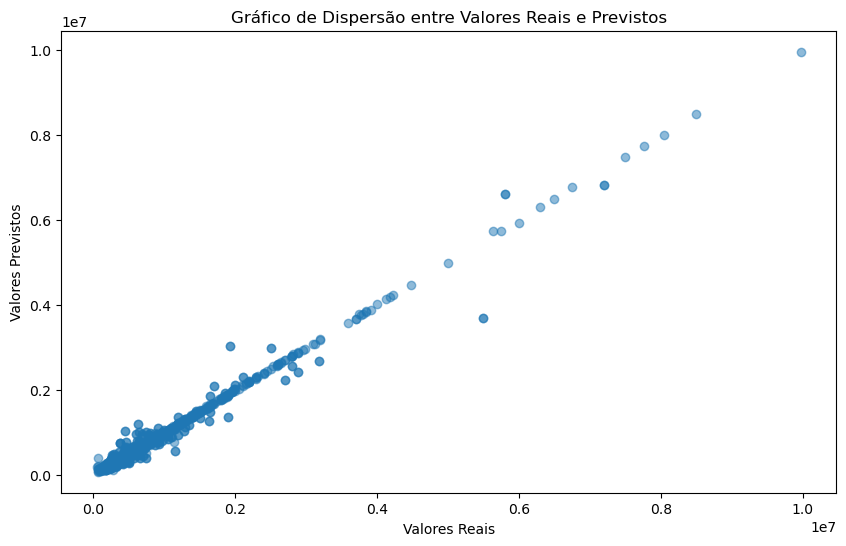

In [115]:
# Gráfico de dispersão

GraficoDispersao(teste_base_venda[vars_resp], y_pred_final, 'Gráfico de Dispersão entre Valores Reais e Previstos', 'Valores Reais', 'Valores Previstos')

# **Cross - Validation**

In [116]:
lgbm_reg = lgb.LGBMRegressor()
lgbm_scores = cross_val_score(lgbm_reg, treino_base_venda[vars_exp], treino_base_venda[vars_resp], scoring="neg_mean_squared_error", cv=10)

lgbm_rmse_scores = np.sqrt(-lgbm_scores)

display_scores(lgbm_rmse_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 14
[LightGBM] [Info] Start training from score 615851.840278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 9073, number of used features: 14
[LightGBM] [Info] Start training from score 624626.820236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

**Guardando a versão final do modelo escolhido**

In [117]:
import pickle
pickle.dump(final_model, open('modelo_venda.pkl', 'wb'))

# 🤖 3.6 Modelagem Estatística - LightGBM - Aluguel

In [118]:
# Função de otimização do Optuna
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 42,
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp])
    y_pred = model.predict(teste_base_aluguel[vars_exp])
    rmse = np.sqrt(mean_squared_error(teste_base_aluguel[vars_resp], y_pred))
    return rmse

# Estudo do Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4144846542322024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4144846542322024
[LightGBM] [Warning] lambda_l2 is set=0.13816894179849917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13816894179849917
[LightGBM] [Warning] lambda_l1 is set=0.3773259637640795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3773259637640795
[LightGBM] [Warning] bagging_fraction is set=0.7045655092020373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045655092020373
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4144846542322024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4144846542322024
[LightGBM] [Warning] lambda_l2 is set=0.13816894179849917, r

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6472375076004506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472375076004506
[LightGBM] [Warning] lambda_l2 is set=2.837058754933669e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.837058754933669e-07
[LightGBM] [Warning] lambda_l1 is set=1.1847072990060939e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1847072990060939e-05
[LightGBM] [Warning] bagging_fraction is set=0.4542214166559413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4542214166559413
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6472375076004506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472375076004506
[LightGBM] [Warning] lambda_l2 is set=2.83705875

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5273883144978345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5273883144978345
[LightGBM] [Warning] lambda_l2 is set=0.0002140706913112872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002140706913112872
[LightGBM] [Warning] lambda_l1 is set=9.338261318293518e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.338261318293518e-08
[LightGBM] [Warning] bagging_fraction is set=0.22368158507149838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22368158507149838
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5273883144978345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5273883144978345
[LightGBM] [Warning] lambda_l2 is set=0.00021407

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4634228625184933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4634228625184933
[LightGBM] [Warning] lambda_l2 is set=0.15684131109298136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15684131109298136
[LightGBM] [Warning] lambda_l1 is set=9.539063297648701e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.539063297648701e-06
[LightGBM] [Warning] bagging_fraction is set=0.3010605100951754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3010605100951754
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4634228625184933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4634228625184933
[LightGBM] [Warning] lambda_l2 is set=0.15684131109298

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2961431207837477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2961431207837477
[LightGBM] [Warning] lambda_l2 is set=0.03433985907285221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03433985907285221
[LightGBM] [Warning] lambda_l1 is set=0.0007958062244295974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007958062244295974
[LightGBM] [Warning] bagging_fraction is set=0.32070866010559884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32070866010559884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2961431207837477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2961431207837477
[LightGBM] [Warning] lambda_l2 is set=0.034339859072

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.77657009166336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77657009166336
[LightGBM] [Warning] lambda_l2 is set=6.974969461347637e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.974969461347637e-08
[LightGBM] [Warning] lambda_l1 is set=3.349461946940055e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.349461946940055e-08
[LightGBM] [Warning] bagging_fraction is set=0.7470189937387169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7470189937387169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.77657009166336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77657009166336
[LightGBM] [Warning] lambda_l2 is set=6.974969461347637e-0

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.19167321131982523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19167321131982523
[LightGBM] [Warning] lambda_l2 is set=8.542458296861346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.542458296861346
[LightGBM] [Warning] lambda_l1 is set=1.6967657871460717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6967657871460717
[LightGBM] [Warning] bagging_fraction is set=0.9305278394849846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9305278394849846
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.19167321131982523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19167321131982523
[LightGBM] [Warning] lambda_l2 is set=8.542458296861346,

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.45935289778116045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45935289778116045
[LightGBM] [Warning] lambda_l2 is set=0.004653685533649485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004653685533649485
[LightGBM] [Warning] lambda_l1 is set=0.036655035301232534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036655035301232534
[LightGBM] [Warning] bagging_fraction is set=0.7767058685854266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7767058685854266
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.45935289778116045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45935289778116045
[LightGBM] [Warning] lambda_l2 is set=0.0046536855

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5881183267350839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881183267350839
[LightGBM] [Warning] lambda_l2 is set=1.1586253883495936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1586253883495936
[LightGBM] [Warning] lambda_l1 is set=8.856892536045361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.856892536045361
[LightGBM] [Warning] bagging_fraction is set=0.6371587457003839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6371587457003839
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5881183267350839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881183267350839
[LightGBM] [Warning] lambda_l2 is set=1.1586253883495936, reg_la

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.37632206586534833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37632206586534833
[LightGBM] [Warning] lambda_l2 is set=0.25173531854412323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25173531854412323
[LightGBM] [Warning] lambda_l1 is set=0.020779575335349177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020779575335349177
[LightGBM] [Warning] bagging_fraction is set=0.9985547330148535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985547330148535
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.37632206586534833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37632206586534833
[LightGBM] [Warning] lambda_l2 is set=0.251735318544

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5872081022518706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5872081022518706
[LightGBM] [Warning] lambda_l2 is set=3.81275546271543e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.81275546271543e-05
[LightGBM] [Warning] lambda_l1 is set=0.006193845805972966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006193845805972966
[LightGBM] [Warning] bagging_fraction is set=0.6249131727344114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6249131727344114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 11228, number of used features: 13
[LightGBM] [Info] Start trai

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.26721797546948817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26721797546948817
[LightGBM] [Warning] lambda_l2 is set=0.0029058162861872404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029058162861872404
[LightGBM] [Warning] lambda_l1 is set=0.23028103032441938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23028103032441938
[LightGBM] [Warning] bagging_fraction is set=0.8527272013909274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8527272013909274
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.26721797546948817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26721797546948817
[LightGBM] [Warning] lambda_l2 is set=0.0029058162

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4446807562418593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4446807562418593
[LightGBM] [Warning] lambda_l2 is set=1.1961418234265224e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1961418234265224e-08
[LightGBM] [Warning] lambda_l1 is set=0.0037743804929897514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037743804929897514
[LightGBM] [Warning] bagging_fraction is set=0.6394241465731065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6394241465731065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4446807562418593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4446807562418593
[LightGBM] [Warning] lambda_l2 is set=1.19614182

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6662260514760834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6662260514760834
[LightGBM] [Warning] lambda_l2 is set=1.4477137996191674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4477137996191674
[LightGBM] [Warning] lambda_l1 is set=0.01629547838883982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01629547838883982
[LightGBM] [Warning] bagging_fraction is set=0.831321648845774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.831321648845774
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6662260514760834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6662260514760834
[LightGBM] [Warning] lambda_l2 is set=1.4477137996191674, reg_

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.34908111053269364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34908111053269364
[LightGBM] [Warning] lambda_l2 is set=0.02314239810833615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02314239810833615
[LightGBM] [Warning] lambda_l1 is set=0.007190654436127477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007190654436127477
[LightGBM] [Warning] bagging_fraction is set=0.980335552530327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.980335552530327
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.34908111053269364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34908111053269364
[LightGBM] [Warning] lambda_l2 is set=0.02314239810833

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.31706180965847536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31706180965847536
[LightGBM] [Warning] lambda_l2 is set=0.0010302923563065228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010302923563065228
[LightGBM] [Warning] lambda_l1 is set=0.21230499337407152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21230499337407152
[LightGBM] [Warning] bagging_fraction is set=0.9109850697497556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9109850697497556
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.31706180965847536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31706180965847536
[LightGBM] [Warning] lambda_l2 is set=0.0010302923

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40188635652460025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40188635652460025
[LightGBM] [Warning] lambda_l2 is set=0.8653702495738641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8653702495738641
[LightGBM] [Warning] lambda_l1 is set=0.0016668647956254302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016668647956254302
[LightGBM] [Warning] bagging_fraction is set=0.703153098092614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.703153098092614
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40188635652460025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40188635652460025
[LightGBM] [Warning] lambda_l2 is set=0.86537024957386

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5114841541955445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5114841541955445
[LightGBM] [Warning] lambda_l2 is set=0.012659476510849768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012659476510849768
[LightGBM] [Warning] lambda_l1 is set=0.034426255382107335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.034426255382107335
[LightGBM] [Warning] bagging_fraction is set=0.814254589017323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814254589017323
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5114841541955445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5114841541955445
[LightGBM] [Warning] lambda_l2 is set=0.0126594765108497

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.25742812126158854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25742812126158854
[LightGBM] [Warning] lambda_l2 is set=0.21662346652875653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21662346652875653
[LightGBM] [Warning] lambda_l1 is set=0.00013776627417694387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013776627417694387
[LightGBM] [Warning] bagging_fraction is set=0.8917796002317592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8917796002317592
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.25742812126158854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25742812126158854
[LightGBM] [Warning] lambda_l2 is set=0.21662346

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.39157521229837067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39157521229837067
[LightGBM] [Warning] lambda_l2 is set=0.04580314055917526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04580314055917526
[LightGBM] [Warning] lambda_l1 is set=0.013051190250762266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013051190250762266
[LightGBM] [Warning] bagging_fraction is set=0.817007339200297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.817007339200297
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.39157521229837067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39157521229837067
[LightGBM] [Warning] lambda_l2 is set=0.04580314055917

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4793032909162723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4793032909162723
[LightGBM] [Warning] lambda_l2 is set=0.024053331104557134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024053331104557134
[LightGBM] [Warning] lambda_l1 is set=0.0024400054797641744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024400054797641744
[LightGBM] [Warning] bagging_fraction is set=0.7732193087740895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732193087740895
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4793032909162723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4793032909162723
[LightGBM] [Warning] lambda_l2 is set=0.024053331104

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4401181599473868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4401181599473868
[LightGBM] [Warning] lambda_l2 is set=0.029089456838947664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029089456838947664
[LightGBM] [Warning] lambda_l1 is set=0.0003296443496827957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003296443496827957
[LightGBM] [Warning] bagging_fraction is set=0.697343489517239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.697343489517239
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4401181599473868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4401181599473868
[LightGBM] [Warning] lambda_l2 is set=0.0290894568

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4780428240720779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4780428240720779
[LightGBM] [Warning] lambda_l2 is set=0.052807913316985436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.052807913316985436
[LightGBM] [Warning] lambda_l1 is set=0.010693388197596517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010693388197596517
[LightGBM] [Warning] bagging_fraction is set=0.6794768116328479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6794768116328479
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4780428240720779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4780428240720779
[LightGBM] [Warning] lambda_l2 is set=0.05280791331698

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5583243130141766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5583243130141766
[LightGBM] [Warning] lambda_l2 is set=0.001364827399755974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001364827399755974
[LightGBM] [Warning] lambda_l1 is set=0.002595748560508762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002595748560508762
[LightGBM] [Warning] bagging_fraction is set=0.7865014310738622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7865014310738622
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5583243130141766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5583243130141766
[LightGBM] [Warning] lambda_l2 is set=0.00136482739975

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5821526927116516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821526927116516
[LightGBM] [Warning] lambda_l2 is set=0.01020898743226353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01020898743226353
[LightGBM] [Warning] lambda_l1 is set=0.0001297190898355213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001297190898355213
[LightGBM] [Warning] bagging_fraction is set=0.7980320532038963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980320532038963
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5821526927116516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821526927116516
[LightGBM] [Warning] lambda_l2 is set=0.01020898743226

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6013805942483024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013805942483024
[LightGBM] [Warning] lambda_l2 is set=0.01683084446212701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01683084446212701
[LightGBM] [Warning] lambda_l1 is set=0.11794259676842359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11794259676842359
[LightGBM] [Warning] bagging_fraction is set=0.8130743584835397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130743584835397
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6013805942483024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013805942483024
[LightGBM] [Warning] lambda_l2 is set=0.01683084446212701,

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5994117013083077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5994117013083077
[LightGBM] [Warning] lambda_l2 is set=0.02851321385010139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02851321385010139
[LightGBM] [Warning] lambda_l1 is set=0.00012097916937896935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012097916937896935
[LightGBM] [Warning] bagging_fraction is set=0.8306943006054985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306943006054985
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5994117013083077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5994117013083077
[LightGBM] [Warning] lambda_l2 is set=0.028513213850

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6463728249567842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6463728249567842
[LightGBM] [Warning] lambda_l2 is set=0.0118452168290376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0118452168290376
[LightGBM] [Warning] lambda_l1 is set=0.00010196999831692312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010196999831692312
[LightGBM] [Warning] bagging_fraction is set=0.8779177302578771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8779177302578771
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6463728249567842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6463728249567842
[LightGBM] [Warning] lambda_l2 is set=0.01184521682903

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.64925925734137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64925925734137
[LightGBM] [Warning] lambda_l2 is set=0.010497815280196223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010497815280196223
[LightGBM] [Warning] lambda_l1 is set=4.157303473668315e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.157303473668315e-05
[LightGBM] [Warning] bagging_fraction is set=0.8821493590321263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8821493590321263
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.64925925734137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64925925734137
[LightGBM] [Warning] lambda_l2 is set=0.010497815280196223, 

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6595926692919863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6595926692919863
[LightGBM] [Warning] lambda_l2 is set=0.0005044861037988797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005044861037988797
[LightGBM] [Warning] lambda_l1 is set=4.498328337280472e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.498328337280472e-05
[LightGBM] [Warning] bagging_fraction is set=0.9363375322332936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9363375322332936
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6595926692919863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6595926692919863
[LightGBM] [Warning] lambda_l2 is set=0.0005044861

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6921497757625276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6921497757625276
[LightGBM] [Warning] lambda_l2 is set=0.005964120259800565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005964120259800565
[LightGBM] [Warning] lambda_l1 is set=3.917320893572491e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.917320893572491e-06
[LightGBM] [Warning] bagging_fraction is set=0.8916977287526215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8916977287526215
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6921497757625276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6921497757625276
[LightGBM] [Warning] lambda_l2 is set=0.005964120259

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8534453494034449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8534453494034449
[LightGBM] [Warning] lambda_l2 is set=6.22490690812915e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.22490690812915e-05
[LightGBM] [Warning] lambda_l1 is set=3.0060888075449744e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0060888075449744e-05
[LightGBM] [Warning] bagging_fraction is set=0.7537276551679553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7537276551679553
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8534453494034449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8534453494034449
[LightGBM] [Warning] lambda_l2 is set=6.2249069081

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8834000594710629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8834000594710629
[LightGBM] [Warning] lambda_l2 is set=0.0001026348950479519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001026348950479519
[LightGBM] [Warning] lambda_l1 is set=2.2135337973924052e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2135337973924052e-05
[LightGBM] [Warning] bagging_fraction is set=0.8849117847089711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849117847089711
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8834000594710629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8834000594710629
[LightGBM] [Warning] lambda_l2 is set=0.00010263

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8715621491227131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8715621491227131
[LightGBM] [Warning] lambda_l2 is set=7.664684308229172e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.664684308229172e-05
[LightGBM] [Warning] lambda_l1 is set=2.405400898976636e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.405400898976636e-05
[LightGBM] [Warning] bagging_fraction is set=0.86055012206042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86055012206042
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8715621491227131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8715621491227131
[LightGBM] [Warning] lambda_l2 is set=7.66468430822917

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9117648211388042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9117648211388042
[LightGBM] [Warning] lambda_l2 is set=8.470351648996677e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.470351648996677e-05
[LightGBM] [Warning] lambda_l1 is set=2.2785870445130535e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2785870445130535e-05
[LightGBM] [Warning] bagging_fraction is set=0.8692432926193299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8692432926193299
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9117648211388042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9117648211388042
[LightGBM] [Warning] lambda_l2 is set=8.47035164

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9141295993998979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9141295993998979
[LightGBM] [Warning] lambda_l2 is set=8.523125948413916e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.523125948413916e-05
[LightGBM] [Warning] lambda_l1 is set=2.3671836336000913e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3671836336000913e-06
[LightGBM] [Warning] bagging_fraction is set=0.9353012971251837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353012971251837
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9141295993998979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9141295993998979
[LightGBM] [Warning] lambda_l2 is set=8.52312594

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8893005460517626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8893005460517626
[LightGBM] [Warning] lambda_l2 is set=9.267531008609955e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.267531008609955e-06
[LightGBM] [Warning] lambda_l1 is set=2.1570274637935476e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1570274637935476e-05
[LightGBM] [Warning] bagging_fraction is set=0.8738540636214488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738540636214488
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8893005460517626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8893005460517626
[LightGBM] [Warning] lambda_l2 is set=9.26753100

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9948974951218236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9948974951218236
[LightGBM] [Warning] lambda_l2 is set=8.596191787995463e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.596191787995463e-05
[LightGBM] [Warning] lambda_l1 is set=1.2655514296710622e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2655514296710622e-06
[LightGBM] [Warning] bagging_fraction is set=0.7480515901836722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480515901836722
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9948974951218236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9948974951218236
[LightGBM] [Warning] lambda_l2 is set=8.59619178

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8240748678778659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8240748678778659
[LightGBM] [Warning] lambda_l2 is set=6.573267778658654e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.573267778658654e-06
[LightGBM] [Warning] lambda_l1 is set=1.9296266318568303e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9296266318568303e-05
[LightGBM] [Warning] bagging_fraction is set=0.9641778640734611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9641778640734611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8240748678778659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8240748678778659
[LightGBM] [Warning] lambda_l2 is set=6.57326777

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8313453837580475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8313453837580475
[LightGBM] [Warning] lambda_l2 is set=0.00021026038386782298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021026038386782298
[LightGBM] [Warning] lambda_l1 is set=8.703131277863544e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.703131277863544e-07
[LightGBM] [Warning] bagging_fraction is set=0.9342265090957818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9342265090957818
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8313453837580475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8313453837580475
[LightGBM] [Warning] lambda_l2 is set=0.00021026

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8415556830749275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415556830749275
[LightGBM] [Warning] lambda_l2 is set=0.00032206177465467223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032206177465467223
[LightGBM] [Warning] lambda_l1 is set=3.5183426490198945e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5183426490198945e-07
[LightGBM] [Warning] bagging_fraction is set=0.9424187290945913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424187290945913
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8415556830749275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415556830749275
[LightGBM] [Warning] lambda_l2 is set=0.000322

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.768795841447692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768795841447692
[LightGBM] [Warning] lambda_l2 is set=2.2689525920049486e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2689525920049486e-05
[LightGBM] [Warning] lambda_l1 is set=9.65141378879589e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.65141378879589e-06
[LightGBM] [Warning] bagging_fraction is set=0.9576633569571659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9576633569571659
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.768795841447692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768795841447692
[LightGBM] [Warning] lambda_l2 is set=2.26895259200494

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8465547786761093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8465547786761093
[LightGBM] [Warning] lambda_l2 is set=3.671435266446723e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.671435266446723e-06
[LightGBM] [Warning] lambda_l1 is set=8.944108924817383e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.944108924817383e-07
[LightGBM] [Warning] bagging_fraction is set=0.9219394376851009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9219394376851009
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8465547786761093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8465547786761093
[LightGBM] [Warning] lambda_l2 is set=3.6714352664

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8901932153548467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901932153548467
[LightGBM] [Warning] lambda_l2 is set=0.0002274534327933399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002274534327933399
[LightGBM] [Warning] lambda_l1 is set=3.521088052899304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.521088052899304e-05
[LightGBM] [Warning] bagging_fraction is set=0.8589853286958571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589853286958571
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8901932153548467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901932153548467
[LightGBM] [Warning] lambda_l2 is set=0.0002274534

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7823624832602798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7823624832602798
[LightGBM] [Warning] lambda_l2 is set=0.00020308414772132708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020308414772132708
[LightGBM] [Warning] lambda_l1 is set=7.040219690719261e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.040219690719261e-06
[LightGBM] [Warning] bagging_fraction is set=0.8999567399717147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8999567399717147
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7823624832602798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7823624832602798
[LightGBM] [Warning] lambda_l2 is set=0.00020308

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8804135151899564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8804135151899564
[LightGBM] [Warning] lambda_l2 is set=0.0007588128202314998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007588128202314998
[LightGBM] [Warning] lambda_l1 is set=4.8716019850166e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8716019850166e-05
[LightGBM] [Warning] bagging_fraction is set=0.8609126114311153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8609126114311153
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8804135151899564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8804135151899564
[LightGBM] [Warning] lambda_l2 is set=0.00075881282023

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9650424014547692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9650424014547692
[LightGBM] [Warning] lambda_l2 is set=0.00020532956176708147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020532956176708147
[LightGBM] [Warning] lambda_l1 is set=1.2629391970278345e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2629391970278345e-05
[LightGBM] [Warning] bagging_fraction is set=0.8488124781918797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8488124781918797
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9650424014547692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9650424014547692
[LightGBM] [Warning] lambda_l2 is set=0.000205

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9396684555334636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9396684555334636
[LightGBM] [Warning] lambda_l2 is set=2.4259164897395227e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4259164897395227e-05
[LightGBM] [Warning] lambda_l1 is set=0.0004343480915502935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004343480915502935
[LightGBM] [Warning] bagging_fraction is set=0.7590612088471018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7590612088471018
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9396684555334636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9396684555334636
[LightGBM] [Warning] lambda_l2 is set=2.42591648

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8740882624878175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8740882624878175
[LightGBM] [Warning] lambda_l2 is set=0.0017326746950061512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017326746950061512
[LightGBM] [Warning] lambda_l1 is set=5.1750406019771345e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1750406019771345e-06
[LightGBM] [Warning] bagging_fraction is set=0.9793263997030468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793263997030468
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8740882624878175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8740882624878175
[LightGBM] [Warning] lambda_l2 is set=0.00173267

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7960419888603192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7960419888603192
[LightGBM] [Warning] lambda_l2 is set=0.0005118485414904747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005118485414904747
[LightGBM] [Warning] lambda_l1 is set=5.07807257135156e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.07807257135156e-05
[LightGBM] [Warning] bagging_fraction is set=0.9028432851925817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9028432851925817
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7960419888603192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7960419888603192
[LightGBM] [Warning] lambda_l2 is set=0.000511848541

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7503865271694043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7503865271694043
[LightGBM] [Warning] lambda_l2 is set=4.6687971728301166e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6687971728301166e-05
[LightGBM] [Warning] lambda_l1 is set=0.0002060589509556995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002060589509556995
[LightGBM] [Warning] bagging_fraction is set=0.8365005357821715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365005357821715
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7503865271694043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7503865271694043
[LightGBM] [Warning] lambda_l2 is set=4.66879717

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.76558147886899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76558147886899
[LightGBM] [Warning] lambda_l2 is set=6.262709472641922e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.262709472641922e-05
[LightGBM] [Warning] lambda_l1 is set=0.0007671421473528855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007671421473528855
[LightGBM] [Warning] bagging_fraction is set=0.737202363044609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.737202363044609
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.76558147886899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76558147886899
[LightGBM] [Warning] lambda_l2 is set=6.262709472641922e-05,

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7297485849783618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7297485849783618
[LightGBM] [Warning] lambda_l2 is set=2.0324308147816102e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0324308147816102e-05
[LightGBM] [Warning] lambda_l1 is set=1.0621968224095534e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0621968224095534e-05
[LightGBM] [Warning] bagging_fraction is set=0.8327059724959298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8327059724959298
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7297485849783618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7297485849783618
[LightGBM] [Warning] lambda_l2 is set=2.032430

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8180451325889283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8180451325889283
[LightGBM] [Warning] lambda_l2 is set=0.0001986949008684188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001986949008684188
[LightGBM] [Warning] lambda_l1 is set=0.00025413051845029266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025413051845029266
[LightGBM] [Warning] bagging_fraction is set=0.789937532891271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789937532891271
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8180451325889283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8180451325889283
[LightGBM] [Warning] lambda_l2 is set=0.0001986949

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8611502349960977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8611502349960977
[LightGBM] [Warning] lambda_l2 is set=0.00013240402101499397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013240402101499397
[LightGBM] [Warning] lambda_l1 is set=2.6391712377493216e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6391712377493216e-05
[LightGBM] [Warning] bagging_fraction is set=0.9275225446508919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9275225446508919
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8611502349960977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8611502349960977
[LightGBM] [Warning] lambda_l2 is set=0.000132

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8060872792519806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8060872792519806
[LightGBM] [Warning] lambda_l2 is set=5.4912164467703134e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4912164467703134e-05
[LightGBM] [Warning] lambda_l1 is set=7.072362524104048e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.072362524104048e-05
[LightGBM] [Warning] bagging_fraction is set=0.8477682517453127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8477682517453127
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8060872792519806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8060872792519806
[LightGBM] [Warning] lambda_l2 is set=5.49121644

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8377852515394574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8377852515394574
[LightGBM] [Warning] lambda_l2 is set=0.0003811789272622515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003811789272622515
[LightGBM] [Warning] lambda_l1 is set=0.00018412971469642406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018412971469642406
[LightGBM] [Warning] bagging_fraction is set=0.9035095036354138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9035095036354138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8377852515394574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8377852515394574
[LightGBM] [Warning] lambda_l2 is set=0.00038117

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.751458526241958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751458526241958
[LightGBM] [Warning] lambda_l2 is set=0.00218153936720919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00218153936720919
[LightGBM] [Warning] lambda_l1 is set=0.00024822812280090537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024822812280090537
[LightGBM] [Warning] bagging_fraction is set=0.9572751780946079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9572751780946079
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.751458526241958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751458526241958
[LightGBM] [Warning] lambda_l2 is set=0.0021815393672091

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7433617682307305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7433617682307305
[LightGBM] [Warning] lambda_l2 is set=0.0017997968384214323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017997968384214323
[LightGBM] [Warning] lambda_l1 is set=0.0005002480688314029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005002480688314029
[LightGBM] [Warning] bagging_fraction is set=0.9550084327926762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9550084327926762
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7994511987657211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7994511987657211
[LightGBM] [Warning] lambda_l2 is set=0.0026997942

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7994511987657211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7994511987657211
[LightGBM] [Warning] lambda_l2 is set=0.0026997942735303075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026997942735303075
[LightGBM] [Warning] lambda_l1 is set=7.467386588849354e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.467386588849354e-05
[LightGBM] [Warning] bagging_fraction is set=0.9745301485318889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9745301485318889
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.705911421746218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705911421746218
[LightGBM] [Warning] lambda_l2 is set=0.004152688128

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.705911421746218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.705911421746218
[LightGBM] [Warning] lambda_l2 is set=0.004152688128271445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004152688128271445
[LightGBM] [Warning] lambda_l1 is set=0.00022574365684877392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022574365684877392
[LightGBM] [Warning] bagging_fraction is set=0.982531832547644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.982531832547644
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7606866567841661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606866567841661
[LightGBM] [Warning] lambda_l2 is set=0.00047021811613

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7606866567841661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606866567841661
[LightGBM] [Warning] lambda_l2 is set=0.0004702181161328715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004702181161328715
[LightGBM] [Warning] lambda_l1 is set=0.000999470539557765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000999470539557765
[LightGBM] [Warning] bagging_fraction is set=0.9936882513327305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9936882513327305
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8012294464204444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8012294464204444
[LightGBM] [Warning] lambda_l2 is set=0.002954732481

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8012294464204444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8012294464204444
[LightGBM] [Warning] lambda_l2 is set=0.0029547324815008946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029547324815008946
[LightGBM] [Warning] lambda_l1 is set=8.06284226447989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.06284226447989e-05
[LightGBM] [Warning] bagging_fraction is set=0.9628116245362192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628116245362192
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.799932446588849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.799932446588849
[LightGBM] [Warning] lambda_l2 is set=0.00298267077375

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.799932446588849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.799932446588849
[LightGBM] [Warning] lambda_l2 is set=0.0029826707737516034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029826707737516034
[LightGBM] [Warning] lambda_l1 is set=0.0002850641120883587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002850641120883587
[LightGBM] [Warning] bagging_fraction is set=0.9630267821089648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9630267821089648
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7450119738753171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450119738753171
[LightGBM] [Warning] lambda_l2 is set=0.000716469181

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7450119738753171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450119738753171
[LightGBM] [Warning] lambda_l2 is set=0.0007164691817831975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007164691817831975
[LightGBM] [Warning] lambda_l1 is set=6.705236100609219e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.705236100609219e-05
[LightGBM] [Warning] bagging_fraction is set=0.9302346448265477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9302346448265477
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8198216995900226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8198216995900226
[LightGBM] [Warning] lambda_l2 is set=0.0023804872

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8198216995900226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8198216995900226
[LightGBM] [Warning] lambda_l2 is set=0.002380487285590806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002380487285590806
[LightGBM] [Warning] lambda_l1 is set=8.68877129890106e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.68877129890106e-05
[LightGBM] [Warning] bagging_fraction is set=0.9029976398270352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029976398270352
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8195019416858912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8195019416858912
[LightGBM] [Warning] lambda_l2 is set=0.00079739908839

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8195019416858912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8195019416858912
[LightGBM] [Warning] lambda_l2 is set=0.0007973990883972243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007973990883972243
[LightGBM] [Warning] lambda_l1 is set=8.457635020823066e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.457635020823066e-05
[LightGBM] [Warning] bagging_fraction is set=0.9053471007168001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9053471007168001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7876981576102886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7876981576102886
[LightGBM] [Warning] lambda_l2 is set=0.0011255447

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7876981576102886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7876981576102886
[LightGBM] [Warning] lambda_l2 is set=0.0011255447298707737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011255447298707737
[LightGBM] [Warning] lambda_l1 is set=0.00012862887060281528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012862887060281528
[LightGBM] [Warning] bagging_fraction is set=0.894483161844698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.894483161844698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7231469648413981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7231469648413981
[LightGBM] [Warning] lambda_l2 is set=0.0078343529

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7231469648413981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7231469648413981
[LightGBM] [Warning] lambda_l2 is set=0.007834352903096534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007834352903096534
[LightGBM] [Warning] lambda_l1 is set=4.170662429283449e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.170662429283449e-05
[LightGBM] [Warning] bagging_fraction is set=0.9995480488343271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995480488343271
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8530042943867878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8530042943867878
[LightGBM] [Warning] lambda_l2 is set=0.004315957783

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8530042943867878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8530042943867878
[LightGBM] [Warning] lambda_l2 is set=0.004315957783177727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004315957783177727
[LightGBM] [Warning] lambda_l1 is set=1.4716400642789099e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4716400642789099e-05
[LightGBM] [Warning] bagging_fraction is set=0.8093624001257727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8093624001257727
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8327493659189157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8327493659189157
[LightGBM] [Warning] lambda_l2 is set=0.0029601431

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8327493659189157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8327493659189157
[LightGBM] [Warning] lambda_l2 is set=0.002960143172746501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002960143172746501
[LightGBM] [Warning] lambda_l1 is set=7.376299872006516e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.376299872006516e-05
[LightGBM] [Warning] bagging_fraction is set=0.8818554299761683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8818554299761683
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.780001837068178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.780001837068178
[LightGBM] [Warning] lambda_l2 is set=0.00934587201590

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.780001837068178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.780001837068178
[LightGBM] [Warning] lambda_l2 is set=0.00934587201590334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00934587201590334
[LightGBM] [Warning] lambda_l1 is set=0.0001458656996485554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001458656996485554
[LightGBM] [Warning] bagging_fraction is set=0.9140509931963061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140509931963061


/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8095963093039102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095963093039102
[LightGBM] [Warning] lambda_l2 is set=0.00013110538079436464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013110538079436464
[LightGBM] [Warning] lambda_l1 is set=3.1744128538068366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1744128538068366e-05
[LightGBM] [Warning] bagging_fraction is set=0.9356386287810877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9356386287810877
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8095963093039102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095963093039102
[LightGBM] [Warning] lambda_l2 is set=0.000131

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8561130031664426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561130031664426
[LightGBM] [Warning] lambda_l2 is set=0.001267191693889442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001267191693889442
[LightGBM] [Warning] lambda_l1 is set=1.8664235140578805e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8664235140578805e-05
[LightGBM] [Warning] bagging_fraction is set=0.8352471959948128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8352471959948128
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8407345941374706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407345941374706
[LightGBM] [Warning] lambda_l2 is set=0.0034780874

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8407345941374706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407345941374706
[LightGBM] [Warning] lambda_l2 is set=0.003478087464414848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003478087464414848
[LightGBM] [Warning] lambda_l1 is set=1.1854342242743936e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1854342242743936e-05
[LightGBM] [Warning] bagging_fraction is set=0.8092701889185169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092701889185169
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8674646763526124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8674646763526124
[LightGBM] [Warning] lambda_l2 is set=0.0156057689

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8674646763526124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8674646763526124
[LightGBM] [Warning] lambda_l2 is set=0.015605768908737033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015605768908737033
[LightGBM] [Warning] lambda_l1 is set=1.5938686881828856e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5938686881828856e-05
[LightGBM] [Warning] bagging_fraction is set=0.878947281889759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.878947281889759
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9151382700953787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9151382700953787
[LightGBM] [Warning] lambda_l2 is set=0.001598144984

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9151382700953787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9151382700953787
[LightGBM] [Warning] lambda_l2 is set=0.0015981449843392107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015981449843392107
[LightGBM] [Warning] lambda_l1 is set=4.95661901590887e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.95661901590887e-06
[LightGBM] [Warning] bagging_fraction is set=0.7970656594841569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7970656594841569
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9061956355650433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061956355650433
[LightGBM] [Warning] lambda_l2 is set=0.006695583901

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9061956355650433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061956355650433
[LightGBM] [Warning] lambda_l2 is set=0.006695583901329773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006695583901329773
[LightGBM] [Warning] lambda_l1 is set=2.6597614634656115e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6597614634656115e-06
[LightGBM] [Warning] bagging_fraction is set=0.918534423458495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.918534423458495


/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9320989120473215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9320989120473215
[LightGBM] [Warning] lambda_l2 is set=0.0019832520657814224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019832520657814224
[LightGBM] [Warning] lambda_l1 is set=3.4206637805306695e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4206637805306695e-05
[LightGBM] [Warning] bagging_fraction is set=0.7704622331612749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704622331612749
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9320989120473215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9320989120473215
[LightGBM] [Warning] lambda_l2 is set=0.00198325

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7862498961280767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7862498961280767
[LightGBM] [Warning] lambda_l2 is set=0.0008575162143438848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008575162143438848
[LightGBM] [Warning] lambda_l1 is set=5.4094109603362875e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4094109603362875e-06
[LightGBM] [Warning] bagging_fraction is set=0.7836515513155606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7836515513155606
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7862498961280767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7862498961280767
[LightGBM] [Warning] lambda_l2 is set=0.00085751

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8961465607182597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8961465607182597
[LightGBM] [Warning] lambda_l2 is set=3.963655992786552e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.963655992786552e-05
[LightGBM] [Warning] lambda_l1 is set=8.135576007970765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.135576007970765e-06
[LightGBM] [Warning] bagging_fraction is set=0.8380646735572351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8380646735572351


/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8991767377155664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8991767377155664
[LightGBM] [Warning] lambda_l2 is set=0.0001274808442106247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001274808442106247
[LightGBM] [Warning] lambda_l1 is set=2.135712065482902e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.135712065482902e-06
[LightGBM] [Warning] bagging_fraction is set=0.8258209081126522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8258209081126522
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8991767377155664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8991767377155664
[LightGBM] [Warning] lambda_l2 is set=0.0001274808

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8854679070618814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854679070618814
[LightGBM] [Warning] lambda_l2 is set=3.513450218437642e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.513450218437642e-05
[LightGBM] [Warning] lambda_l1 is set=8.768322506257722e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.768322506257722e-06
[LightGBM] [Warning] bagging_fraction is set=0.7271825990834222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7271825990834222
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8854679070618814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854679070618814
[LightGBM] [Warning] lambda_l2 is set=3.5134502184

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.934737821096283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.934737821096283
[LightGBM] [Warning] lambda_l2 is set=0.00038861342737590273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038861342737590273
[LightGBM] [Warning] lambda_l1 is set=9.330481511822643e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.330481511822643e-05
[LightGBM] [Warning] bagging_fraction is set=0.8762531201580234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8762531201580234
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.934737821096283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.934737821096283
[LightGBM] [Warning] lambda_l2 is set=0.000388613427

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8245935230070826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8245935230070826
[LightGBM] [Warning] lambda_l2 is set=5.0628777561840704e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0628777561840704e-05
[LightGBM] [Warning] lambda_l1 is set=8.42097077257383e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.42097077257383e-06
[LightGBM] [Warning] bagging_fraction is set=0.8421849598265713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8421849598265713
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8245935230070826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8245935230070826
[LightGBM] [Warning] lambda_l2 is set=5.0628777561

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.917528071609012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.917528071609012
[LightGBM] [Warning] lambda_l2 is set=0.0012942144280017574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012942144280017574
[LightGBM] [Warning] lambda_l1 is set=6.536692388540439e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.536692388540439e-05
[LightGBM] [Warning] bagging_fraction is set=0.9431738960419188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9431738960419188


/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9131019787095246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9131019787095246
[LightGBM] [Warning] lambda_l2 is set=0.005313578232426062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005313578232426062
[LightGBM] [Warning] lambda_l1 is set=4.8400765362626673e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8400765362626673e-05
[LightGBM] [Warning] bagging_fraction is set=0.9459606612755213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9459606612755213
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9131019787095246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9131019787095246
[LightGBM] [Warning] lambda_l2 is set=0.0053135782

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9609287308044538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9609287308044538
[LightGBM] [Warning] lambda_l2 is set=0.0002809344955127882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002809344955127882
[LightGBM] [Warning] lambda_l1 is set=2.666769210631222e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.666769210631222e-05
[LightGBM] [Warning] bagging_fraction is set=0.945895182380857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.945895182380857
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9609287308044538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9609287308044538
[LightGBM] [Warning] lambda_l2 is set=0.000280934495

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9002278912881231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002278912881231
[LightGBM] [Warning] lambda_l2 is set=0.006978337496764386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006978337496764386
[LightGBM] [Warning] lambda_l1 is set=5.1630060906382584e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1630060906382584e-05
[LightGBM] [Warning] bagging_fraction is set=0.8644484230933388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8644484230933388
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9002278912881231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002278912881231
[LightGBM] [Warning] lambda_l2 is set=0.0069783374

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8719401771086958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8719401771086958
[LightGBM] [Warning] lambda_l2 is set=0.0006006405056225181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006006405056225181
[LightGBM] [Warning] lambda_l1 is set=5.439154400279262e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.439154400279262e-06
[LightGBM] [Warning] bagging_fraction is set=0.9449304160211776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449304160211776
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8719401771086958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8719401771086958
[LightGBM] [Warning] lambda_l2 is set=0.0006006405

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9224122880114634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9224122880114634
[LightGBM] [Warning] lambda_l2 is set=0.0001243196490969683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001243196490969683
[LightGBM] [Warning] lambda_l1 is set=1.8168556599597873e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8168556599597873e-05
[LightGBM] [Warning] bagging_fraction is set=0.8812169811490499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8812169811490499
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9224122880114634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9224122880114634
[LightGBM] [Warning] lambda_l2 is set=0.00012431

/tmp/ipykernel_19394/1047994459.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_19394/1047994459.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_19394/1047994459.py:11: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9552908126088653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552908126088653
[LightGBM] [Warning] lambda_l2 is set=0.0012584419708201082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012584419708201082
[LightGBM] [Warning] lambda_l1 is set=0.00017426342400791536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017426342400791536
[LightGBM] [Warning] bagging_fraction is set=0.7972684836625832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7972684836625832
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9552908126088653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552908126088653
[LightGBM] [Warning] lambda_l2 is set=0.00125844

In [119]:
# Imprimindo os melhores parâmetros segundo o Optuna
best_params = study.best_params
print("Melhores Parâmetros:")
print(best_params)

Melhores Parâmetros:
{'lambda_l1': 4.95661901590887e-06, 'lambda_l2': 0.0015981449843392107, 'num_leaves': 161, 'feature_fraction': 0.9151382700953787, 'bagging_fraction': 0.7970656594841569, 'bagging_freq': 4, 'min_child_samples': 8, 'learning_rate': 0.10857348520441702, 'n_estimators': 471}


In [120]:
# Criando o modelo final com os melhores parâmetros
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp])

[LightGBM] [Warning] feature_fraction is set=0.9151382700953787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9151382700953787
[LightGBM] [Warning] lambda_l2 is set=0.0015981449843392107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015981449843392107
[LightGBM] [Warning] lambda_l1 is set=4.95661901590887e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.95661901590887e-06
[LightGBM] [Warning] bagging_fraction is set=0.7970656594841569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7970656594841569
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9151382700953787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9151382700953787
[LightGBM] [Warning] lambda_l2 is set=0.0015981449843392107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015981449843392107
[LightGBM] [Warning]

LGBMRegressor(bagging_fraction=0.7970656594841569, bagging_freq=4,
              feature_fraction=0.9151382700953787,
              lambda_l1=4.95661901590887e-06, lambda_l2=0.0015981449843392107,
              learning_rate=0.10857348520441702, min_child_samples=8,
              n_estimators=471, num_leaves=161)

In [121]:
#CONJUNTO TREINO

y_pred_final_treino = final_model.predict(treino_base_aluguel[vars_exp])

rmse_final_treino = np.sqrt(mean_squared_error(treino_base_aluguel[vars_resp], y_pred_final_treino))

print(f"Treino - RMSE do Modelo Final: {rmse_final_treino}")

#CONJUNTO TESTE

# Previsões com o modelo final
y_pred_final = final_model.predict(teste_base_aluguel[vars_exp])

# Calculando a métrica RMSE com o modelo final
rmse_final = np.sqrt(mean_squared_error(teste_base_aluguel[vars_resp], y_pred_final))
print(f"Teste - RMSE do Modelo Final: {rmse_final}")

[LightGBM] [Warning] feature_fraction is set=0.9151382700953787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9151382700953787
[LightGBM] [Warning] lambda_l2 is set=0.0015981449843392107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015981449843392107
[LightGBM] [Warning] lambda_l1 is set=4.95661901590887e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.95661901590887e-06
[LightGBM] [Warning] bagging_fraction is set=0.7970656594841569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7970656594841569
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Treino - RMSE do Modelo Final: 206.93958386682337
[LightGBM] [Warning] feature_fraction is set=0.9151382700953787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9151382700953787
[LightGBM] [Warning] lambda_l2 is set=0.0015981449843392107, reg_lambda=0.0 will be ignored. Current value: la

In [122]:
# Verificando a importância relativa de cada variável

importancias_variaveis = final_model.feature_importances_

df_aluguel_lgbm = pd.DataFrame({'Variável': vars_exp, 'Coeficiente': importancias_variaveis})
df_aluguel_lgbm.sort_values(by='Coeficiente', ascending=False)

Variável  Coeficiente
1                   size        24304
0                  condo        24081
2                  rooms         3706
3                toilets         3650
5                parking         3469
8          swimming_pool         2872
6               elevator         2749
13   district_zone_Oeste         2657
4                 suites         2103
7              furnished         2073
11   district_zone_Leste         1667
12   district_zone_Norte         1097
10  district_zone_Centro          918
9                    new           14

**Comentários:** as variáveis com mais importância (que mais foram utilizadas para tomar decisão) foram valor do condomínio, tamanho da propriedade e número de quartos. As variáveis que menos contribuiram foram se a propriedade é nova ou não

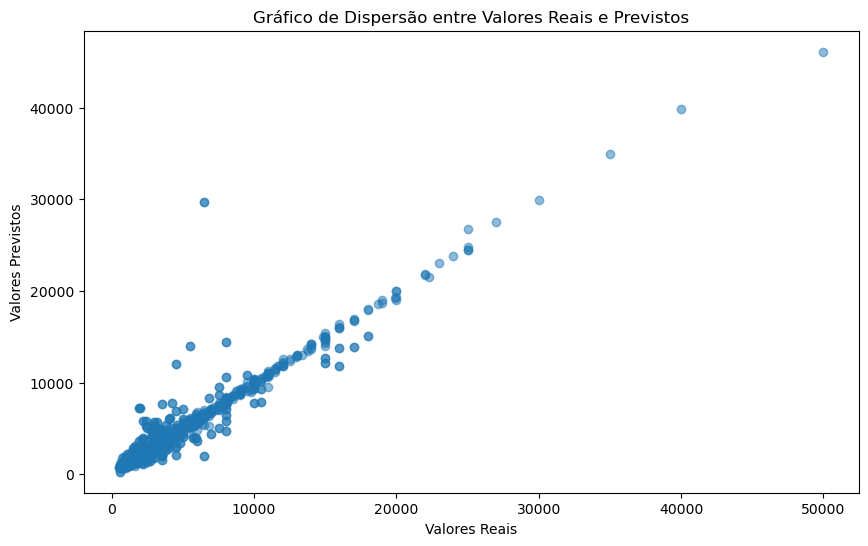

In [123]:
# Gráfico de dispersão

GraficoDispersao(teste_base_aluguel[vars_resp], y_pred_final, 'Gráfico de Dispersão entre Valores Reais e Previstos', 'Valores Reais', 'Valores Previstos')

# **Cross - Validation**

In [124]:
lgbm_reg = lgb.LGBMRegressor()
lgbm_scores = cross_val_score(lgbm_reg, treino_base_aluguel[vars_exp], treino_base_aluguel[vars_resp], scoring="neg_mean_squared_error", cv=10)

lgbm_rmse_scores = np.sqrt(-lgbm_scores)

display_scores(lgbm_rmse_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 10105, number of used features: 12
[LightGBM] [Info] Start training from score 3135.822662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 10105, number of used features: 13
[LightGBM] [Info] Start training from score 3257.042454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [125]:
import pickle
pickle.dump(final_model, open('modelo_aluguel.pkl', 'wb'))

# Salvando os pkl's no S3 de output

In [127]:
import os

notebook_directory = os.getcwd()

# Caminho completo para o arquivo pkl
modelo_venda_path = os.path.join(notebook_directory, 'modelo_venda.pkl')
modelo_aluguel_path = os.path.join(notebook_directory, 'modelo_aluguel.pkl')

# Carregue o modelo a partir do arquivo pkl
with open(modelo_venda_path, 'rb') as file:
    modelo_venda = pickle.load(file)
    
with open(modelo_aluguel_path, 'rb') as file:
    modelo_aluguel = pickle.load(file)    

# Serializar o modelo para um arquivo pickle
modelo_venda_pickle = pickle.dumps(modelo_venda)
modelo_aluguel_pickle = pickle.dumps(modelo_aluguel)


# Configurações do Amazon S3
bucket_name = 'output-modelo'

# Upload do arquivo pickle para o Amazon S3
s3_client = boto3.client('s3')
s3_client.put_object(Body=modelo_venda_pickle, Bucket=bucket_name, Key=modelo_venda_path)

{'ResponseMetadata': {'RequestId': 'V9JCJJH11QN3A8J8',
  'HostId': '02n2Nux5eXuWC3YCYzdY1uWCOQek0eJU+gfSRzsRwI2mtBaVsstxRCu7QDC1IXOgmVjLuJStsOQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '02n2Nux5eXuWC3YCYzdY1uWCOQek0eJU+gfSRzsRwI2mtBaVsstxRCu7QDC1IXOgmVjLuJStsOQ=',
   'x-amz-request-id': 'V9JCJJH11QN3A8J8',
   'date': 'Wed, 06 Dec 2023 19:40:27 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"deb4e81d35e668db12f2c1ce9e5955dc"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"deb4e81d35e668db12f2c1ce9e5955dc"',
 'ServerSideEncryption': 'AES256'}

# 📊🔬 Conclusão

![](metricas.jpg)

O modelo de regressão linear foi o que apresentou os maiores erros nas bases de aluguel e venda. Tal comportamento pode ser devido a simplicidade do modelo e pelo fato de algumas propriedades não terem necessariamente uma relação linear e de não termos aplicado nenhum tipo de regularização. Já quando partimos para o Boosting e o LGBM os erros foram menores. O LGBM se mostrou mais estável em relação as diferenças de erros entre as bases de treino e teste. Como os erros foram na mesma ordem de grandeza, não consideramos que houve overfit ou underfit.